In [1]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import seaborn as sns
import matplotlib.pyplot as plt


from keras.utils import to_categorical

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, Conv1D,TimeDistributed, Reshape, Activation, add, Layer, Concatenate, GRU, Bidirectional 
from tensorflow.keras.layers import MaxPooling1D, BatchNormalization, Dropout,Activation, GlobalAveragePooling1D

In [2]:
# R-peak detection
def get_rpeak(signal, sampling_rate):
    _, rpeaks = nk.ecg_peaks(signal, sampling_rate=sampling_rate, show=False, method='neurokit')
    
    return rpeaks['ECG_R_Peaks']

# Segmentation Function

def load_BEAT_data(signal, r_peaks):
    signal_list = []
    for number in range(1,len(r_peaks)-1):
        signal_list.append(signal[r_peaks[number]-(int(left_sec*sampling_rate)) : r_peaks[number]+(int(right_sec*sampling_rate))])
    return np.array(signal_list)

def load_RHYTHM_data(data, rpeak, window):
    rhythm_data = []
    right = int(right_sec * sampling_rate)
    for i in range(1,len(rpeak)-1):
        if len(data[rpeak[i] + right : rpeak[i] + window + right]) == window:
            rhythm_data.append(data[rpeak[i] + right : rpeak[i]+right + window])
            
    return np.array(rhythm_data)

def load_WESAD(person, segment, window=0): 
    
    excitement_data, baseline_data, stress_data, meditation_data = [], [], [], []
    
    for i in person:
        df = pd.read_pickle(data_path + i + '.pkl')
        print(f"================== person = {i} ===========================")

        ex = df['excitement'].flatten()
        base = df['baseline'].flatten()
        stress = df['stress'].flatten()
        medi = df['meditation'].flatten()

        ex_r = get_rpeak(ex, sampling_rate)
        base_r = get_rpeak(base, sampling_rate)
        stress_r = get_rpeak(stress, sampling_rate)
        medi_r = get_rpeak(medi, sampling_rate)

        if segment == 'rhythm':
            excitement_data.append(load_RHYTHM_data(ex, ex_r, window)) 
            baseline_data.append(load_RHYTHM_data(base, base_r, window)) 
            stress_data.append(load_RHYTHM_data(stress, stress_r, window)) 
            meditation_data.append(load_RHYTHM_data(medi, medi_r, window)) 
        else :
            excitement_data.append(load_BEAT_data(ex, ex_r)) 
            baseline_data.append(load_BEAT_data(base, base_r)) 
            stress_data.append(load_BEAT_data(stress, stress_r)) 
            meditation_data.append(load_BEAT_data(medi, medi_r)) 
            
    Amuse = np.vstack(excitement_data)
    Base = np.vstack(baseline_data)
    Stress = np.vstack(stress_data)
    Meditation = np.vstack(meditation_data)
    
    amuse_label = np.zeros(Amuse.shape[0], np.int32)
    normal_label = np.ones(Base.shape[0], np.int32)
    stress_label = 2*np.ones(Stress.shape[0], np.int32)
    meditation_label = 3*np.ones(Meditation.shape[0], np.int32)
    
    Train = np.concatenate([Amuse, Base, Stress, Meditation])
    Train_label = np.concatenate([amuse_label, normal_label, stress_label, meditation_label])
    
    return Train, Train_label

def shuffle_data2(data1, data2, labels):
    # data1, data2, label을 입력받아 무작위로 섞고 (인덱스 위치는 동일하게) Return
    indices = np.arange(data1.shape[0])
    np.random.shuffle(indices)
    return data1[indices], data2[indices], labels[indices]

def shuffle_data(data, labels):
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    return data[indices], labels[indices]


def Plot_lr_curve(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy'] 
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(122)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

def Plot_confusion_matrix(true_d, pred, class_name):
    
    pred_label = []
    true_label = []
    
    for i in range(len(pred)):
        pred_label.append(np.argmax(pred[i]))
        
    for i in range(len(true_d)):
        true_label.append(np.argmax(true_d[i]))
    
    print(pred_label[0:10])
    # Accuracy
    accuracy = accuracy_score(true_label, pred_label)
    print('accuracy : ', np.round(accuracy,3))
    
    # Precision
    precision = precision_score(true_label, pred_label, average='macro')
    print('precision : ', np.round(precision,3))
    
    # Recall
    recall = recall_score(true_label, pred_label,average='macro')
    print('recall : ', np.round(recall,3))
    
    # F1 Score
    F1_score = f1_score(true_label, pred_label,average='macro')
    print('F1_score : ', np.round(F1_score,3))

    #clasification report
    report = classification_report(true_label, pred_label, target_names=class_name)#'Amuse',
    print(report)
    
    #confusion matrix
    confusion = confusion_matrix(true_label, pred_label)
    disp = ConfusionMatrixDisplay(confusion, display_labels=class_name)#'Amuse',
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    #plt.figure(figsize=(10,5))
    cmn = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_name, yticklabels=class_name)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

In [3]:
def load_data(person, beat, rhythm, window):
        rhythm_train, rhythm_label = load_WESAD(person, 'rhythm', window)
        beat_train, beat_label = load_WESAD(person, 'beat', window)
        
        beat_train = beat_train[:rhythm_train.shape[0]]
        beat_label = beat_label[:rhythm_label.shape[0]]
        
        train_beat, train_rhythm, train_y = shuffle_data2(beat_train, rhythm_train, beat_label)
        
        return train_beat, train_rhythm, train_y

In [4]:
def cal_class_weight(label):
    
    counts = np.bincount(label)
    
    amuse_num = counts[0]
    normal_num = counts[1]
    stress_num = counts[2]
    meditation_num = counts[3]
    total = amuse_num + normal_num + stress_num + meditation_num
    
    weight_amuse = (1/amuse_num) * (total/4.0)
    weight_normal = (1/normal_num) * (total/4.0)
    weight_stress = (1/stress_num) * (total/4.0)
    weight_meditation  = (1/meditation_num) * (total/4.0)
    class_weight = {0:weight_amuse, 1:weight_normal, 2:weight_stress, 3:weight_meditation}
    # print(total, class_weight)

    return class_weight


from  tensorflow.keras.initializers import HeNormal
from keras.callbacks import EarlyStopping


def scheuler(epoch, lr):
    if epoch < 40:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback_lr = tf.keras.callbacks.LearningRateScheduler(scheuler)


# 가중치 초기화 
weight_init = HeNormal(seed= 128)




In [9]:
data_path = "D:\Journal\WESAD_Denoise_Outlier_Normalization_DB/"
data_path = data_path.replace('\\', '/')

np.random.seed(128)
random_state = 128

sampling_rate = 700
n_split = 5
left_sec = 0.24
right_sec = 0.4

person = np.array(['S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S13','S14','S15','S16','S17'])
class_name = np.array(['Amusement', 'Baseline', 'Stress','Meditation'])
save_model_path = "D:/Journal/WESAD_Model/Fusion_Method/"


# Average 5 Fold

In [8]:
from tensorflow.keras.layers import Average, maximum, Multiply, Add, dot


def WESAD_fusion_model(re_X_train_b, re_X_train_r):
    input_beat = Input(shape=(re_X_train_b,1), name = 'input_beat')
    input_rhythm = Input(shape=(re_X_train_r,1), name = 'input_rhythm')

    conv1_B = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(input_beat)
    conv2_B = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B)
    bn1_B = BatchNormalization()(conv2_B)
    act_B = Activation('relu')(bn1_B)
    max1_B = MaxPooling1D(2,2)(act_B)

    conv1_B_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B)
    conv2_B_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_1)
    bn1_B_1 = BatchNormalization()(conv2_B_1)
    act_B_1 = Activation('relu')(bn1_B_1)
    max1_B_1 = MaxPooling1D(2,2)(act_B_1)


    conv1_B_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_1)
    conv2_B_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_2)
    bn1_B_2 = BatchNormalization()(conv2_B_2)
    act_B_2 = Activation('relu')(bn1_B_2)
    max1_B_2 = MaxPooling1D(2,2)(act_B_2)

    conv1_B_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_2)
    conv2_B_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_3)
    bn1_B_3 = BatchNormalization()(conv2_B_3)
    act_B_3 = Activation('relu')(bn1_B_3)
    max1_B_3 = MaxPooling1D(2,2)(act_B_3)

    conv1_B_3 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_3)
    conv2_B_3 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_3)
    bn1_B_3 = BatchNormalization()(conv2_B_3)
    act_B_3 = Activation('relu')(bn1_B_3)
    max1_B_3 = MaxPooling1D(2,2)(act_B_3)

    GAP_B = GlobalAveragePooling1D()(max1_B_3)

    # Rhythm

    conv1_R = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(input_rhythm)
    conv2_R = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R)
    bn1_R = BatchNormalization()(conv2_R)
    act_R = Activation('relu')(bn1_R)
    max1_R = MaxPooling1D(2,2)(act_R)

    conv1_R_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R)
    conv2_R_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_1)
    bn1_R_1 = BatchNormalization()(conv2_R_1)
    act_R_1 = Activation('relu')(bn1_R_1)
    max1_R_1 = MaxPooling1D(2,2)(act_R_1)


    conv1_R_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_1)
    conv2_R_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_2)
    bn1_R_2 = BatchNormalization()(conv2_R_2)
    act_R_2 = Activation('relu')(bn1_R_2)
    max1_R_2 = MaxPooling1D(2,2)(act_R_2)


    conv1_R_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_2)
    conv2_R_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_3)
    bn1_R_3 = BatchNormalization()(conv2_R_3)
    act_R_3 = Activation('relu')(bn1_R_3)
    max1_R_3 = MaxPooling1D(2,2)(act_R_3)


    conv1_R_4 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_3)
    conv2_R_4 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_4)
    bn1_R_4 = BatchNormalization()(conv2_R_4)
    act_R_4 = Activation('relu')(bn1_R_4)
    max1_R_4 = MaxPooling1D(2,2)(act_R_4)


    GAP_R = GlobalAveragePooling1D()(max1_R_4)

    #fusion
    #concatenated = Concatenate()([GAP_B, GAP_R])
    Average_layer = Average()([GAP_B, GAP_R])

    re_R = Reshape((1, Average_layer.shape[1]))(Average_layer)
    x_R_LSTM = LSTM(128,return_sequences=True)(re_R)
    x_R_LSTM2 = LSTM(64, return_sequences=True)(x_R_LSTM)
    fl_f = Flatten()(x_R_LSTM2)

    den1 = Dense(128, activation='relu')(fl_f)
    den2 = Dense(64, activation='relu')(den1)

    fusion_output = Dense(4, activation='softmax')(den2)

    fusion_model = Model(inputs=[input_beat, input_rhythm], outputs= fusion_output)
    fusion_model.summary()
    
    return fusion_model

In [6]:
window = sampling_rate * 3
train_beat, train_rhythm, train_y = load_data(person, 'beat', 'rhythm', window)

================== person = S2 ===========================
================== person = S3 ===========================
================== person = S4 ===========================
================== person = S5 ===========================
================== person = S6 ===========================
================== person = S7 ===========================
================== person = S8 ===========================
================== person = S9 ===========================
================== person = S10 ===========================
================== person = S11 ===========================
================== person = S13 ===========================
================== person = S14 ===========================
================== person = S15 ===========================
================== person = S16 ===========================
================== person = S17 ===========================
================== person = S2 ===========================
================== person = S3 ==================

=========================================__Fold__1_______=================================
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_20 (Conv1D)             (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_30 (Conv1D)             (None, 2100, 8)      48          ['input_rhythm[0][0]']           
 

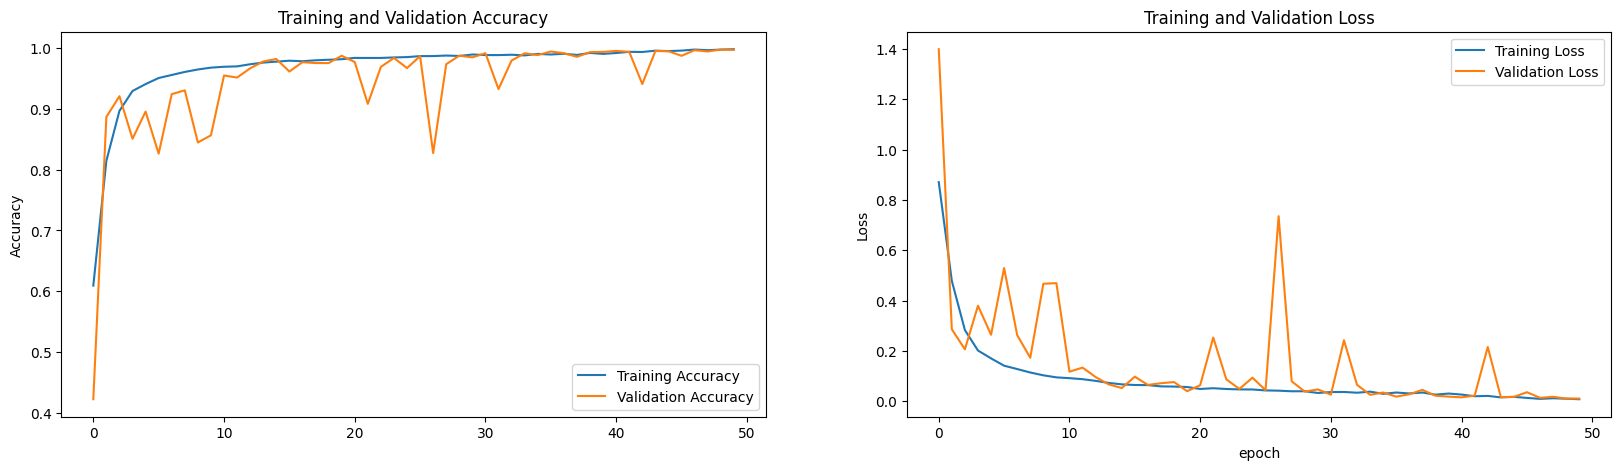

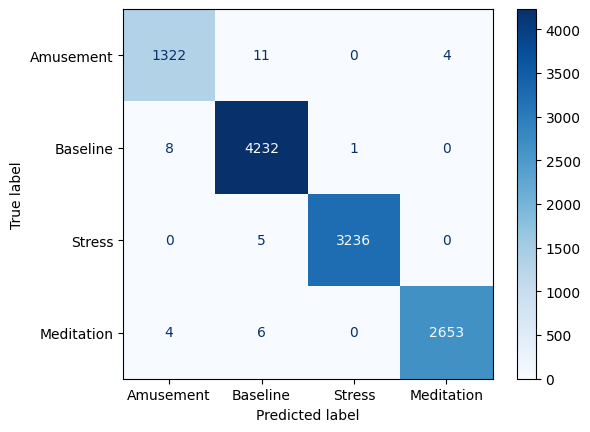

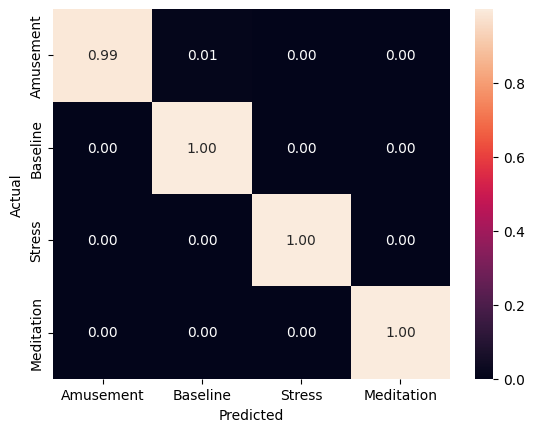

=========================================__Fold__2_______=================================
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_40 (Conv1D)             (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_50 (Conv1D)             (None, 2100, 8)      48          ['input_rhythm[0][0]']           
 

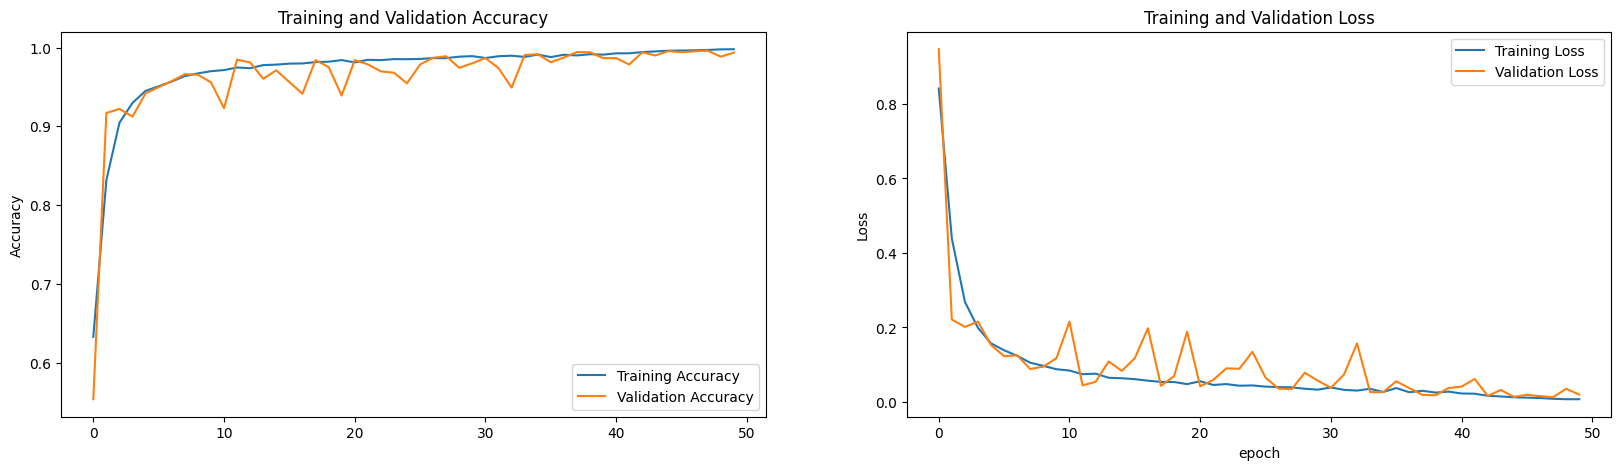

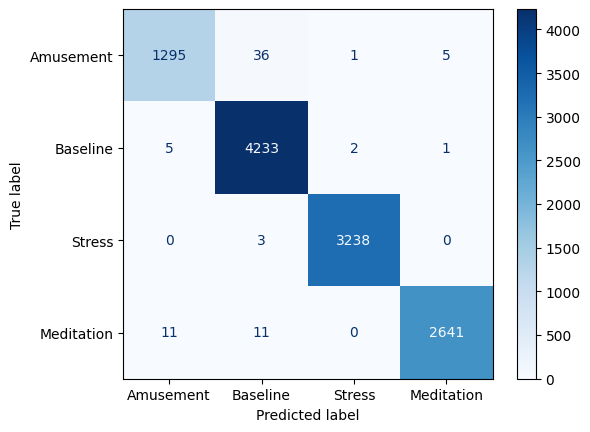

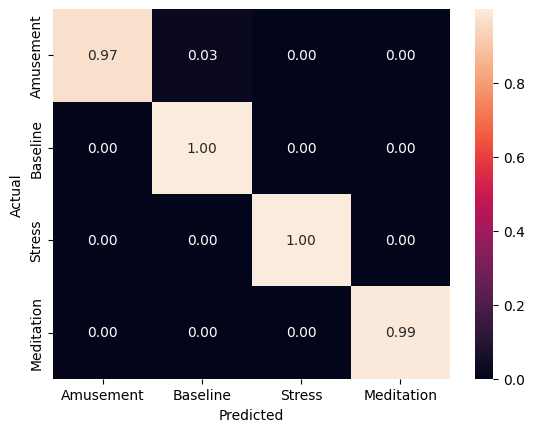

=========================================__Fold__3_______=================================
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_60 (Conv1D)             (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_70 (Conv1D)             (None, 2100, 8)      48          ['input_rhythm[0][0]']           
 

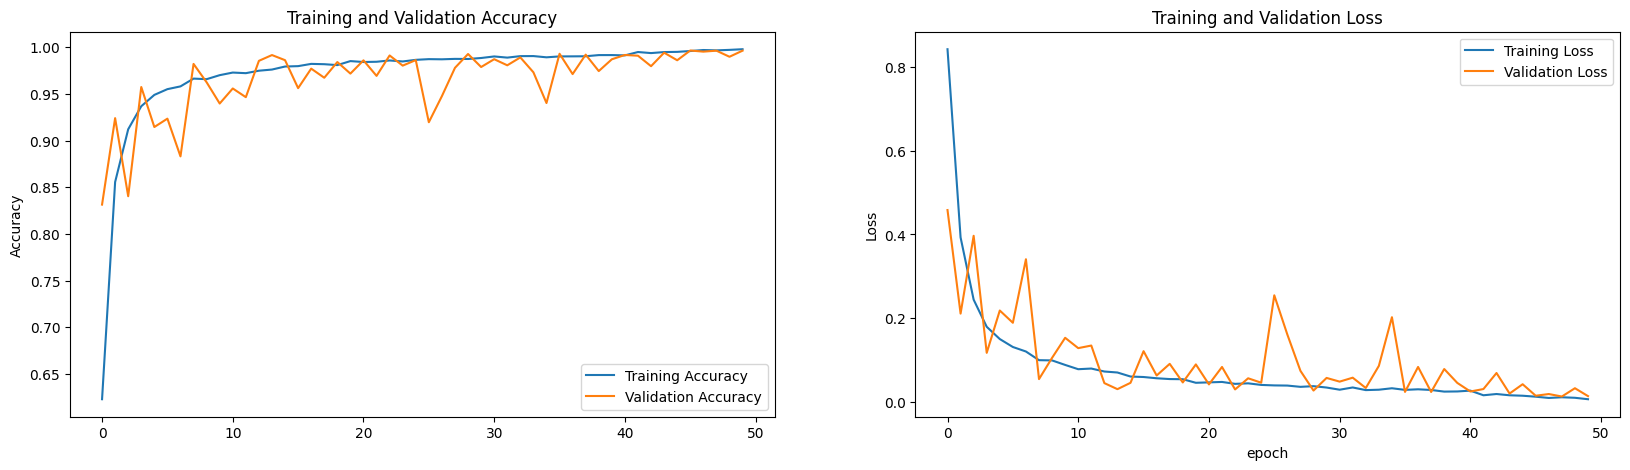

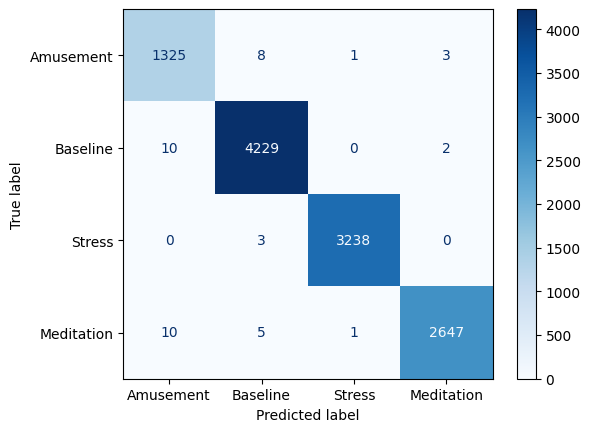

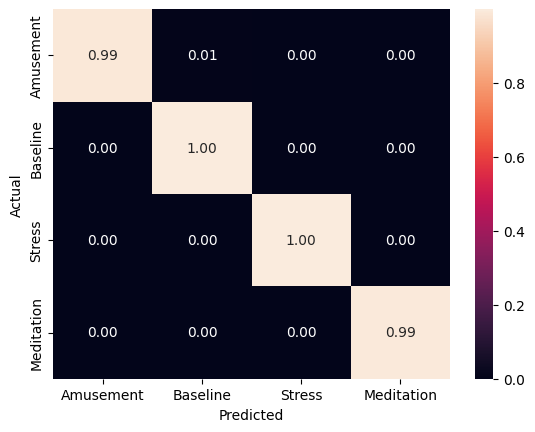

=========================================__Fold__4_______=================================
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_80 (Conv1D)             (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_90 (Conv1D)             (None, 2100, 8)      48          ['input_rhythm[0][0]']           
 

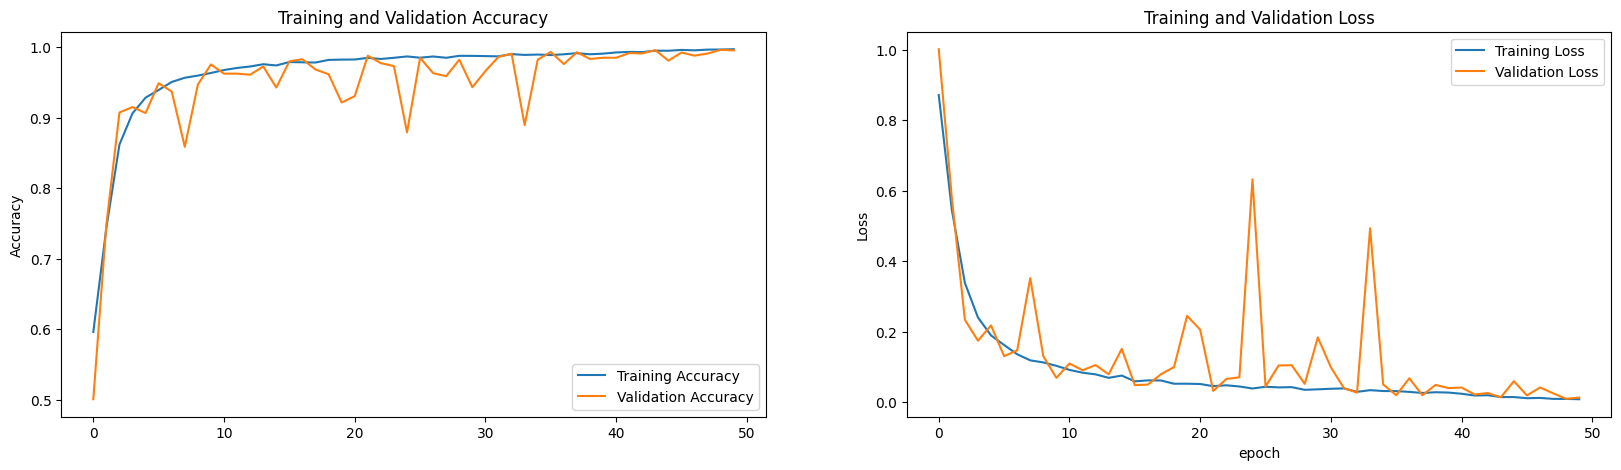

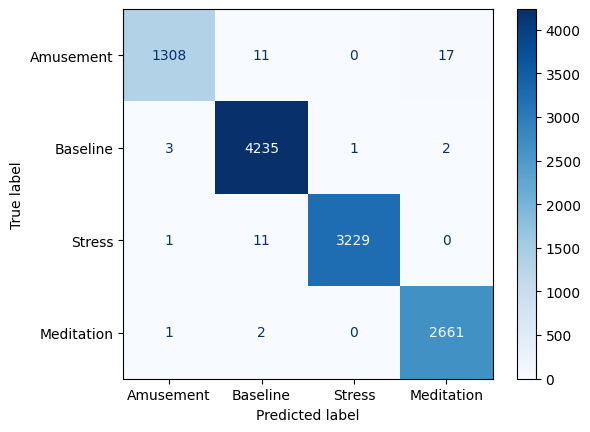

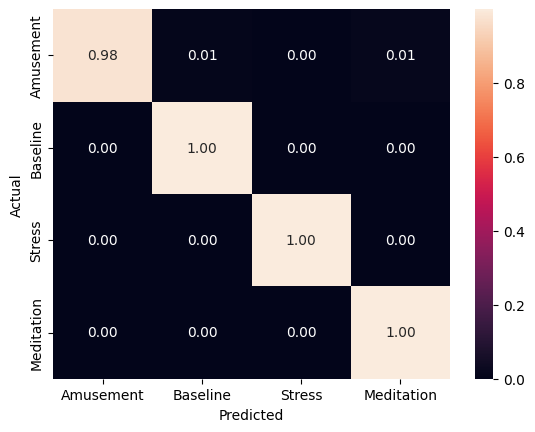

=========================================__Fold__5_______=================================
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_100 (Conv1D)            (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_110 (Conv1D)            (None, 2100, 8)      48          ['input_rhythm[0][0]']           
 

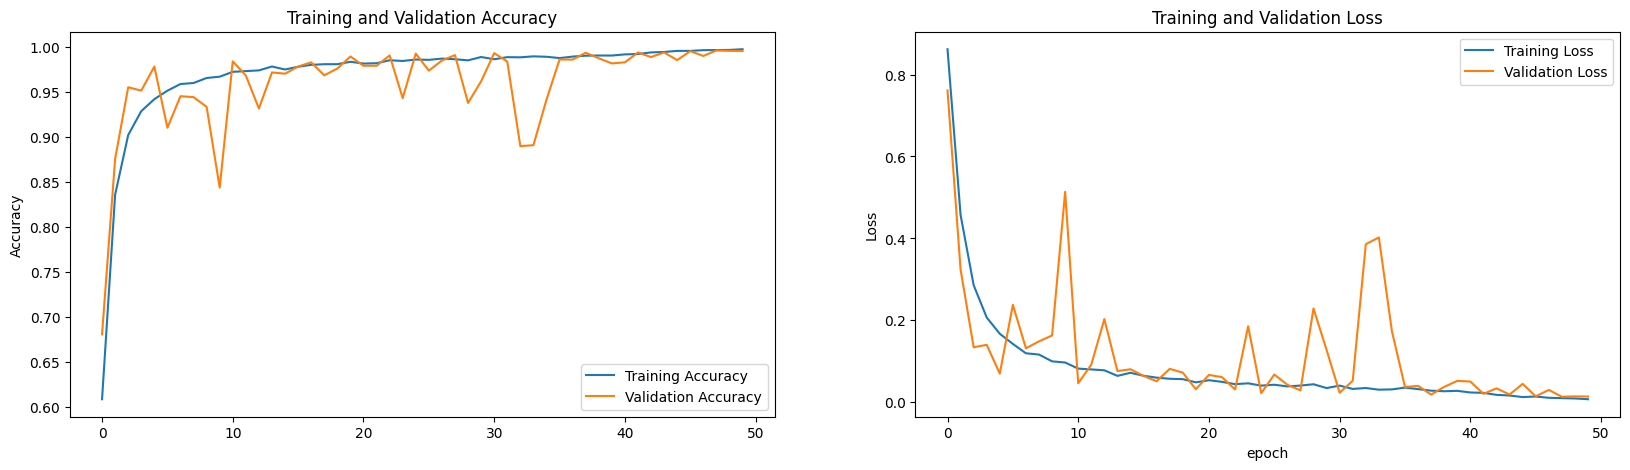

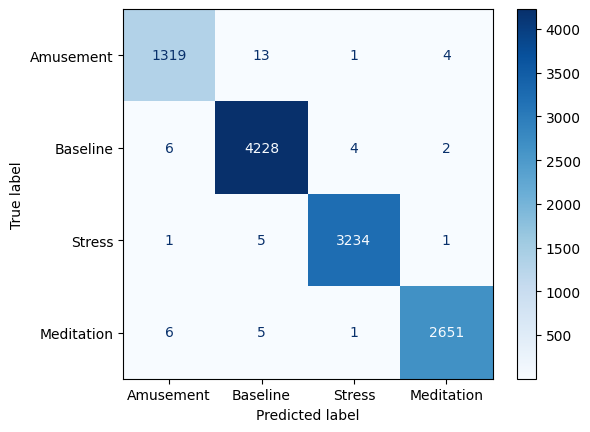

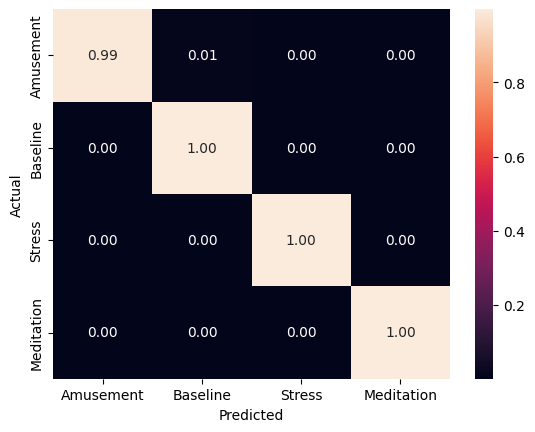

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=128)
number=1
save_model_path = "D:/Journal/WESAD_Model/Fusion_Method/"

for train_index, test_index in skf.split(train_beat, train_y):
    print('=========================================__Fold__'+str(number)+'_______=================================')
    X_train_b, X_test_b, X_train_r, X_test_r = train_beat[train_index], train_beat[test_index], train_rhythm[train_index], train_rhythm[test_index]
    Y_train, Y_test = train_y[train_index], train_y[test_index]

    y_train = to_categorical(Y_train)
    y_test = to_categorical(Y_test)    
    class_weight = cal_class_weight(train_y)

    
    fusion_model = WESAD_fusion_model(X_train_b.shape[1], X_train_r.shape[1])
    callback_lr = tf.keras.callbacks.LearningRateScheduler(scheuler)
    fusion_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = fusion_model.fit([X_train_b, X_train_r], y_train, 
                        validation_data=([X_test_b, X_test_r], y_test), 
                        epochs=50, 
                        batch_size=32,
                        class_weight = class_weight,
                        callbacks=[callback_lr],
                       ) 

    
    scores = fusion_model.evaluate([X_test_b,X_test_r], y_test)
    Plot_lr_curve(history)
    pred = fusion_model.predict([X_test_b,X_test_r])
    Plot_confusion_matrix(y_test, pred, class_name)

    
    fusion_model.save(save_model_path + 'Average_Fusion_5_layer(8,2)(0.0001)_3s_Fold_'  +str(number)+ '_(' + str(np.round(scores[1]*100,2)) + ').h5')
    number+=1
    
    

# Maximum

In [11]:
from tensorflow.keras.layers import Average, maximum, Multiply, Add, dot


def WESAD_fusion_model_Maximum(re_X_train_b, re_X_train_r):
    input_beat = Input(shape=(re_X_train_b,1), name = 'input_beat')
    input_rhythm = Input(shape=(re_X_train_r,1), name = 'input_rhythm')

    conv1_B = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(input_beat)
    conv2_B = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B)
    bn1_B = BatchNormalization()(conv2_B)
    act_B = Activation('relu')(bn1_B)
    max1_B = MaxPooling1D(2,2)(act_B)

    conv1_B_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B)
    conv2_B_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_1)
    bn1_B_1 = BatchNormalization()(conv2_B_1)
    act_B_1 = Activation('relu')(bn1_B_1)
    max1_B_1 = MaxPooling1D(2,2)(act_B_1)


    conv1_B_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_1)
    conv2_B_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_2)
    bn1_B_2 = BatchNormalization()(conv2_B_2)
    act_B_2 = Activation('relu')(bn1_B_2)
    max1_B_2 = MaxPooling1D(2,2)(act_B_2)

    conv1_B_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_2)
    conv2_B_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_3)
    bn1_B_3 = BatchNormalization()(conv2_B_3)
    act_B_3 = Activation('relu')(bn1_B_3)
    max1_B_3 = MaxPooling1D(2,2)(act_B_3)

    conv1_B_3 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_3)
    conv2_B_3 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_3)
    bn1_B_3 = BatchNormalization()(conv2_B_3)
    act_B_3 = Activation('relu')(bn1_B_3)
    max1_B_3 = MaxPooling1D(2,2)(act_B_3)

    GAP_B = GlobalAveragePooling1D()(max1_B_3)

    # Rhythm

    conv1_R = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(input_rhythm)
    conv2_R = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R)
    bn1_R = BatchNormalization()(conv2_R)
    act_R = Activation('relu')(bn1_R)
    max1_R = MaxPooling1D(2,2)(act_R)

    conv1_R_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R)
    conv2_R_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_1)
    bn1_R_1 = BatchNormalization()(conv2_R_1)
    act_R_1 = Activation('relu')(bn1_R_1)
    max1_R_1 = MaxPooling1D(2,2)(act_R_1)


    conv1_R_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_1)
    conv2_R_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_2)
    bn1_R_2 = BatchNormalization()(conv2_R_2)
    act_R_2 = Activation('relu')(bn1_R_2)
    max1_R_2 = MaxPooling1D(2,2)(act_R_2)


    conv1_R_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_2)
    conv2_R_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_3)
    bn1_R_3 = BatchNormalization()(conv2_R_3)
    act_R_3 = Activation('relu')(bn1_R_3)
    max1_R_3 = MaxPooling1D(2,2)(act_R_3)


    conv1_R_4 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_3)
    conv2_R_4 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_4)
    bn1_R_4 = BatchNormalization()(conv2_R_4)
    act_R_4 = Activation('relu')(bn1_R_4)
    max1_R_4 = MaxPooling1D(2,2)(act_R_4)


    GAP_R = GlobalAveragePooling1D()(max1_R_4)

    # Fusion
    maximum_layer = maximum([GAP_B, GAP_R])

    re_R = Reshape((1, maximum_layer.shape[1]))(maximum_layer)
    x_R_LSTM = LSTM(128,return_sequences=True)(re_R)
    x_R_LSTM2 = LSTM(64, return_sequences=True)(x_R_LSTM)
    fl_f = Flatten()(x_R_LSTM2)

    den1 = Dense(128, activation='relu')(fl_f)
    den2 = Dense(64, activation='relu')(den1)

    fusion_output = Dense(4, activation='softmax')(den2)

    fusion_model = Model(inputs=[input_beat, input_rhythm], outputs= fusion_output)
    fusion_model.summary()
    
    return fusion_model

=========================================__Fold__1_______=================================
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_120 (Conv1D)            (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_130 (Conv1D)            (None, 2100, 8)      48          ['input_rhythm[0][0]']           
 

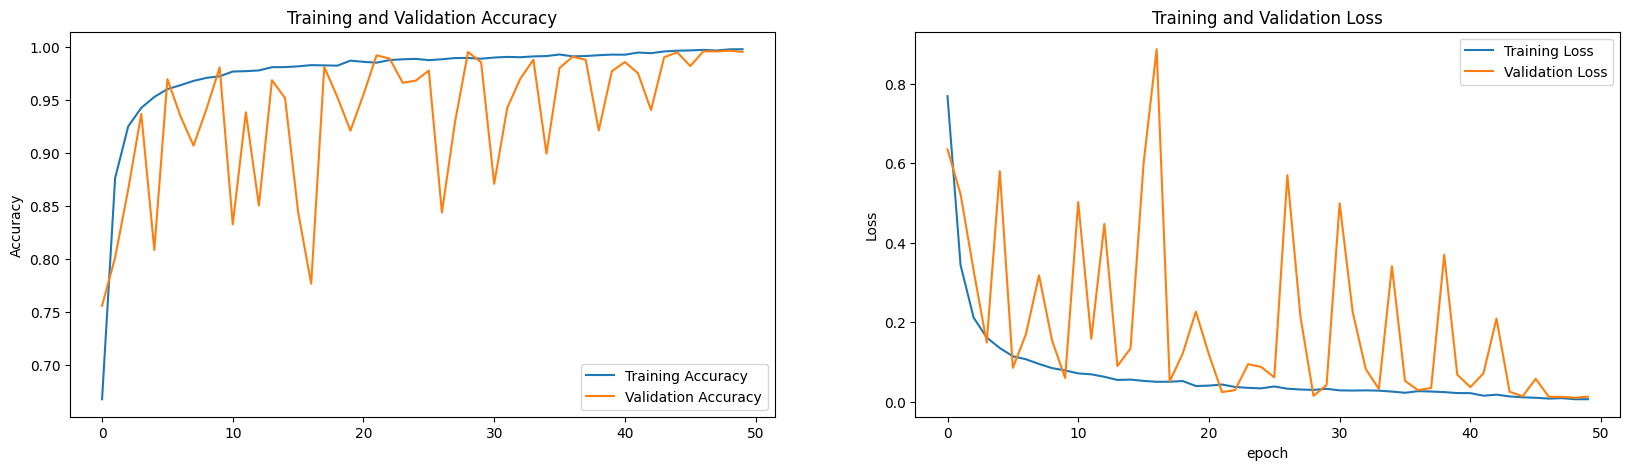

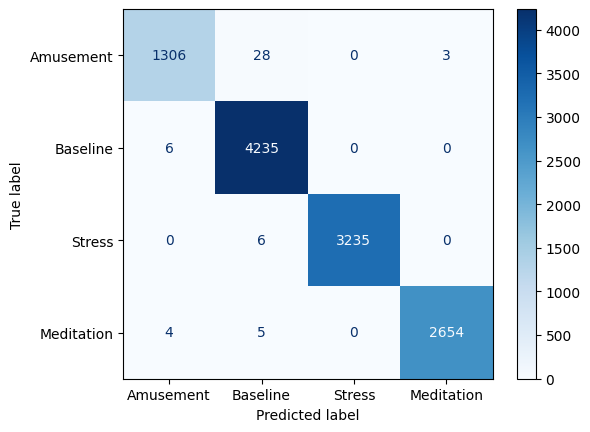

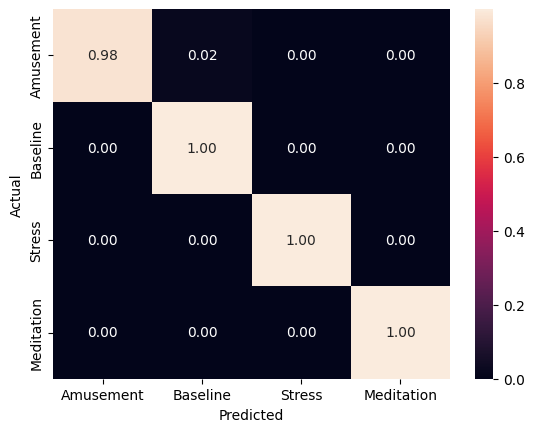

=========================================__Fold__2_______=================================
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_140 (Conv1D)            (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_150 (Conv1D)            (None, 2100, 8)      48          ['input_rhythm[0][0]']           
 

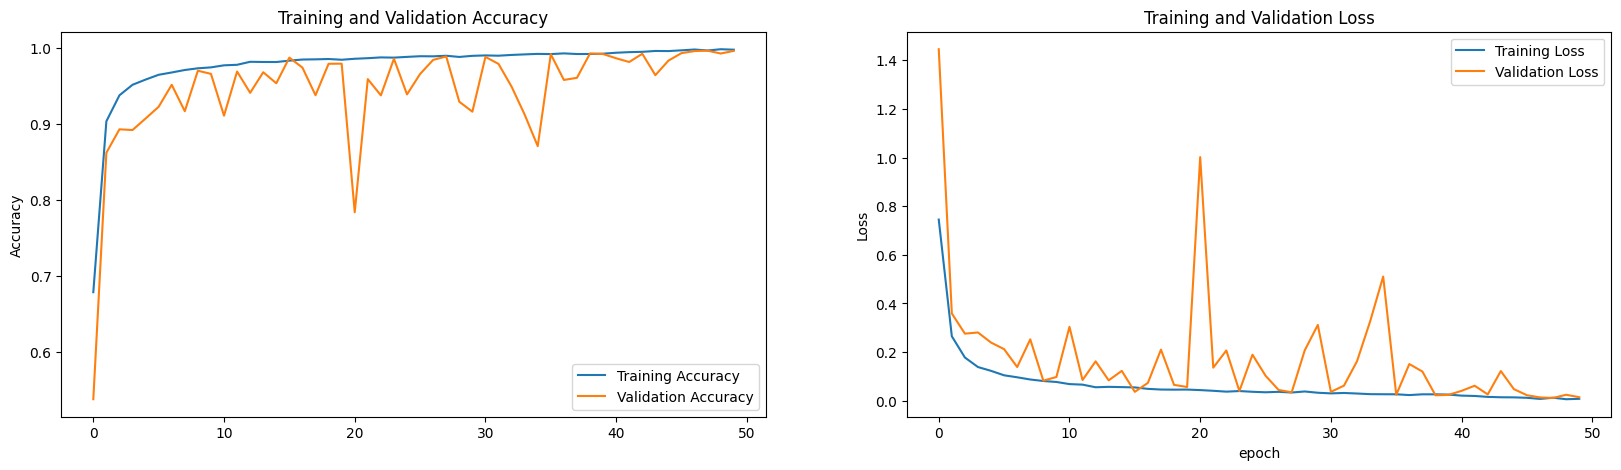

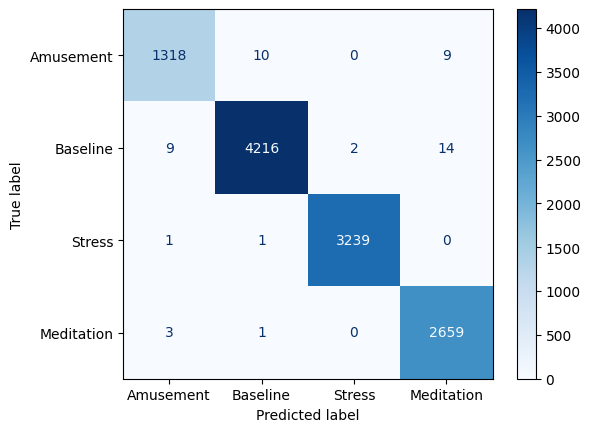

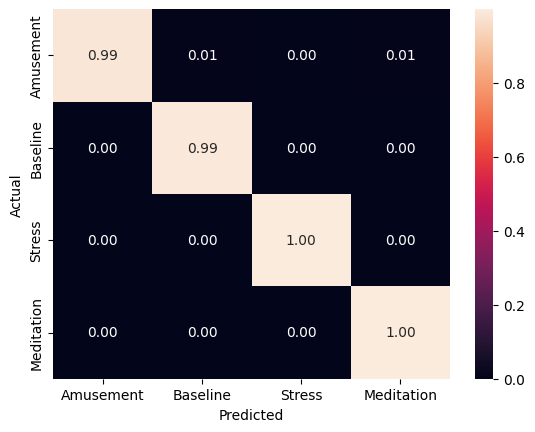

=========================================__Fold__3_______=================================
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_160 (Conv1D)            (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_170 (Conv1D)            (None, 2100, 8)      48          ['input_rhythm[0][0]']           
 

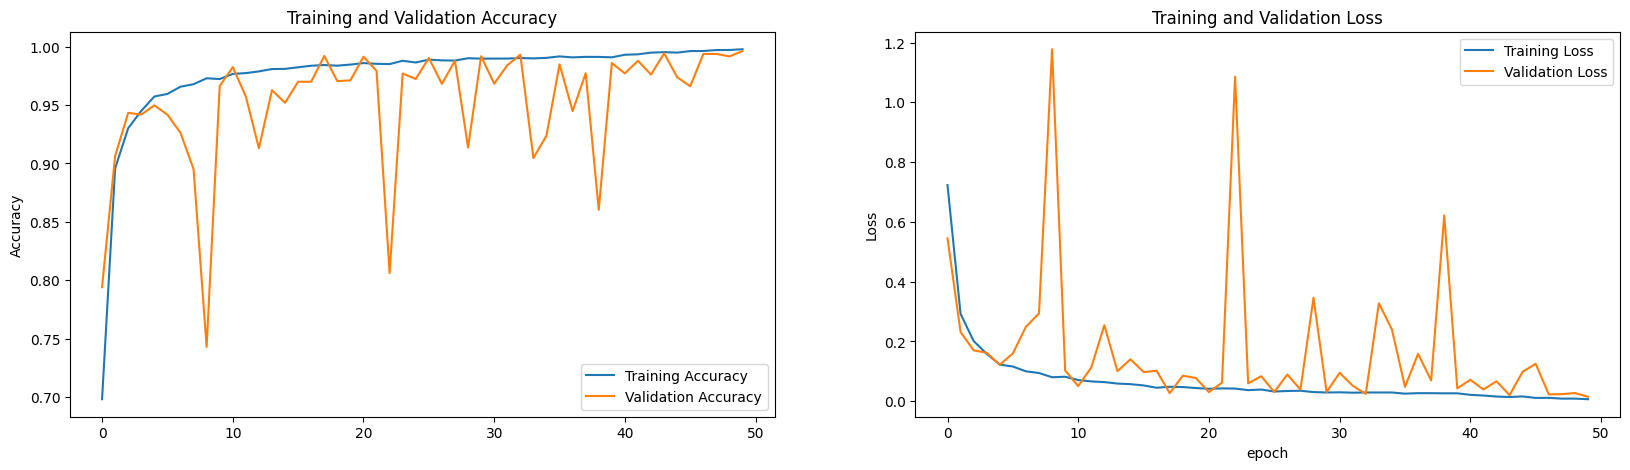

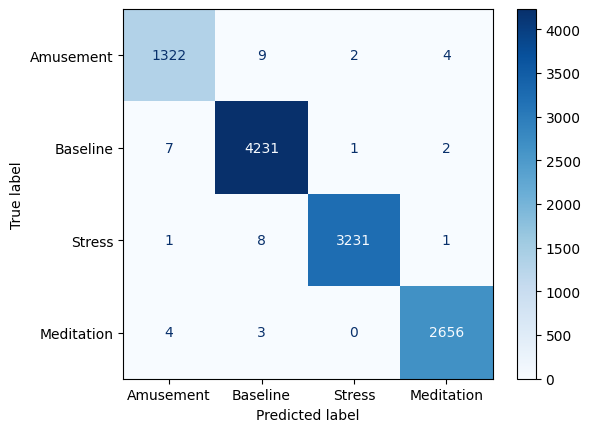

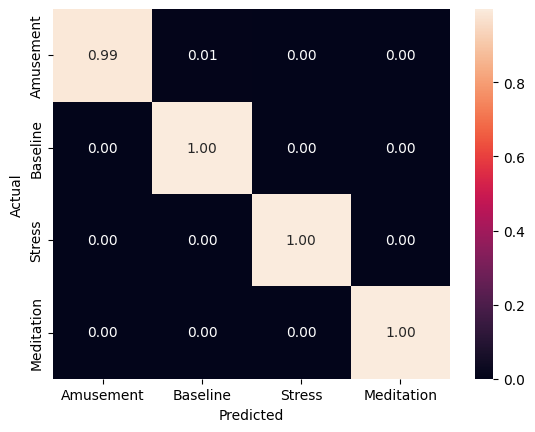

=========================================__Fold__4_______=================================
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_180 (Conv1D)            (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_190 (Conv1D)            (None, 2100, 8)      48          ['input_rhythm[0][0]']           
 

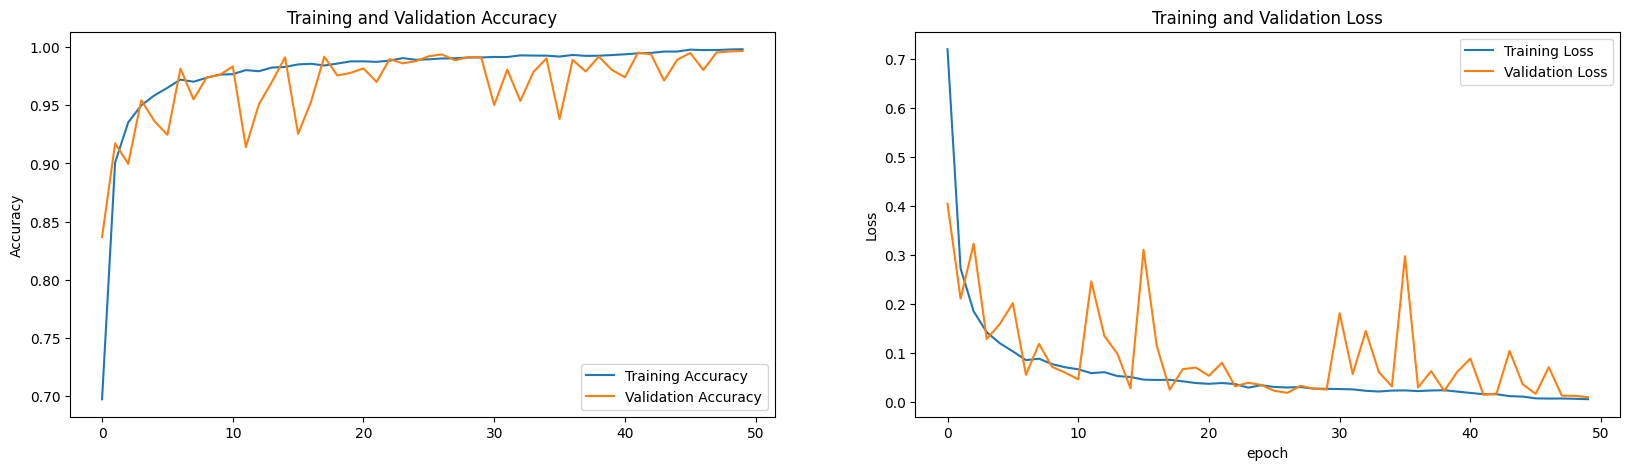

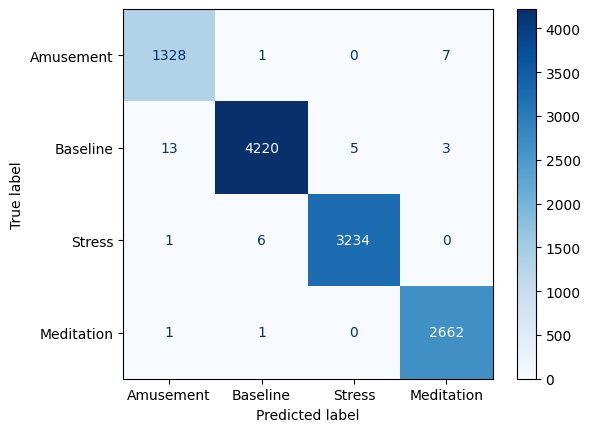

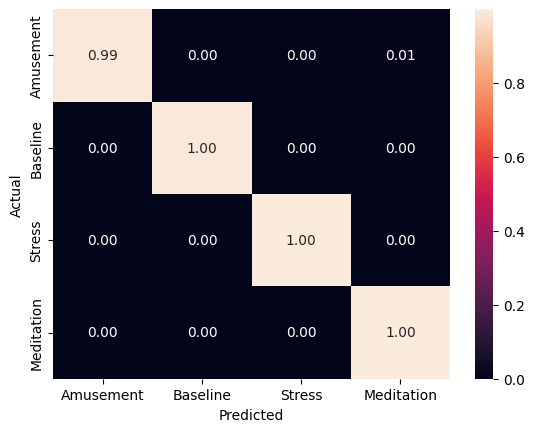

=========================================__Fold__5_______=================================
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_200 (Conv1D)            (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_210 (Conv1D)            (None, 2100, 8)      48          ['input_rhythm[0][0]']           


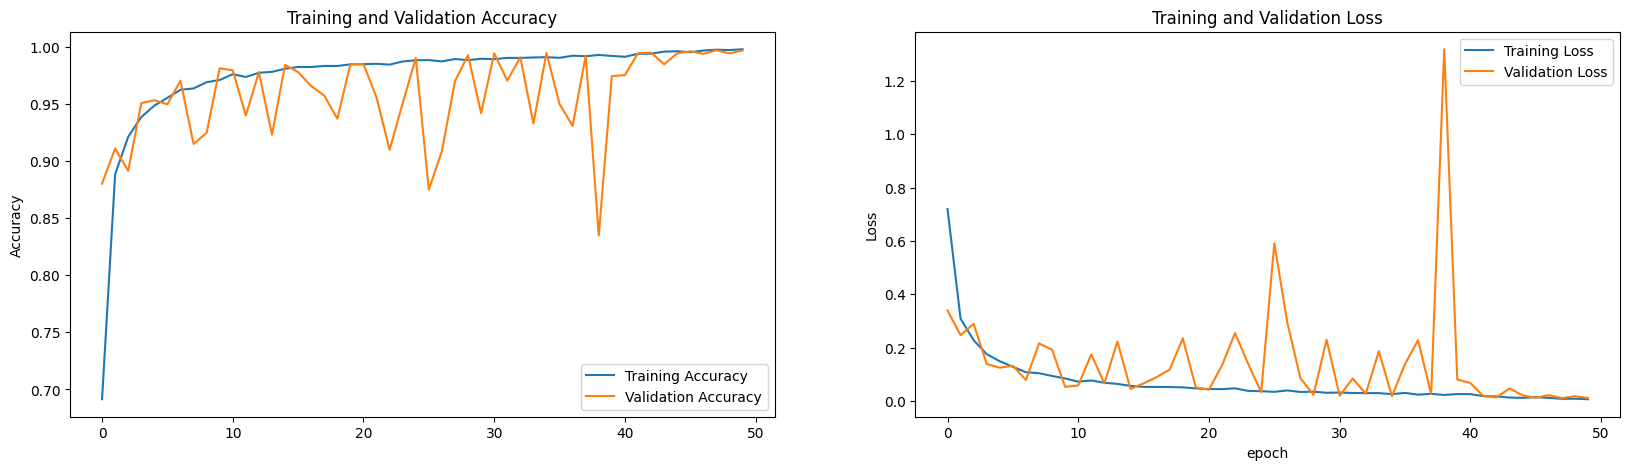

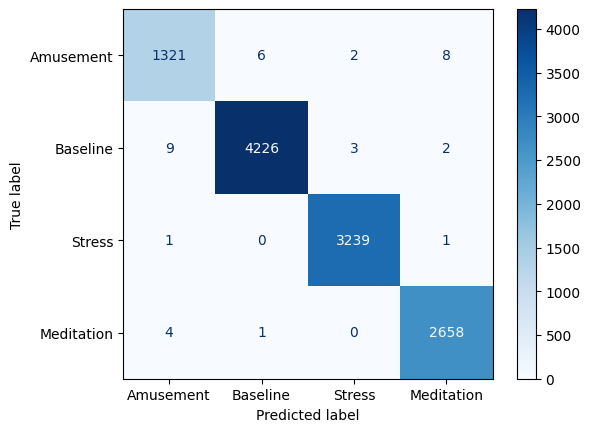

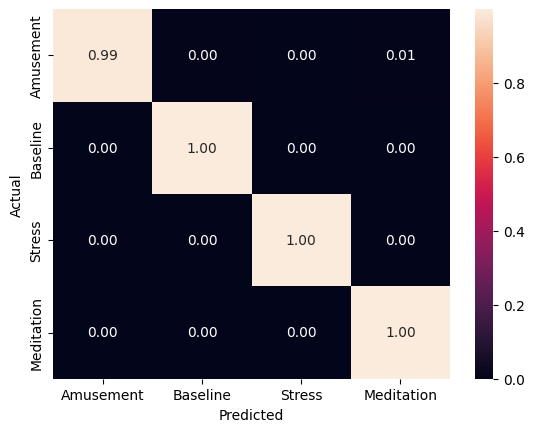

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=128)
number=1

for train_index, test_index in skf.split(train_beat, train_y):
    print('=========================================__Fold__'+str(number)+'_______=================================')
    X_train_b, X_test_b, X_train_r, X_test_r = train_beat[train_index], train_beat[test_index], train_rhythm[train_index], train_rhythm[test_index]
    Y_train, Y_test = train_y[train_index], train_y[test_index]

    y_train = to_categorical(Y_train)
    y_test = to_categorical(Y_test)    
    class_weight = cal_class_weight(train_y)

    
    fusion_model = WESAD_fusion_model_Maximum(X_train_b.shape[1], X_train_r.shape[1])
    callback_lr = tf.keras.callbacks.LearningRateScheduler(scheuler)
    fusion_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = fusion_model.fit([X_train_b, X_train_r], y_train, 
                        validation_data=([X_test_b, X_test_r], y_test), 
                        epochs=50, 
                        batch_size=32,
                        class_weight = class_weight,
                        callbacks=[callback_lr],
                       ) 

    
    scores = fusion_model.evaluate([X_test_b,X_test_r], y_test)
    Plot_lr_curve(history)
    pred = fusion_model.predict([X_test_b,X_test_r])
    Plot_confusion_matrix(y_test, pred, class_name)

    
    fusion_model.save(save_model_path + 'Maximum_Fusion_5_layer(8,2)(0.0001)_3s_Fold_'  +str(number)+ '_(' + str(np.round(scores[1]*100,2)) + ').h5')
    number+=1
    
    

# Multiply

In [13]:
from tensorflow.keras.layers import Average, maximum, Multiply, Add, dot


def WESAD_fusion_model_Multimply(re_X_train_b, re_X_train_r):
    input_beat = Input(shape=(re_X_train_b,1), name = 'input_beat')
    input_rhythm = Input(shape=(re_X_train_r,1), name = 'input_rhythm')

    conv1_B = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(input_beat)
    conv2_B = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B)
    bn1_B = BatchNormalization()(conv2_B)
    act_B = Activation('relu')(bn1_B)
    max1_B = MaxPooling1D(2,2)(act_B)

    conv1_B_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B)
    conv2_B_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_1)
    bn1_B_1 = BatchNormalization()(conv2_B_1)
    act_B_1 = Activation('relu')(bn1_B_1)
    max1_B_1 = MaxPooling1D(2,2)(act_B_1)


    conv1_B_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_1)
    conv2_B_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_2)
    bn1_B_2 = BatchNormalization()(conv2_B_2)
    act_B_2 = Activation('relu')(bn1_B_2)
    max1_B_2 = MaxPooling1D(2,2)(act_B_2)

    conv1_B_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_2)
    conv2_B_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_3)
    bn1_B_3 = BatchNormalization()(conv2_B_3)
    act_B_3 = Activation('relu')(bn1_B_3)
    max1_B_3 = MaxPooling1D(2,2)(act_B_3)

    conv1_B_3 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_3)
    conv2_B_3 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_3)
    bn1_B_3 = BatchNormalization()(conv2_B_3)
    act_B_3 = Activation('relu')(bn1_B_3)
    max1_B_3 = MaxPooling1D(2,2)(act_B_3)

    GAP_B = GlobalAveragePooling1D()(max1_B_3)

    # Rhythm

    conv1_R = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(input_rhythm)
    conv2_R = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R)
    bn1_R = BatchNormalization()(conv2_R)
    act_R = Activation('relu')(bn1_R)
    max1_R = MaxPooling1D(2,2)(act_R)

    conv1_R_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R)
    conv2_R_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_1)
    bn1_R_1 = BatchNormalization()(conv2_R_1)
    act_R_1 = Activation('relu')(bn1_R_1)
    max1_R_1 = MaxPooling1D(2,2)(act_R_1)


    conv1_R_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_1)
    conv2_R_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_2)
    bn1_R_2 = BatchNormalization()(conv2_R_2)
    act_R_2 = Activation('relu')(bn1_R_2)
    max1_R_2 = MaxPooling1D(2,2)(act_R_2)


    conv1_R_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_2)
    conv2_R_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_3)
    bn1_R_3 = BatchNormalization()(conv2_R_3)
    act_R_3 = Activation('relu')(bn1_R_3)
    max1_R_3 = MaxPooling1D(2,2)(act_R_3)


    conv1_R_4 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_3)
    conv2_R_4 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_4)
    bn1_R_4 = BatchNormalization()(conv2_R_4)
    act_R_4 = Activation('relu')(bn1_R_4)
    max1_R_4 = MaxPooling1D(2,2)(act_R_4)


    GAP_R = GlobalAveragePooling1D()(max1_R_4)

    # Fusion
    multiply_layer = Multiply()([GAP_B, GAP_R])

    re_R = Reshape((1, multiply_layer.shape[1]))(multiply_layer)
    x_R_LSTM = LSTM(128,return_sequences=True)(re_R)
    x_R_LSTM2 = LSTM(64, return_sequences=True)(x_R_LSTM)
    fl_f = Flatten()(x_R_LSTM2)

    den1 = Dense(128, activation='relu')(fl_f)
    den2 = Dense(64, activation='relu')(den1)

    fusion_output = Dense(4, activation='softmax')(den2)

    fusion_model = Model(inputs=[input_beat, input_rhythm], outputs= fusion_output)
    fusion_model.summary()
    
    return fusion_model

=========================================__Fold__1_______=================================
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_220 (Conv1D)            (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_230 (Conv1D)            (None, 2100, 8)      48          ['input_rhythm[0][0]']           


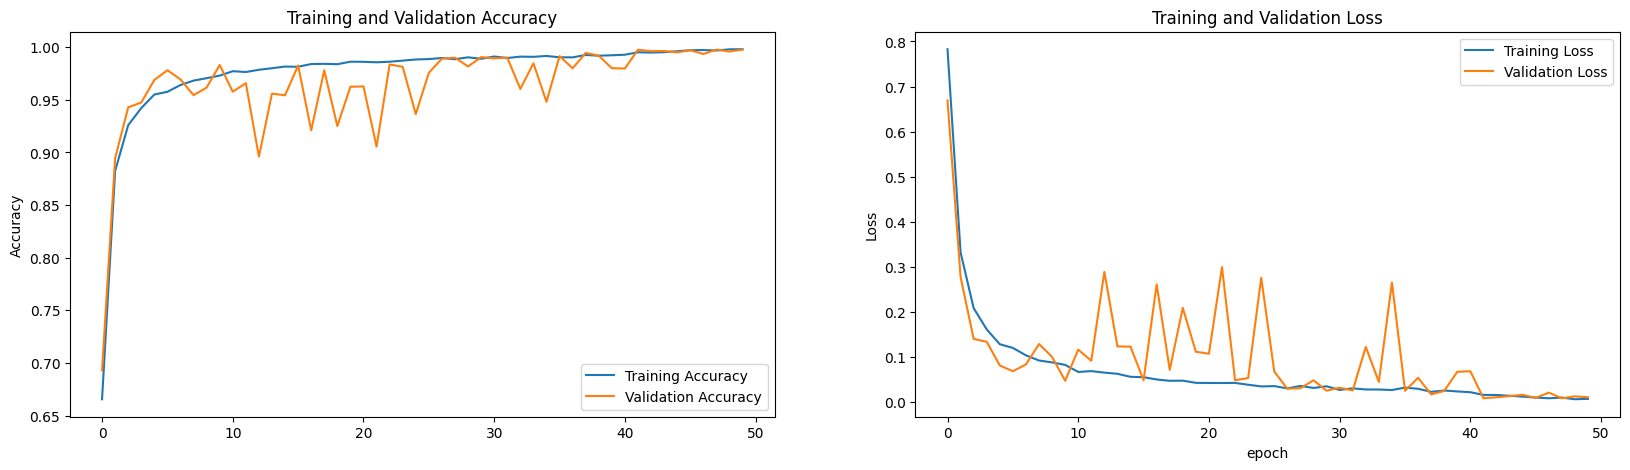

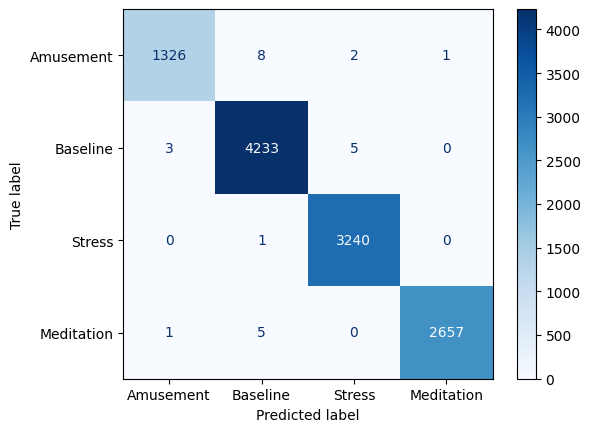

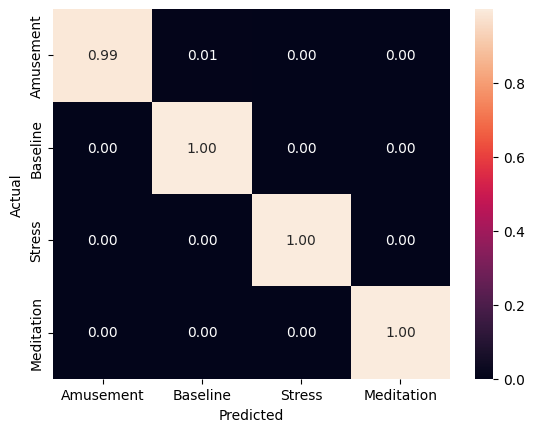

=========================================__Fold__2_______=================================
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_240 (Conv1D)            (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_250 (Conv1D)            (None, 2100, 8)      48          ['input_rhythm[0][0]']           


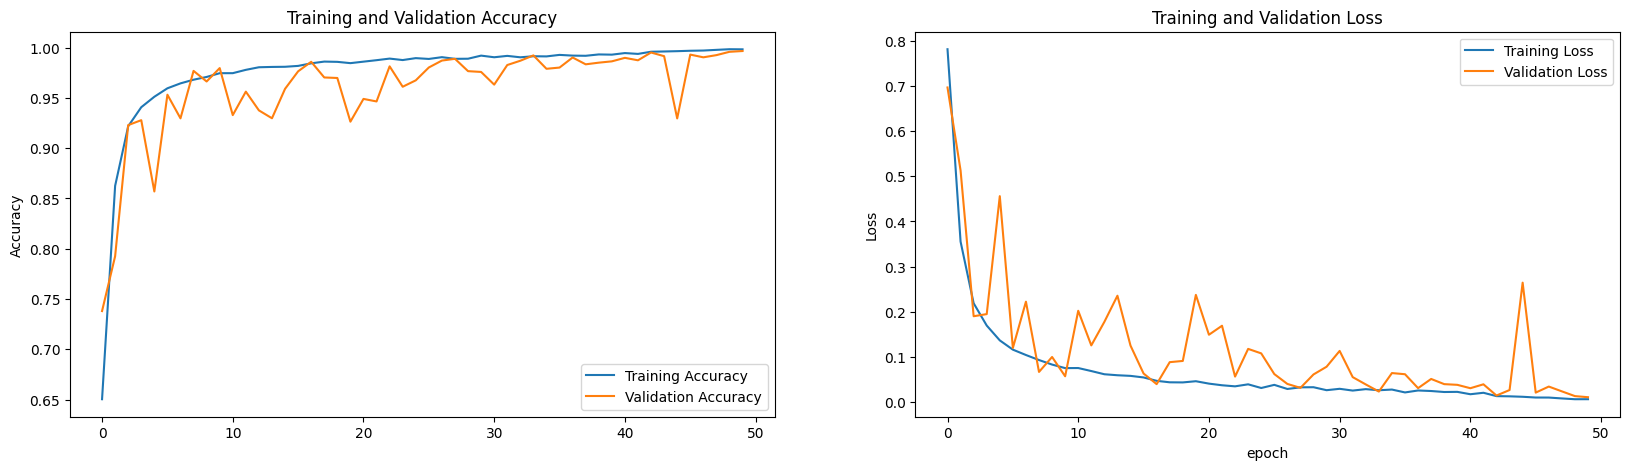

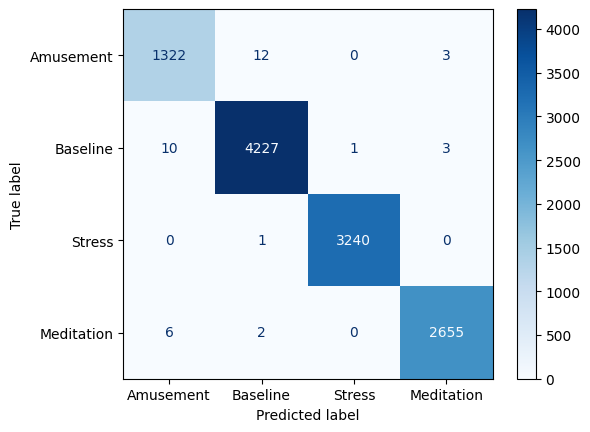

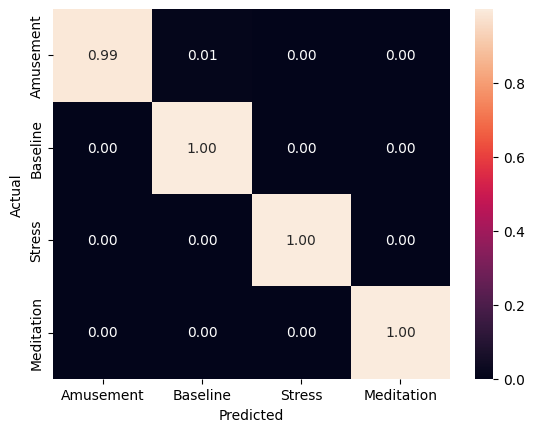

=========================================__Fold__3_______=================================
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_260 (Conv1D)            (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_270 (Conv1D)            (None, 2100, 8)      48          ['input_rhythm[0][0]']           


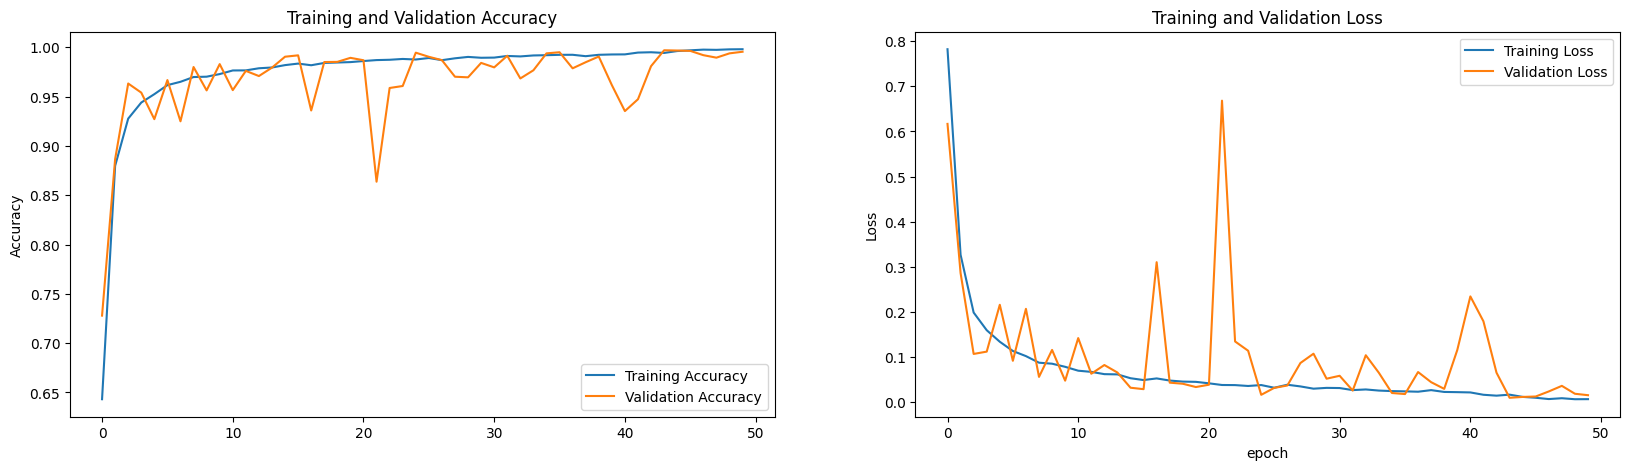

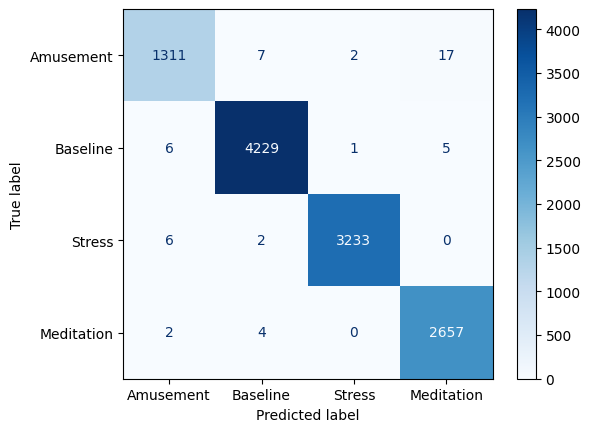

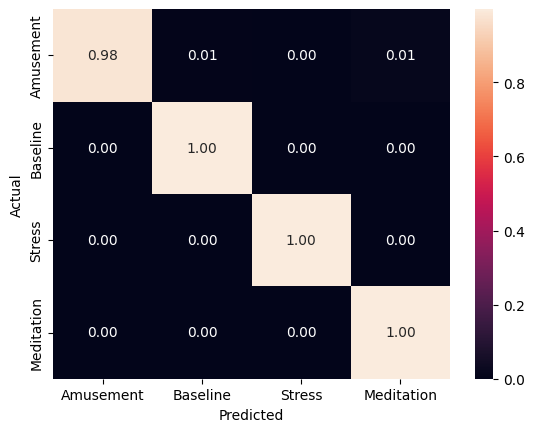

=========================================__Fold__4_______=================================
Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_280 (Conv1D)            (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_290 (Conv1D)            (None, 2100, 8)      48          ['input_rhythm[0][0]']           


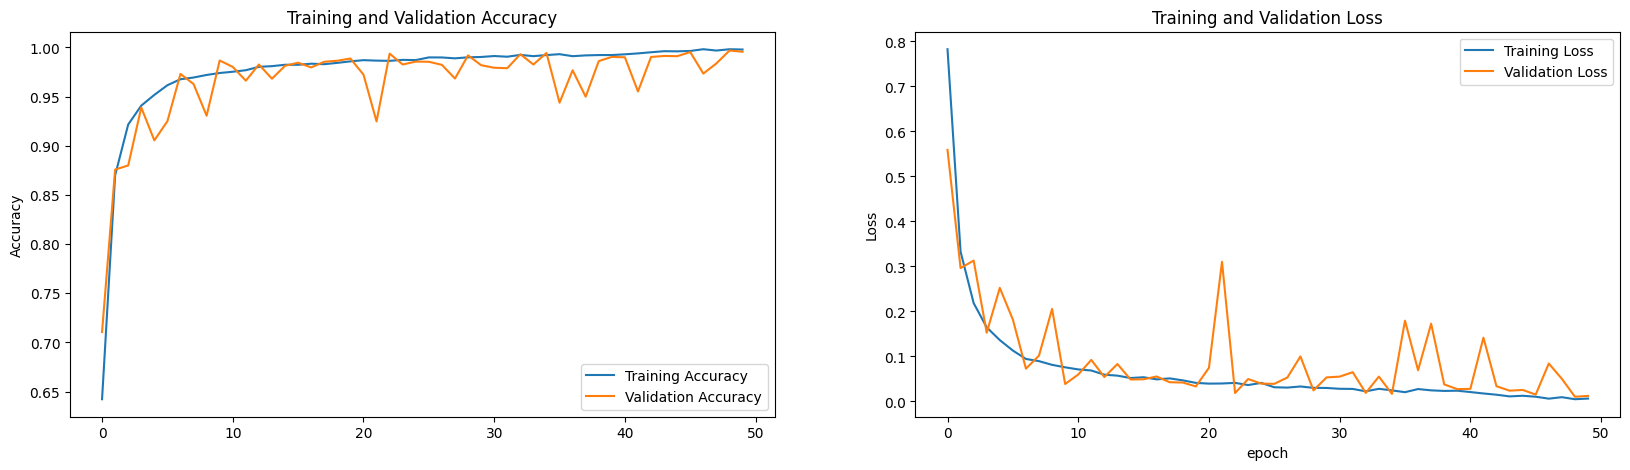

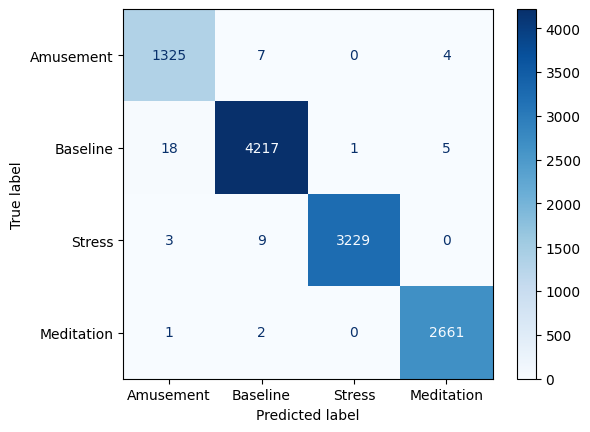

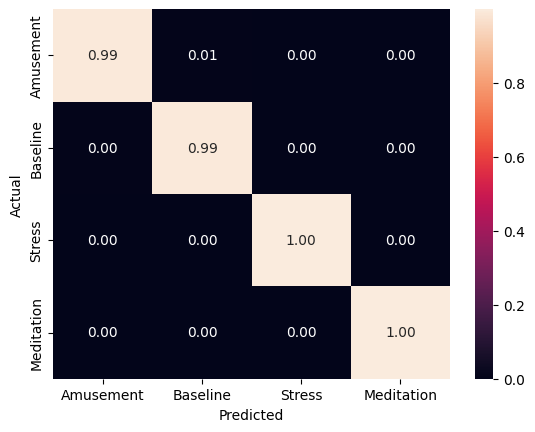

=========================================__Fold__5_______=================================
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_300 (Conv1D)            (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_310 (Conv1D)            (None, 2100, 8)      48          ['input_rhythm[0][0]']           


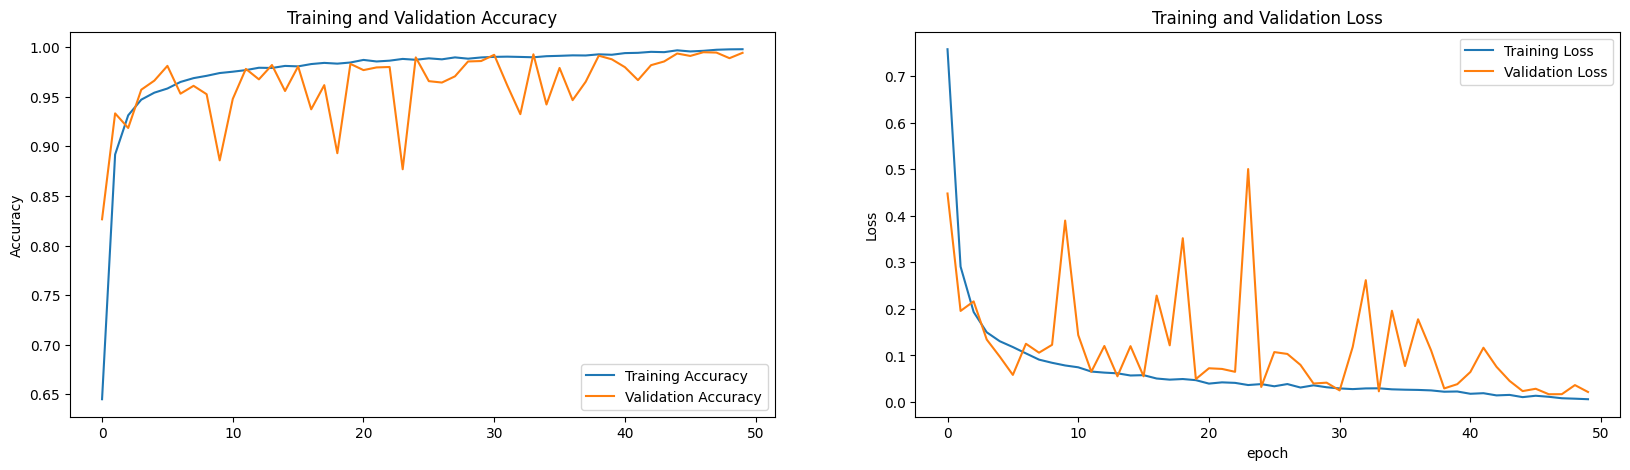

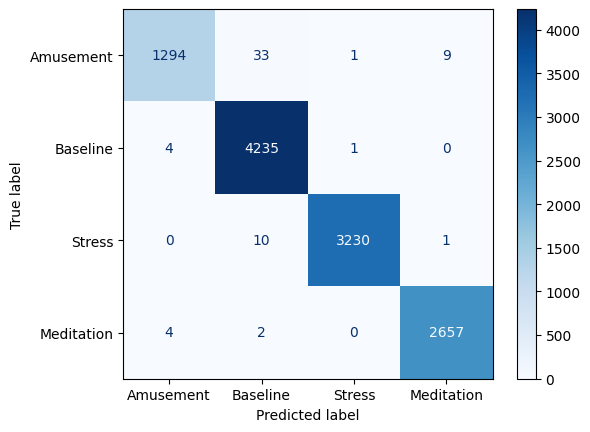

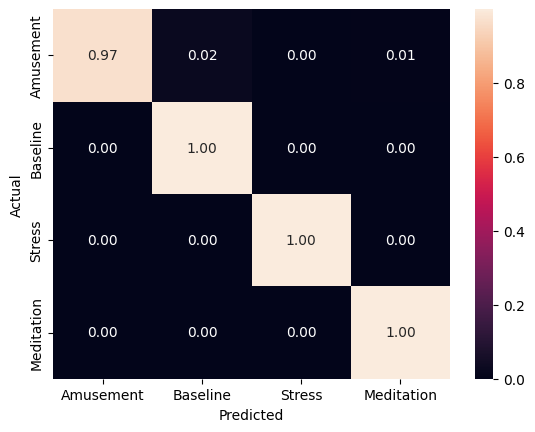

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=128)
number=1

for train_index, test_index in skf.split(train_beat, train_y):
    print('=========================================__Fold__'+str(number)+'_______=================================')
    X_train_b, X_test_b, X_train_r, X_test_r = train_beat[train_index], train_beat[test_index], train_rhythm[train_index], train_rhythm[test_index]
    Y_train, Y_test = train_y[train_index], train_y[test_index]

    y_train = to_categorical(Y_train)
    y_test = to_categorical(Y_test)    
    class_weight = cal_class_weight(train_y)

    
    fusion_model = WESAD_fusion_model_Multimply(X_train_b.shape[1], X_train_r.shape[1])
    callback_lr = tf.keras.callbacks.LearningRateScheduler(scheuler)
    fusion_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = fusion_model.fit([X_train_b, X_train_r], y_train, 
                        validation_data=([X_test_b, X_test_r], y_test), 
                        epochs=50, 
                        batch_size=32,
                        class_weight = class_weight,
                        callbacks=[callback_lr],
                       ) 

    
    scores = fusion_model.evaluate([X_test_b,X_test_r], y_test)
    Plot_lr_curve(history)
    pred = fusion_model.predict([X_test_b,X_test_r])
    Plot_confusion_matrix(y_test, pred, class_name)

    
    fusion_model.save(save_model_path + 'Multiply_Fusion_5_layer(8,2)(0.0001)_3s_Fold_'  +str(number)+ '_(' + str(np.round(scores[1]*100,2)) + ').h5')
    number+=1
    
    

# Add

In [7]:
from tensorflow.keras.layers import Average, maximum, Multiply, Add, dot


def WESAD_fusion_model_Add(re_X_train_b, re_X_train_r):
    input_beat = Input(shape=(re_X_train_b,1), name = 'input_beat')
    input_rhythm = Input(shape=(re_X_train_r,1), name = 'input_rhythm')

    conv1_B = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(input_beat)
    conv2_B = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B)
    bn1_B = BatchNormalization()(conv2_B)
    act_B = Activation('relu')(bn1_B)
    max1_B = MaxPooling1D(2,2)(act_B)

    conv1_B_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B)
    conv2_B_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_1)
    bn1_B_1 = BatchNormalization()(conv2_B_1)
    act_B_1 = Activation('relu')(bn1_B_1)
    max1_B_1 = MaxPooling1D(2,2)(act_B_1)


    conv1_B_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_1)
    conv2_B_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_2)
    bn1_B_2 = BatchNormalization()(conv2_B_2)
    act_B_2 = Activation('relu')(bn1_B_2)
    max1_B_2 = MaxPooling1D(2,2)(act_B_2)

    conv1_B_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_2)
    conv2_B_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_3)
    bn1_B_3 = BatchNormalization()(conv2_B_3)
    act_B_3 = Activation('relu')(bn1_B_3)
    max1_B_3 = MaxPooling1D(2,2)(act_B_3)

    conv1_B_3 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_3)
    conv2_B_3 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_3)
    bn1_B_3 = BatchNormalization()(conv2_B_3) 
    act_B_3 = Activation('relu')(bn1_B_3)
    max1_B_3 = MaxPooling1D(2,2)(act_B_3)

    GAP_B = GlobalAveragePooling1D()(max1_B_3)

    # Rhythm

    conv1_R = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(input_rhythm)
    conv2_R = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R)
    bn1_R = BatchNormalization()(conv2_R)
    act_R = Activation('relu')(bn1_R)
    max1_R = MaxPooling1D(2,2)(act_R)

    conv1_R_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R)
    conv2_R_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_1)
    bn1_R_1 = BatchNormalization()(conv2_R_1)
    act_R_1 = Activation('relu')(bn1_R_1)
    max1_R_1 = MaxPooling1D(2,2)(act_R_1)


    conv1_R_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_1)
    conv2_R_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_2)
    bn1_R_2 = BatchNormalization()(conv2_R_2)
    act_R_2 = Activation('relu')(bn1_R_2)
    max1_R_2 = MaxPooling1D(2,2)(act_R_2)


    conv1_R_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_2)
    conv2_R_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_3)
    bn1_R_3 = BatchNormalization()(conv2_R_3)
    act_R_3 = Activation('relu')(bn1_R_3)
    max1_R_3 = MaxPooling1D(2,2)(act_R_3)


    conv1_R_4 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_3)
    conv2_R_4 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_4)
    bn1_R_4 = BatchNormalization()(conv2_R_4)
    act_R_4 = Activation('relu')(bn1_R_4)
    max1_R_4 = MaxPooling1D(2,2)(act_R_4)


    GAP_R = GlobalAveragePooling1D()(max1_R_4)

    # Fusion
    Add_layer = Add()([GAP_B, GAP_R])

    re_R = Reshape((1, Add_layer.shape[1]))(Add_layer)
    x_R_LSTM = LSTM(128,return_sequences=True)(re_R)
    x_R_LSTM2 = LSTM(64, return_sequences=True)(x_R_LSTM)
    fl_f = Flatten()(x_R_LSTM2)

    den1 = Dense(128, activation='relu')(fl_f)
    den2 = Dense(64, activation='relu')(den1)

    fusion_output = Dense(4, activation='softmax')(den2)

    fusion_model = Model(inputs=[input_beat, input_rhythm], outputs= fusion_output)
    fusion_model.summary()
    
    return fusion_model

=========================================__Fold__1_______=================================
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_20 (Conv1D)             (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_30 (Conv1D)             (None, 2100, 8)      48          ['input_rhythm[0][0]']           
 

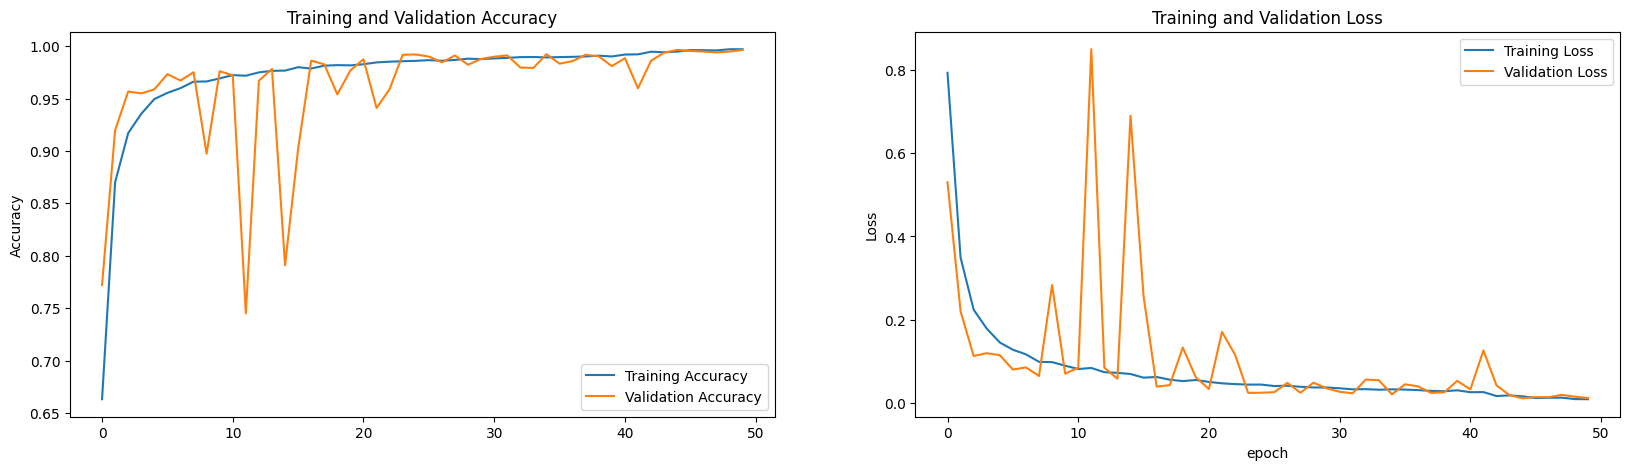

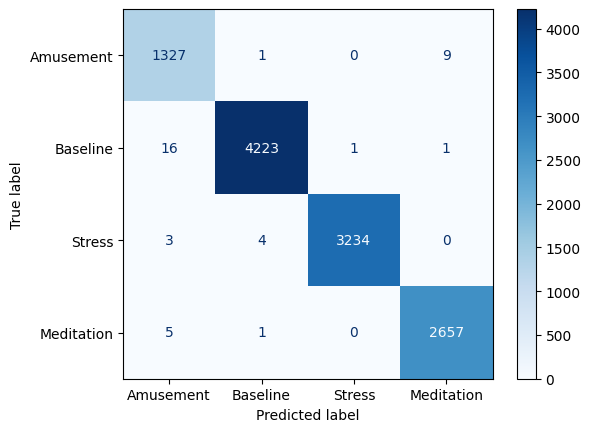

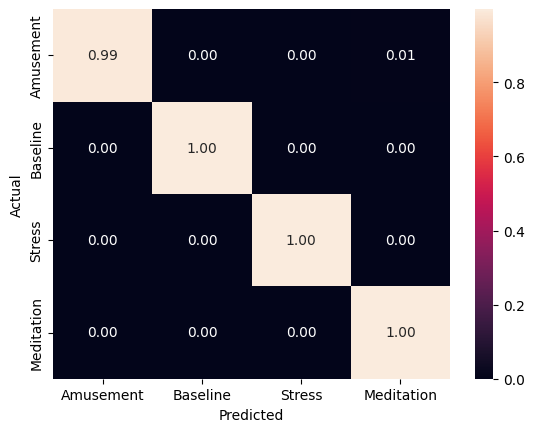

=========================================__Fold__2_______=================================
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_40 (Conv1D)             (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_50 (Conv1D)             (None, 2100, 8)      48          ['input_rhythm[0][0]']           
 

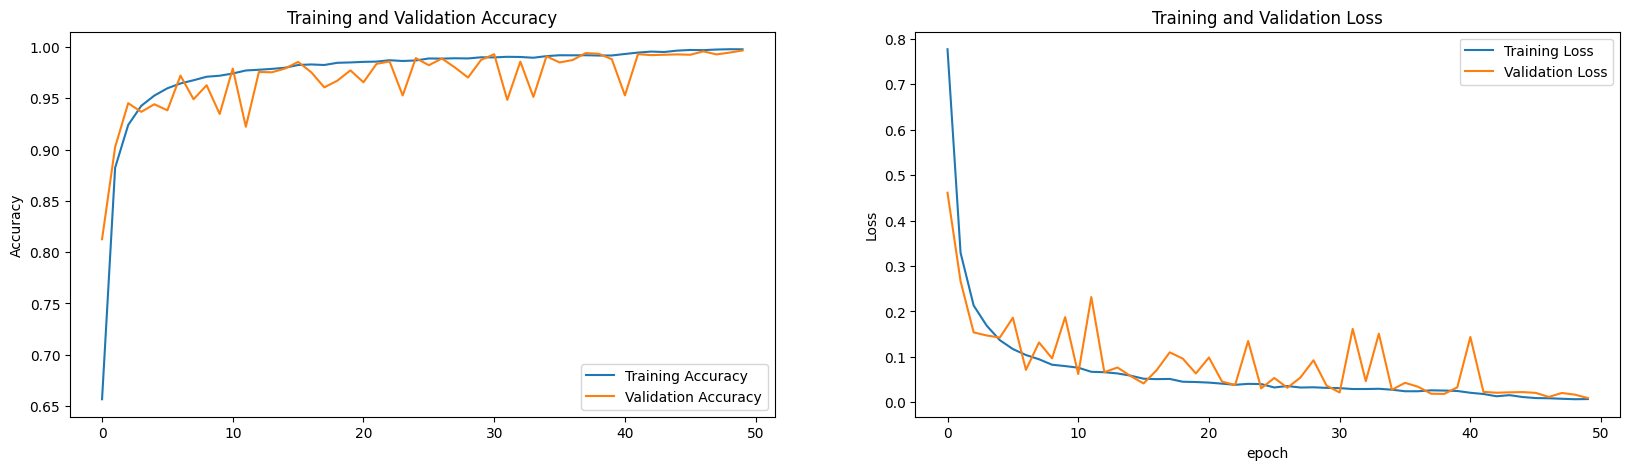

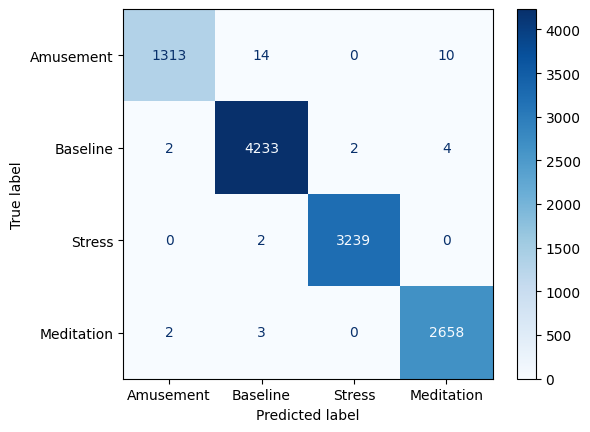

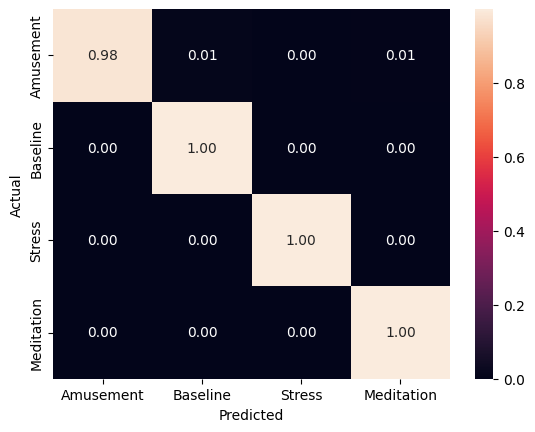

=========================================__Fold__3_______=================================
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_60 (Conv1D)             (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_70 (Conv1D)             (None, 2100, 8)      48          ['input_rhythm[0][0]']           
 

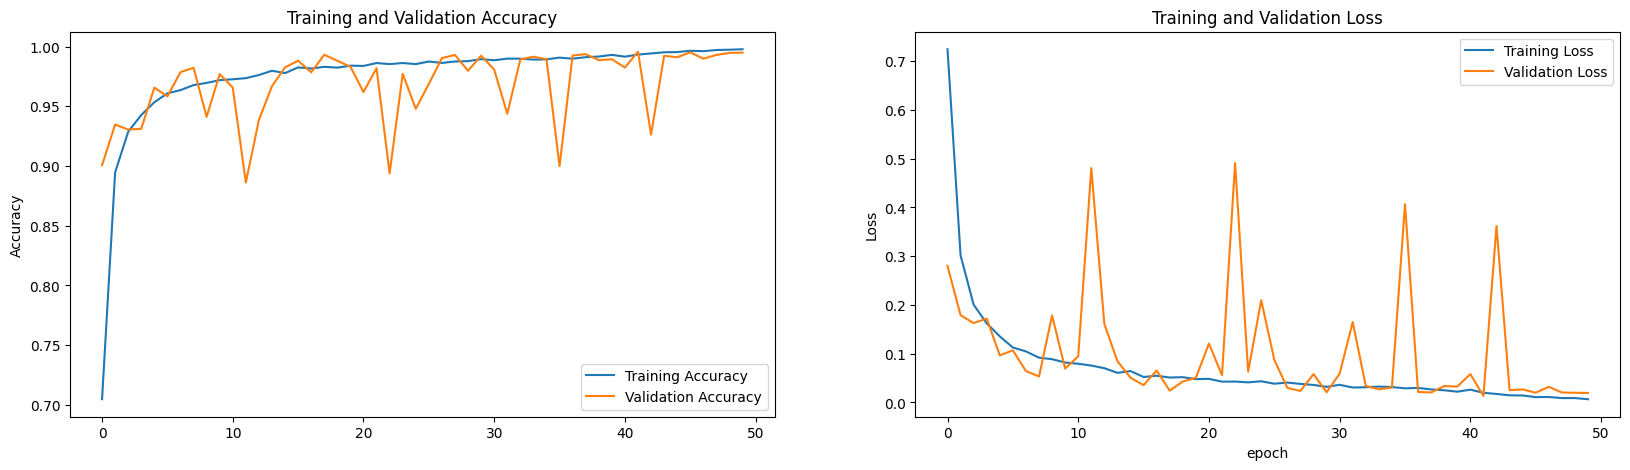

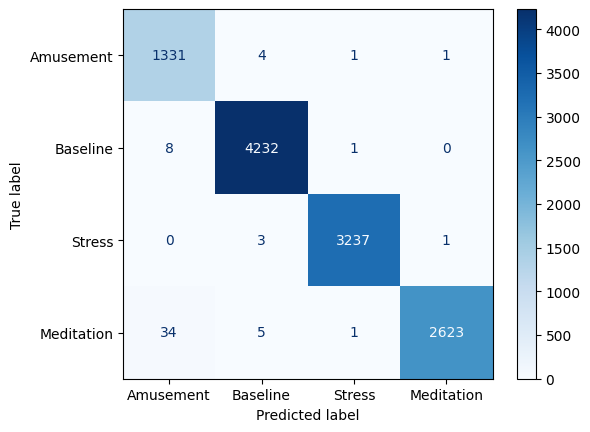

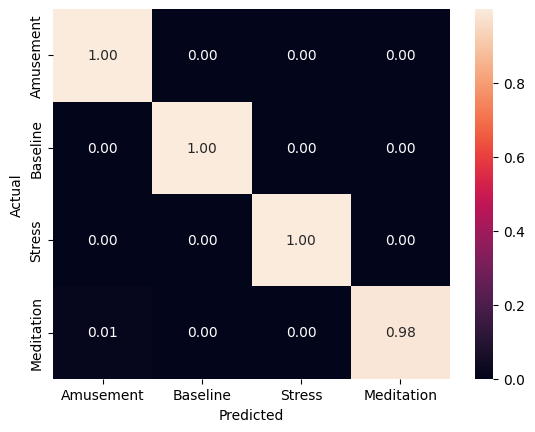

=========================================__Fold__4_______=================================
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_80 (Conv1D)             (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_90 (Conv1D)             (None, 2100, 8)      48          ['input_rhythm[0][0]']           
 

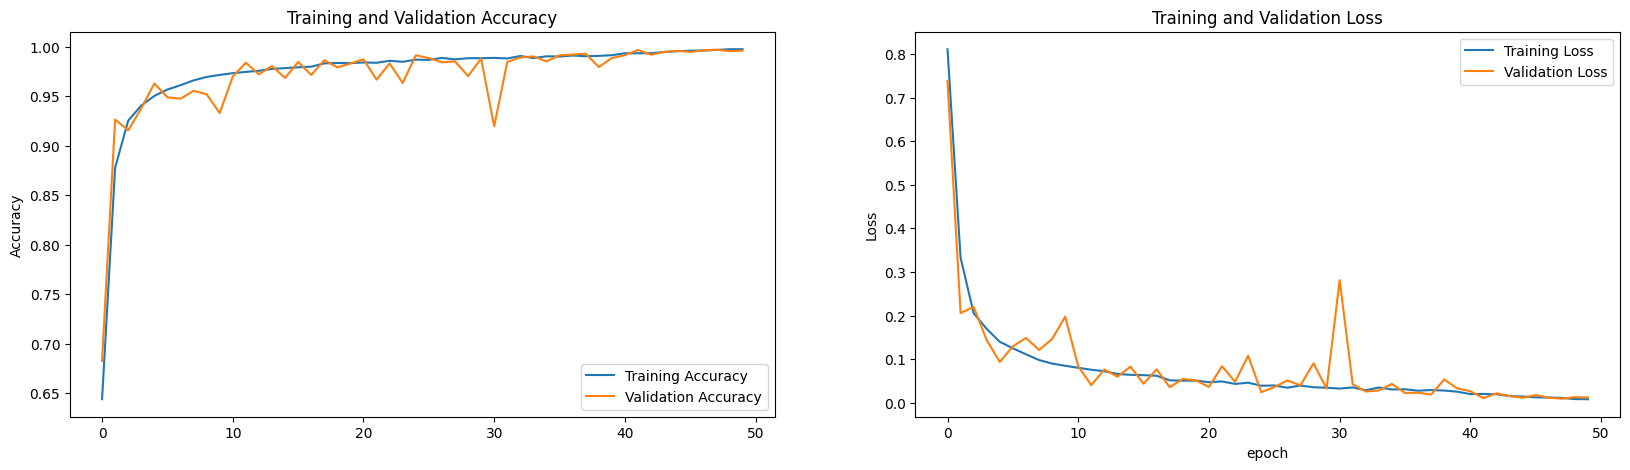

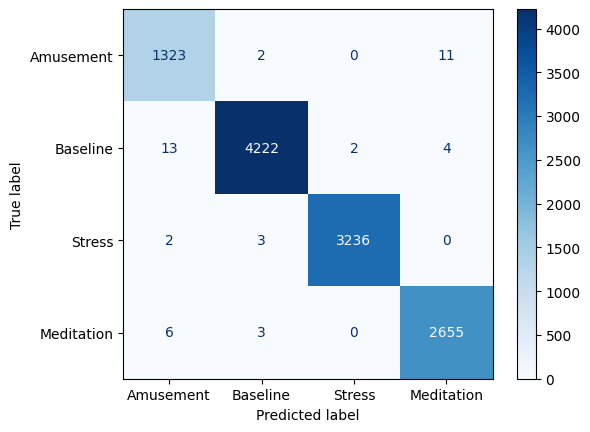

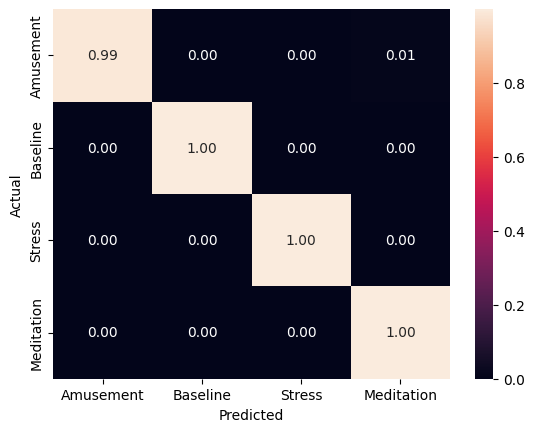

=========================================__Fold__5_______=================================
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beat (InputLayer)        [(None, 448, 1)]     0           []                               
                                                                                                  
 input_rhythm (InputLayer)      [(None, 2100, 1)]    0           []                               
                                                                                                  
 conv1d_100 (Conv1D)            (None, 448, 8)       48          ['input_beat[0][0]']             
                                                                                                  
 conv1d_110 (Conv1D)            (None, 2100, 8)      48          ['input_rhythm[0][0]']           
 

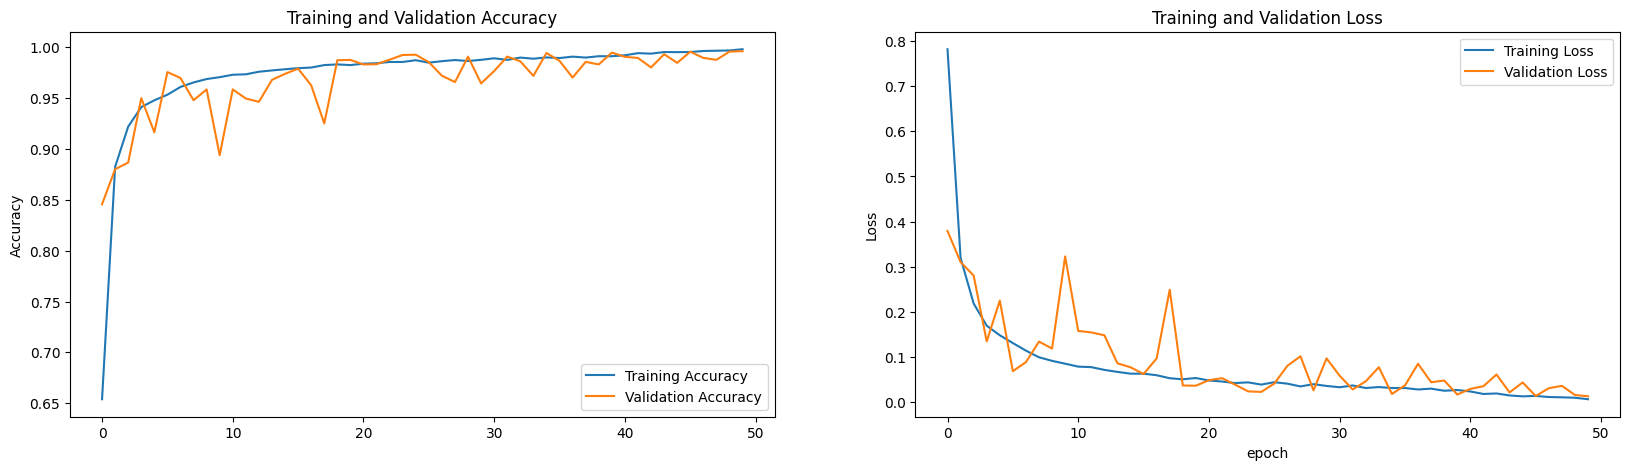

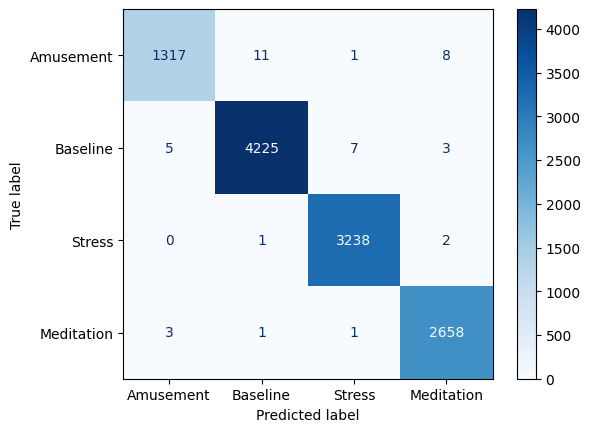

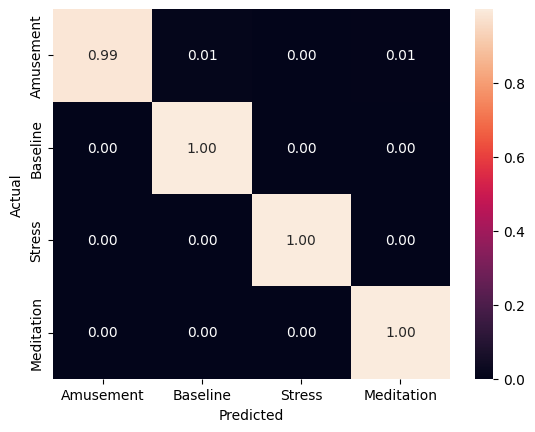

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=128)
number=1

for train_index, test_index in skf.split(train_beat, train_y):
    print('=========================================__Fold__'+str(number)+'_______=================================')
    X_train_b, X_test_b, X_train_r, X_test_r = train_beat[train_index], train_beat[test_index], train_rhythm[train_index], train_rhythm[test_index]
    Y_train, Y_test = train_y[train_index], train_y[test_index]

    y_train = to_categorical(Y_train)
    y_test = to_categorical(Y_test)    
    class_weight = cal_class_weight(train_y)

    
    fusion_model = WESAD_fusion_model_Add(X_train_b.shape[1], X_train_r.shape[1])
    callback_lr = tf.keras.callbacks.LearningRateScheduler(scheuler)
    fusion_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = fusion_model.fit([X_train_b, X_train_r], y_train, 
                        validation_data=([X_test_b, X_test_r], y_test), 
                        epochs=50, 
                        batch_size=32,
                        class_weight = class_weight,
                        callbacks=[callback_lr],
                       ) 

    
    scores = fusion_model.evaluate([X_test_b,X_test_r], y_test)
    Plot_lr_curve(history)
    pred = fusion_model.predict([X_test_b,X_test_r])
    Plot_confusion_matrix(y_test, pred, class_name)

    
    fusion_model.save(save_model_path + 'Add_Fusion_5_layer_3s_(0.0001)_Fold(8,2)_'  +str(number)+ '_(' + str(np.round(scores[1]*100,2)) + ').h5')
    number+=1
    
    

# 6 layer and 8 seoncd Fusion method 실험

# Average

In [77]:
from tensorflow.keras.layers import Average, maximum, Multiply, Add, dot


def WESAD_fusion_model(re_X_train_b, re_X_train_r):
    input_beat = Input(shape=(re_X_train_b,1), name = 'input_beat')
    input_rhythm = Input(shape=(re_X_train_r,1), name = 'input_rhythm')

    conv1_B = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(input_beat)
    conv2_B = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B)
    bn1_B = BatchNormalization()(conv2_B)
    act_B = Activation('relu')(bn1_B)
    max1_B = MaxPooling1D(2,2)(act_B)

    conv1_B_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B)
    conv2_B_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_1)
    bn1_B_1 = BatchNormalization()(conv2_B_1)
    act_B_1 = Activation('relu')(bn1_B_1)
    max1_B_1 = MaxPooling1D(2,2)(act_B_1)


    conv1_B_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_1)
    conv2_B_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_2)
    bn1_B_2 = BatchNormalization()(conv2_B_2)
    act_B_2 = Activation('relu')(bn1_B_2)
    max1_B_2 = MaxPooling1D(2,2)(act_B_2)

    conv1_B_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_2)
    conv2_B_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_3)
    bn1_B_3 = BatchNormalization()(conv2_B_3)
    act_B_3 = Activation('relu')(bn1_B_3)
    max1_B_3 = MaxPooling1D(2,2)(act_B_3)

    conv1_B_3 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_3)
    conv2_B_3 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_3)
    bn1_B_3 = BatchNormalization()(conv2_B_3)
    act_B_3 = Activation('relu')(bn1_B_3)
    max1_B_3 = MaxPooling1D(2,2)(act_B_3)

    GAP_B = GlobalAveragePooling1D()(max1_B_3)

    # Rhythm

    conv1_R = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(input_rhythm)
    conv2_R = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R)
    bn1_R = BatchNormalization()(conv2_R)
    act_R = Activation('relu')(bn1_R)
    max1_R = MaxPooling1D(2,2)(act_R)

    conv1_R_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R)
    conv2_R_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_1)
    bn1_R_1 = BatchNormalization()(conv2_R_1)
    act_R_1 = Activation('relu')(bn1_R_1)
    max1_R_1 = MaxPooling1D(2,2)(act_R_1)


    conv1_R_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_1)
    conv2_R_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_2)
    bn1_R_2 = BatchNormalization()(conv2_R_2)
    act_R_2 = Activation('relu')(bn1_R_2)
    max1_R_2 = MaxPooling1D(2,2)(act_R_2)


    conv1_R_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_2)
    conv2_R_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_3)
    bn1_R_3 = BatchNormalization()(conv2_R_3)
    act_R_3 = Activation('relu')(bn1_R_3)
    max1_R_3 = MaxPooling1D(2,2)(act_R_3)


    conv1_R_4 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_3)
    conv2_R_4 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_4)
    bn1_R_4 = BatchNormalization()(conv2_R_4)
    act_R_4 = Activation('relu')(bn1_R_4)
    max1_R_4 = MaxPooling1D(2,2)(act_R_4)

    conv1_R_5 = Conv1D(256, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_4)
    conv2_R_5 = Conv1D(256, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_5)
    bn1_R_5 = BatchNormalization()(conv2_R_5)
    act_R_5 = Activation('relu')(bn1_R_5)
    max1_R_5 = MaxPooling1D(2,2)(act_R_5)

    conv1_R_5 = Conv1D(128, 1, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_5)


    GAP_R = GlobalAveragePooling1D()(conv1_R_5)

    #fusion
    Average_layer = Average()([GAP_B, GAP_R])

    re_R = Reshape((1, Average_layer.shape[1]))(Average_layer)
    x_R_LSTM = LSTM(128,return_sequences=True)(re_R)
    x_R_LSTM2 = LSTM(64, return_sequences=True)(x_R_LSTM)
    fl_f = Flatten()(x_R_LSTM2)

    den1 = Dense(128, activation='relu')(fl_f)
    den2 = Dense(64, activation='relu')(den1)

    fusion_output = Dense(4, activation='softmax')(den2)

    fusion_model = Model(inputs=[input_beat, input_rhythm], outputs= fusion_output)
    fusion_model.summary()
    
    return fusion_model

In [8]:
window = sampling_rate * 8
train_beat, train_rhythm, train_y = load_data(person, 'beat', 'rhythm', window)

================== person = S2 ===========================
================== person = S3 ===========================
================== person = S4 ===========================
================== person = S5 ===========================
================== person = S6 ===========================
================== person = S7 ===========================
================== person = S8 ===========================
================== person = S9 ===========================
================== person = S10 ===========================
================== person = S11 ===========================
================== person = S13 ===========================
================== person = S14 ===========================
================== person = S15 ===========================
================== person = S16 ===========================
================== person = S17 ===========================
================== person = S2 ===========================
================== person = S3 ==================

=========================================__Fold__1_______=================================
Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_852 (Conv1D)            (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_853 (Conv1D)            (None, 5600, 8)      328         ['conv1d_852[0][0]']             
                                                                                                  
 batch_normalization_426 (Batch  (None, 5600, 8)     32          ['conv1d_853[0][0]']             


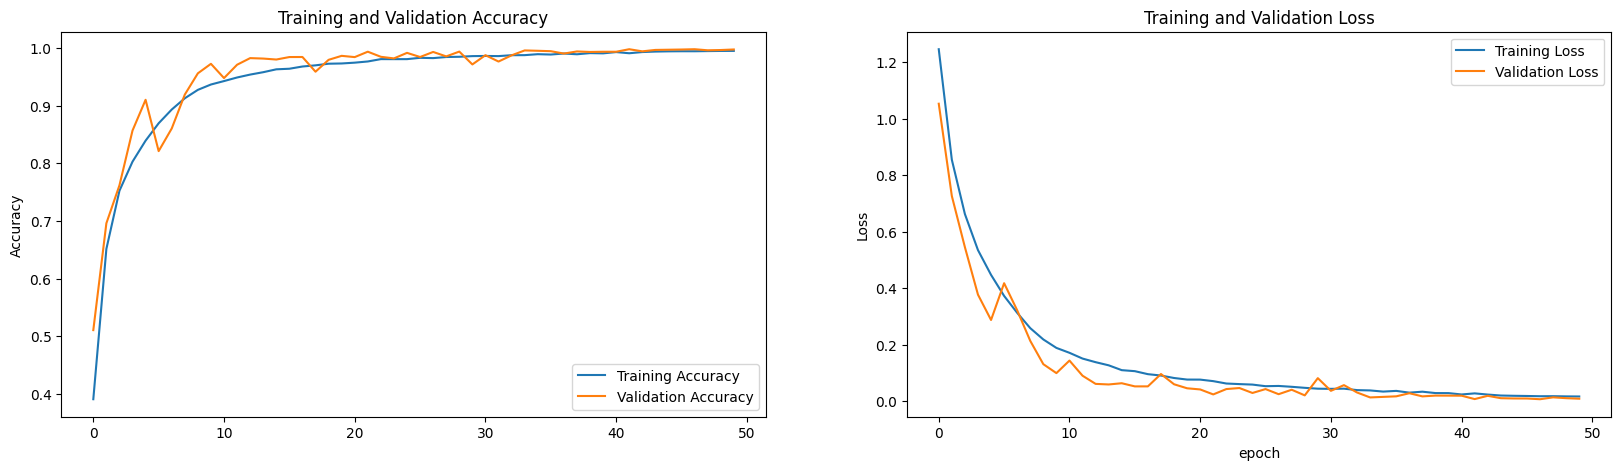

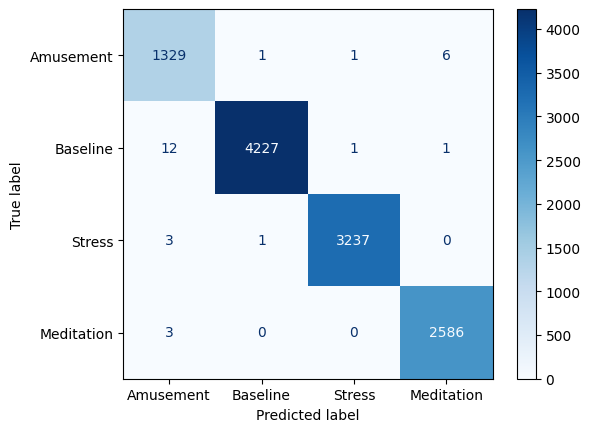

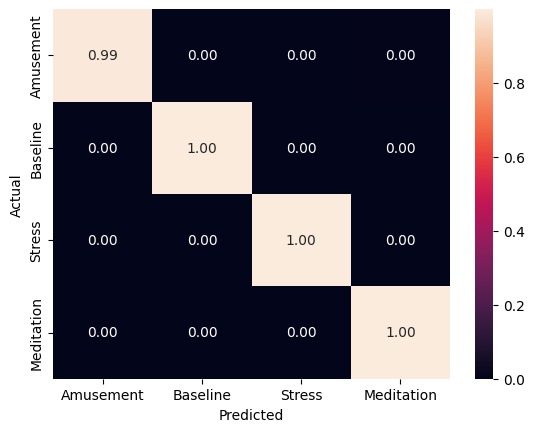

=========================================__Fold__2_______=================================
Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_875 (Conv1D)            (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_876 (Conv1D)            (None, 5600, 8)      328         ['conv1d_875[0][0]']             
                                                                                                  
 batch_normalization_437 (Batch  (None, 5600, 8)     32          ['conv1d_876[0][0]']             


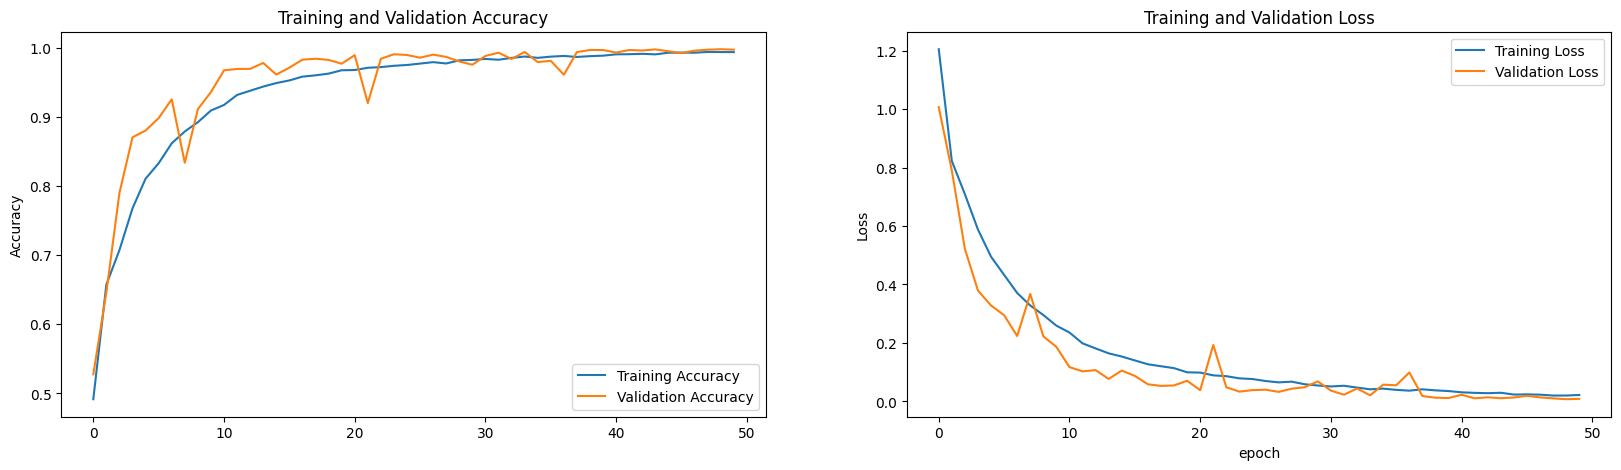

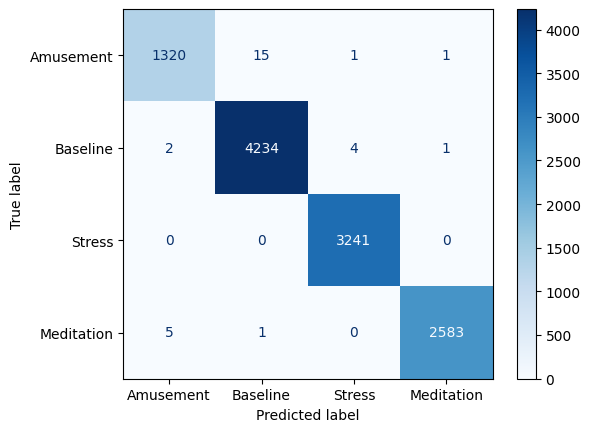

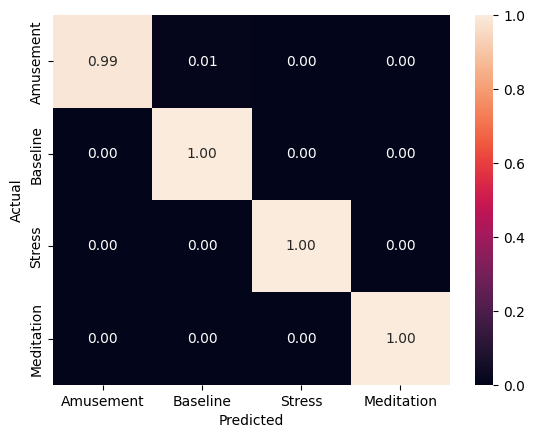

=========================================__Fold__3_______=================================
Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_898 (Conv1D)            (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_899 (Conv1D)            (None, 5600, 8)      328         ['conv1d_898[0][0]']             
                                                                                                  
 batch_normalization_448 (Batch  (None, 5600, 8)     32          ['conv1d_899[0][0]']             


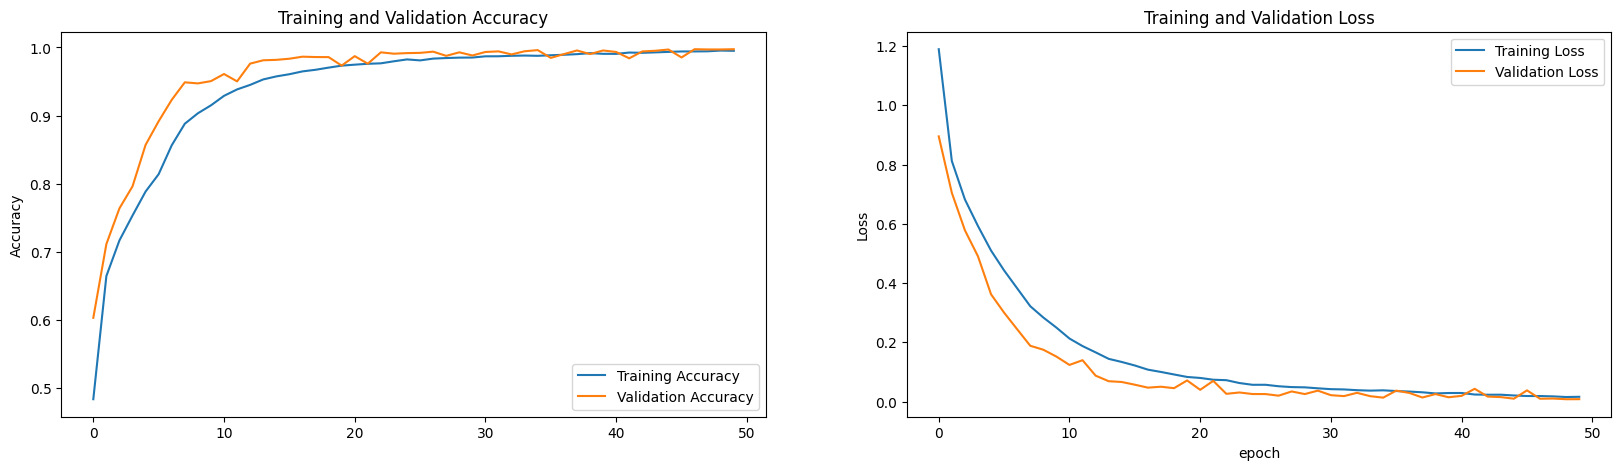

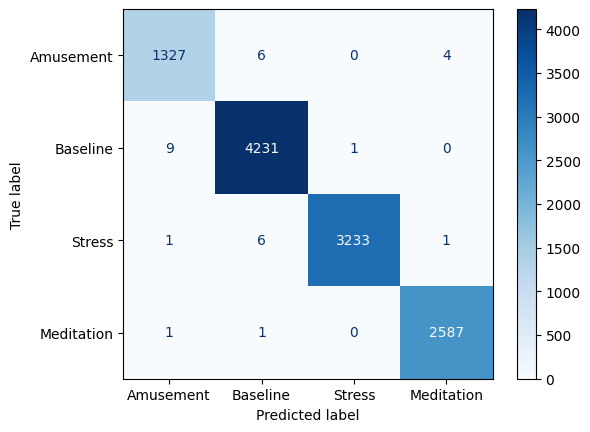

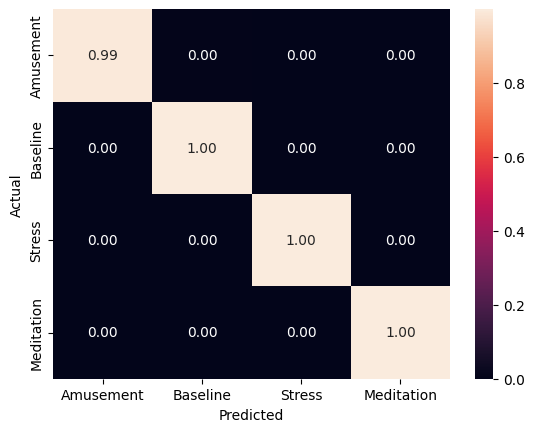

=========================================__Fold__4_______=================================
Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_921 (Conv1D)            (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_922 (Conv1D)            (None, 5600, 8)      328         ['conv1d_921[0][0]']             
                                                                                                  
 batch_normalization_459 (Batch  (None, 5600, 8)     32          ['conv1d_922[0][0]']             


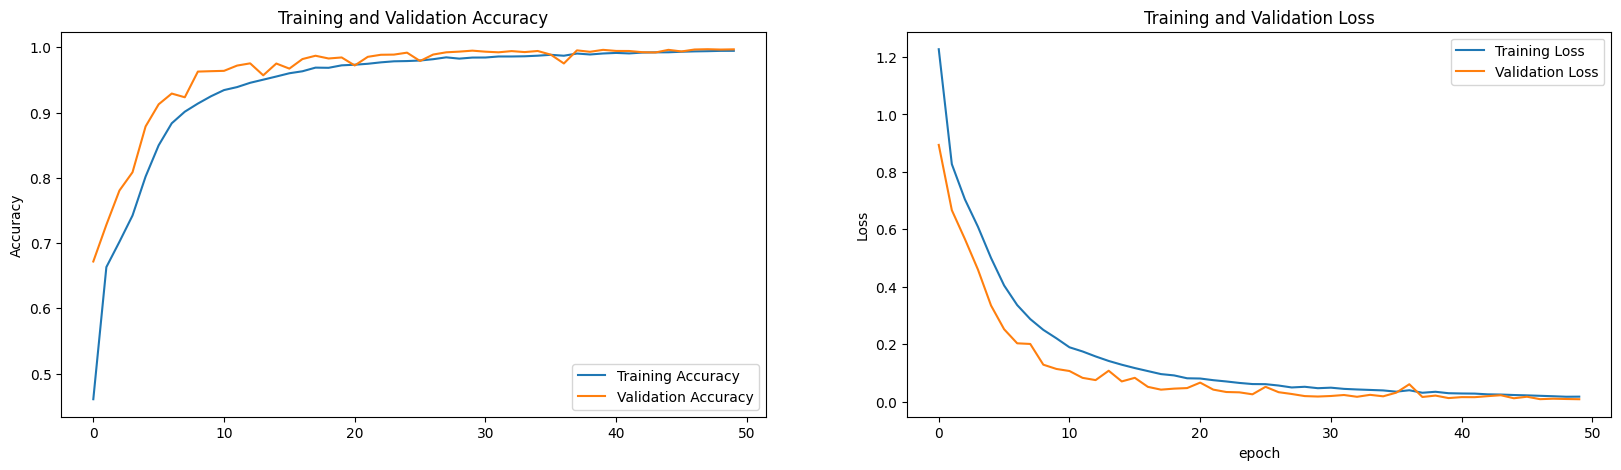

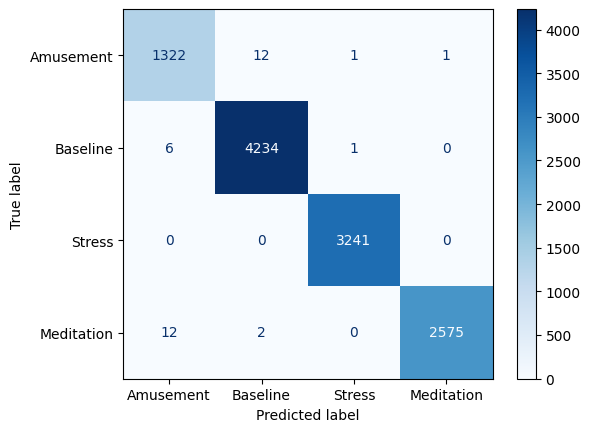

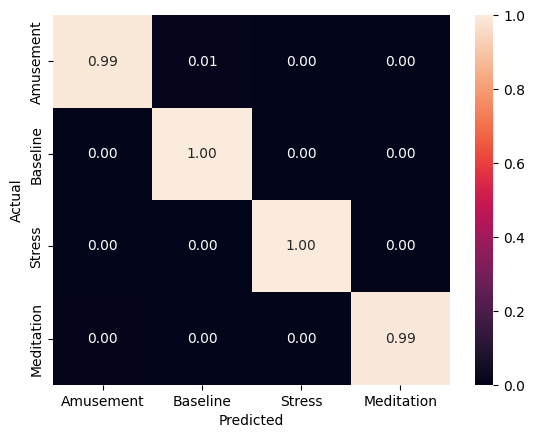

=========================================__Fold__5_______=================================
Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_944 (Conv1D)            (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_945 (Conv1D)            (None, 5600, 8)      328         ['conv1d_944[0][0]']             
                                                                                                  
 batch_normalization_470 (Batch  (None, 5600, 8)     32          ['conv1d_945[0][0]']             


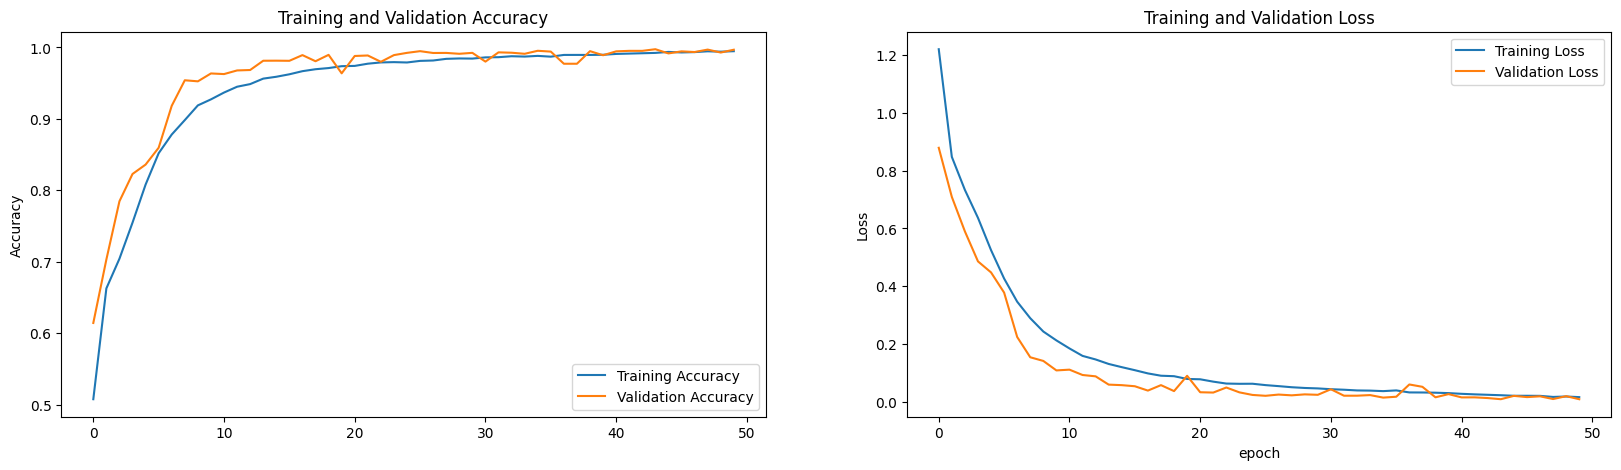

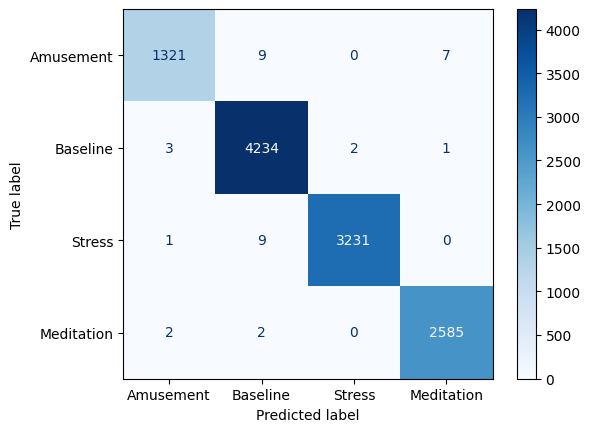

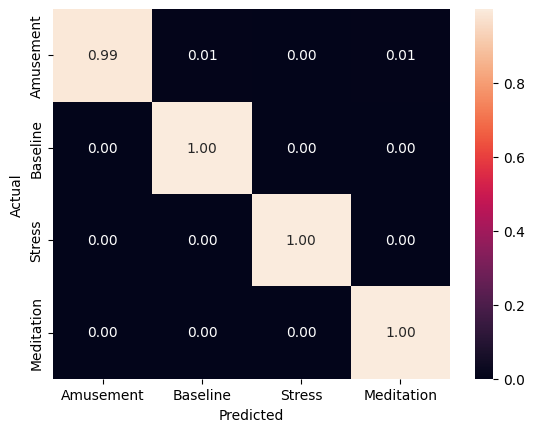

In [79]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=128)
number=1
save_model_path = "D:/Journal/WESAD_Model/Fusion_Method/"

for train_index, test_index in skf.split(train_beat, train_y):
    print('=========================================__Fold__'+str(number)+'_______=================================')
    X_train_b, X_test_b, X_train_r, X_test_r = train_beat[train_index], train_beat[test_index], train_rhythm[train_index], train_rhythm[test_index]
    Y_train, Y_test = train_y[train_index], train_y[test_index]

    y_train = to_categorical(Y_train)
    y_test = to_categorical(Y_test)    
    class_weight = cal_class_weight(train_y)

    
    fusion_model = WESAD_fusion_model(X_train_b.shape[1], X_train_r.shape[1])
    callback_lr = tf.keras.callbacks.LearningRateScheduler(scheuler)
    fusion_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = fusion_model.fit([X_train_b, X_train_r], y_train, 
                        validation_data=([X_test_b, X_test_r], y_test), 
                        epochs=50, 
                        batch_size=32,
                        class_weight = class_weight,
                        callbacks=[callback_lr],
                       ) 

    
    scores = fusion_model.evaluate([X_test_b,X_test_r], y_test)
    Plot_lr_curve(history)
    pred = fusion_model.predict([X_test_b,X_test_r])
    Plot_confusion_matrix(y_test, pred, class_name)

    
    fusion_model.save(save_model_path + '2_Average_Fusion_6_layer_8s_Fold(8,2)_'  +str(number)+ '_(' + str(np.round(scores[1]*100,2)) + ').h5')
    number+=1
    
    

# Maximum

In [10]:
from tensorflow.keras.layers import Average, maximum, Multiply, Add, dot


def WESAD_fusion_model_Maximum(re_X_train_b, re_X_train_r):
    input_beat = Input(shape=(re_X_train_b,1), name = 'input_beat')
    input_rhythm = Input(shape=(re_X_train_r,1), name = 'input_rhythm')

    conv1_B = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(input_beat)
    conv2_B = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B)
    bn1_B = BatchNormalization()(conv2_B)
    act_B = Activation('relu')(bn1_B)
    max1_B = MaxPooling1D(2,2)(act_B)

    conv1_B_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B)
    conv2_B_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_1)
    bn1_B_1 = BatchNormalization()(conv2_B_1)
    act_B_1 = Activation('relu')(bn1_B_1)
    max1_B_1 = MaxPooling1D(2,2)(act_B_1)


    conv1_B_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_1)
    conv2_B_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_2)
    bn1_B_2 = BatchNormalization()(conv2_B_2)
    act_B_2 = Activation('relu')(bn1_B_2)
    max1_B_2 = MaxPooling1D(2,2)(act_B_2)

    conv1_B_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_2)
    conv2_B_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_3)
    bn1_B_3 = BatchNormalization()(conv2_B_3)
    act_B_3 = Activation('relu')(bn1_B_3)
    max1_B_3 = MaxPooling1D(2,2)(act_B_3)

    conv1_B_3 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_3)
    conv2_B_3 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_3)
    bn1_B_3 = BatchNormalization()(conv2_B_3)
    act_B_3 = Activation('relu')(bn1_B_3)
    max1_B_3 = MaxPooling1D(2,2)(act_B_3)

    GAP_B = GlobalAveragePooling1D()(max1_B_3)

    # Rhythm

    conv1_R = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(input_rhythm)
    conv2_R = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R)
    bn1_R = BatchNormalization()(conv2_R)
    act_R = Activation('relu')(bn1_R)
    max1_R = MaxPooling1D(2,2)(act_R)

    conv1_R_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R)
    conv2_R_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_1)
    bn1_R_1 = BatchNormalization()(conv2_R_1)
    act_R_1 = Activation('relu')(bn1_R_1)
    max1_R_1 = MaxPooling1D(2,2)(act_R_1)


    conv1_R_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_1)
    conv2_R_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_2)
    bn1_R_2 = BatchNormalization()(conv2_R_2)
    act_R_2 = Activation('relu')(bn1_R_2)
    max1_R_2 = MaxPooling1D(2,2)(act_R_2)


    conv1_R_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_2)
    conv2_R_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_3)
    bn1_R_3 = BatchNormalization()(conv2_R_3)
    act_R_3 = Activation('relu')(bn1_R_3)
    max1_R_3 = MaxPooling1D(2,2)(act_R_3)


    conv1_R_4 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_3)
    conv2_R_4 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_4)
    bn1_R_4 = BatchNormalization()(conv2_R_4)
    act_R_4 = Activation('relu')(bn1_R_4)
    max1_R_4 = MaxPooling1D(2,2)(act_R_4)

    conv1_R_5 = Conv1D(256, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_4)
    conv2_R_5 = Conv1D(256, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_5)
    bn1_R_5 = BatchNormalization()(conv2_R_5)
    act_R_5 = Activation('relu')(bn1_R_5)
    max1_R_5 = MaxPooling1D(2,2)(act_R_5)

    conv1_R_5 = Conv1D(128, 1, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_5)

    GAP_R = GlobalAveragePooling1D()(conv1_R_5)

    # Fusion
    maximum_layer = maximum([GAP_B, GAP_R])

    re_R = Reshape((1, maximum_layer.shape[1]))(maximum_layer)
    x_R_LSTM = LSTM(128,return_sequences=True)(re_R)
    x_R_LSTM2 = LSTM(64, return_sequences=True)(x_R_LSTM)
    fl_f = Flatten()(x_R_LSTM2)

    den1 = Dense(128, activation='relu')(fl_f)
    den2 = Dense(64, activation='relu')(den1)

    fusion_output = Dense(4, activation='softmax')(den2)

    fusion_model = Model(inputs=[input_beat, input_rhythm], outputs= fusion_output)
    fusion_model.summary()
    
    return fusion_model

In [ ]:
save_model_path = "D:/Journal/WESAD_Model/Fusion_Method/"

=========================================__Fold__1_______=================================
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_79 (Conv1D)             (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_80 (Conv1D)             (None, 5600, 8)      328         ['conv1d_79[0][0]']              
                                                                                                  
 batch_normalization_38 (BatchN  (None, 5600, 8)     32          ['conv1d_80[0][0]']              
 

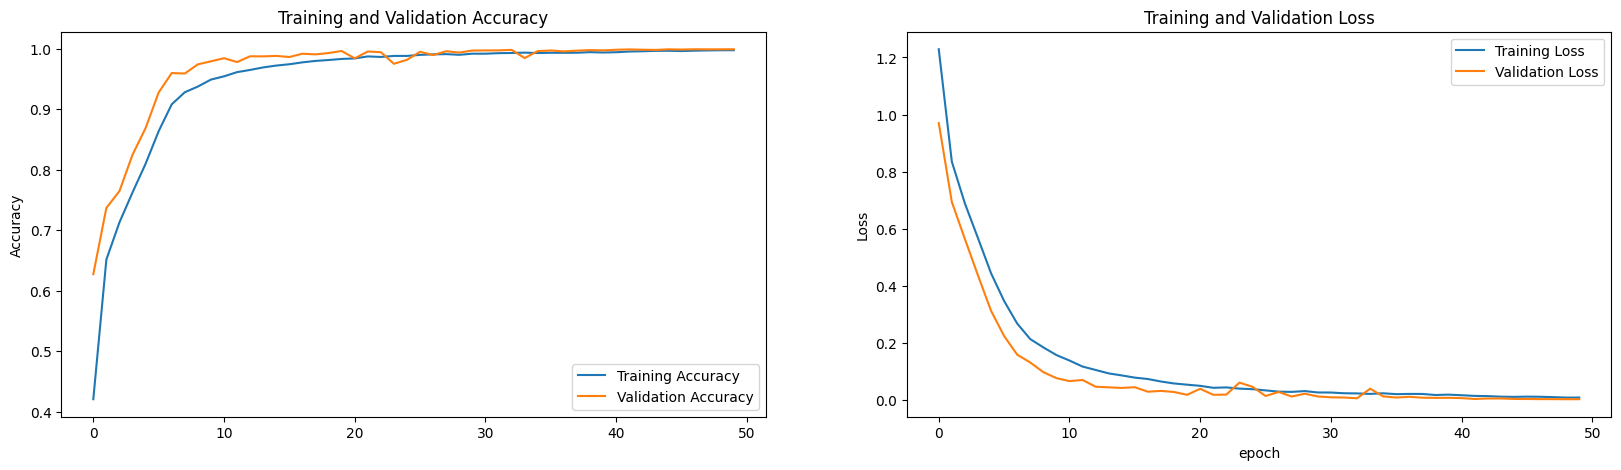

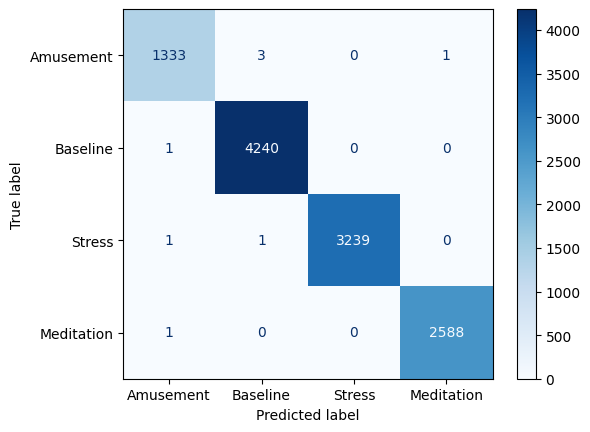

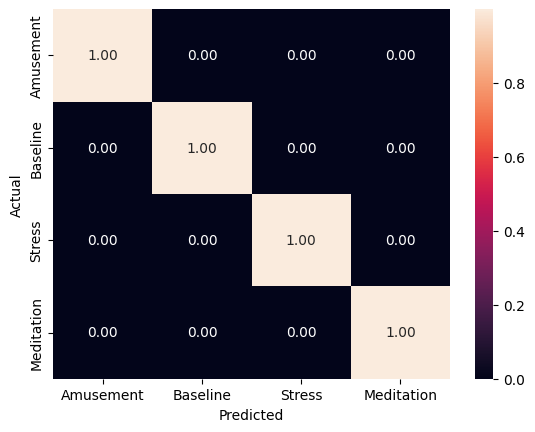

=========================================__Fold__2_______=================================
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_102 (Conv1D)            (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_103 (Conv1D)            (None, 5600, 8)      328         ['conv1d_102[0][0]']             
                                                                                                  
 batch_normalization_49 (BatchN  (None, 5600, 8)     32          ['conv1d_103[0][0]']             
 

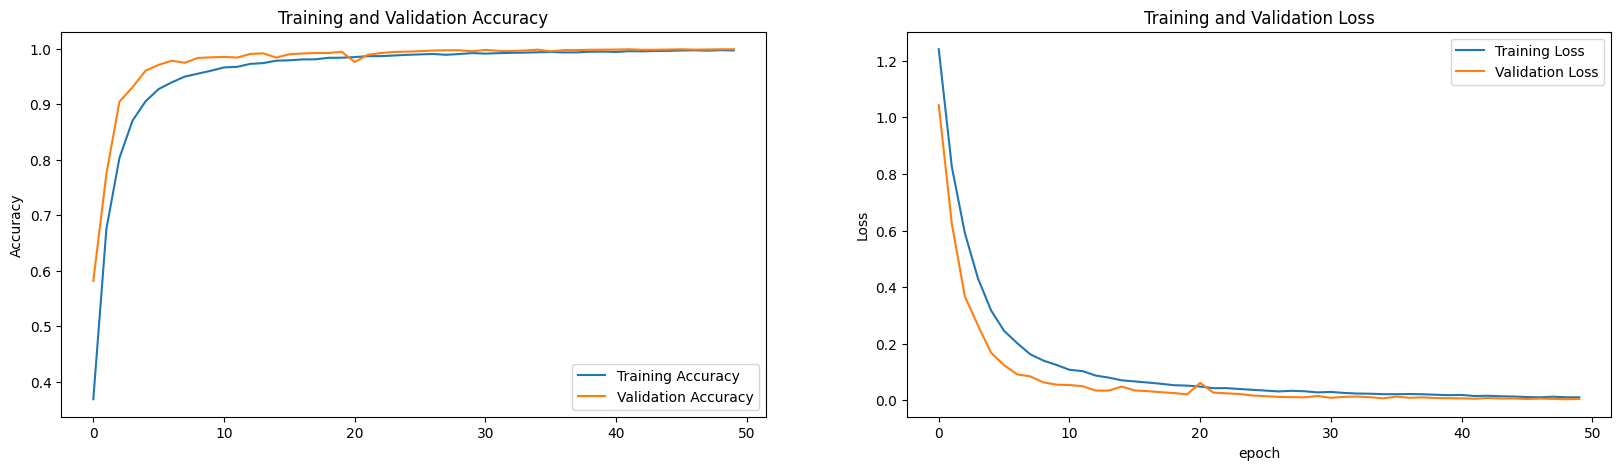

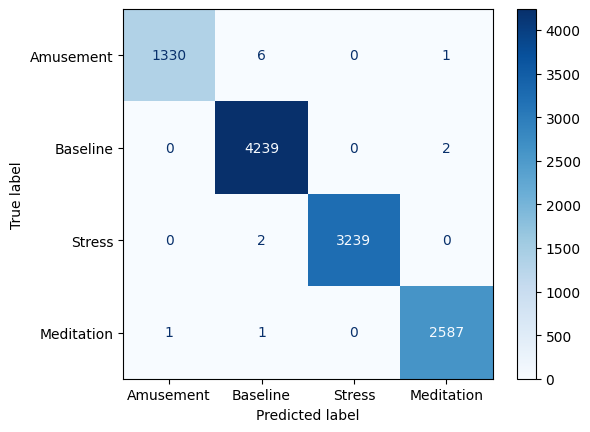

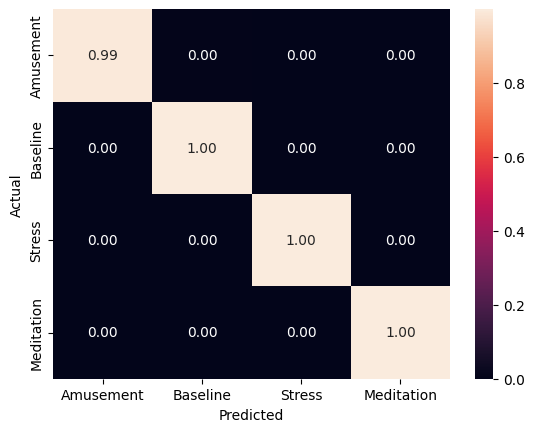

=========================================__Fold__3_______=================================
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_125 (Conv1D)            (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_126 (Conv1D)            (None, 5600, 8)      328         ['conv1d_125[0][0]']             
                                                                                                  
 batch_normalization_60 (BatchN  (None, 5600, 8)     32          ['conv1d_126[0][0]']             
 

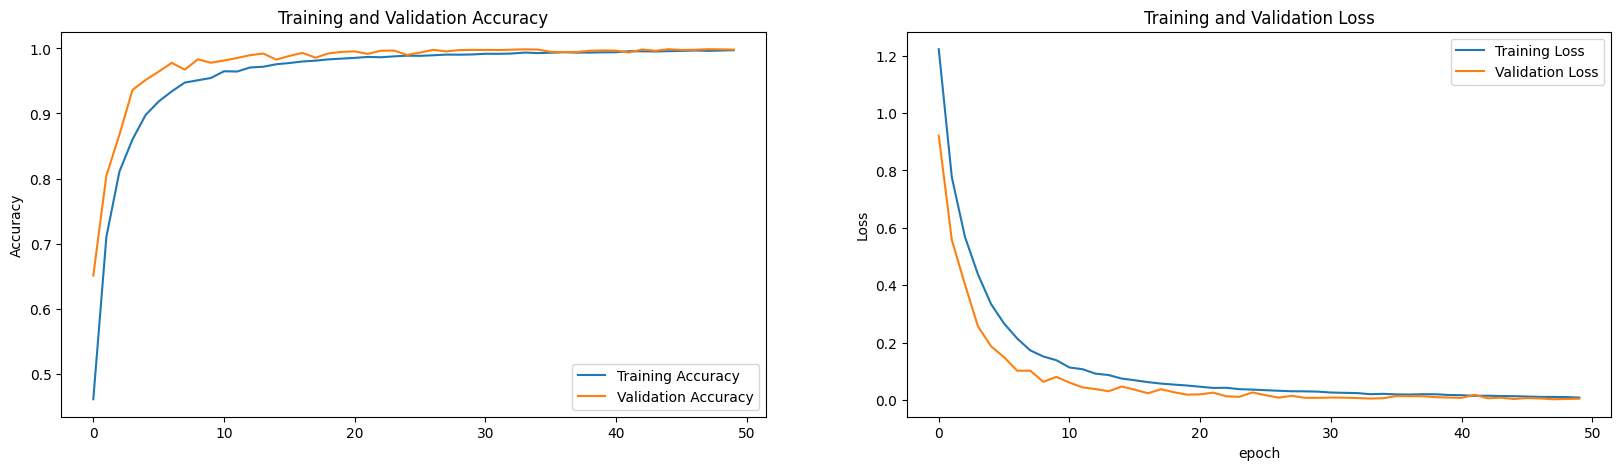

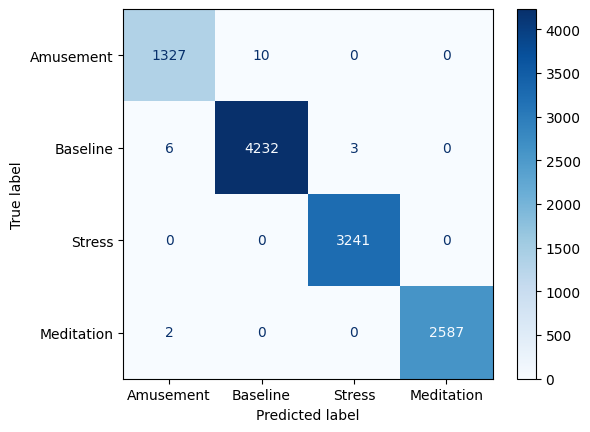

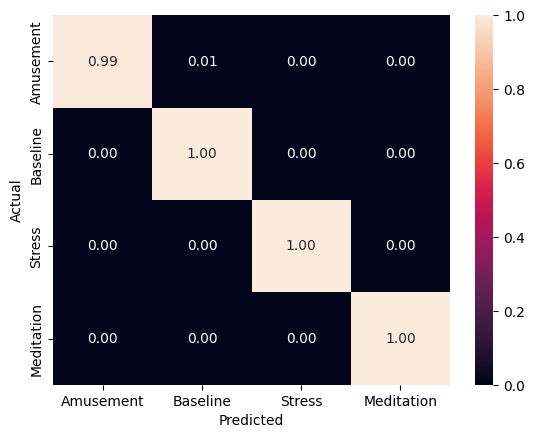

=========================================__Fold__4_______=================================
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_148 (Conv1D)            (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_149 (Conv1D)            (None, 5600, 8)      328         ['conv1d_148[0][0]']             
                                                                                                  
 batch_normalization_71 (BatchN  (None, 5600, 8)     32          ['conv1d_149[0][0]']             
 

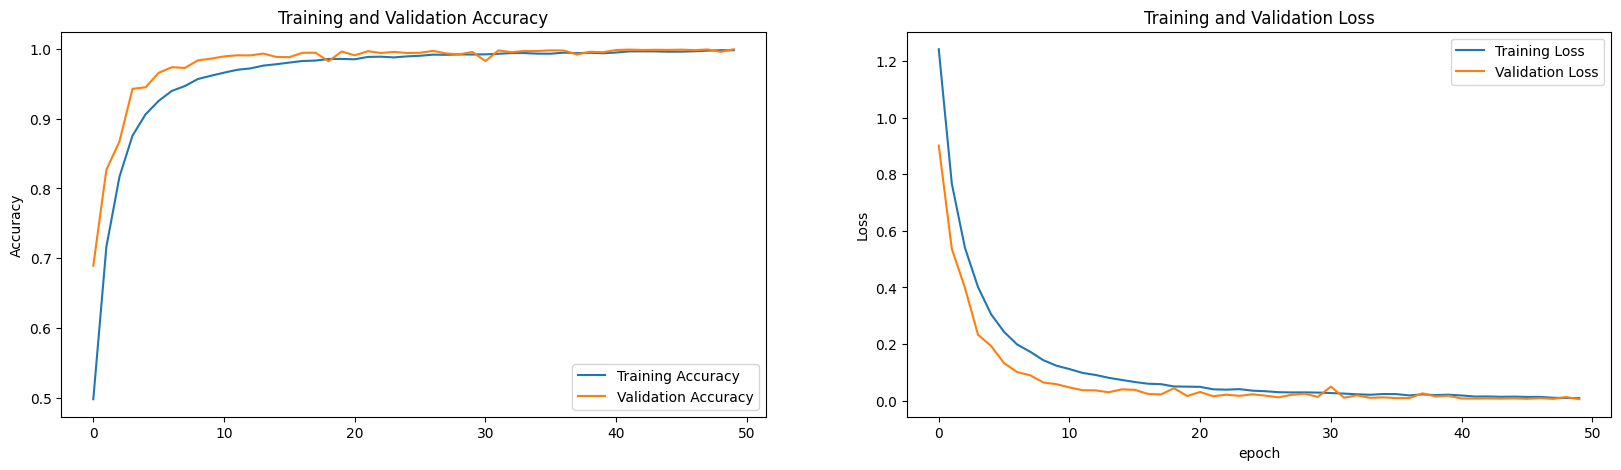

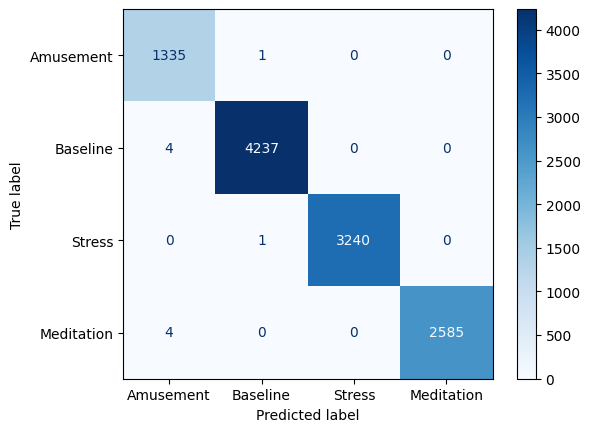

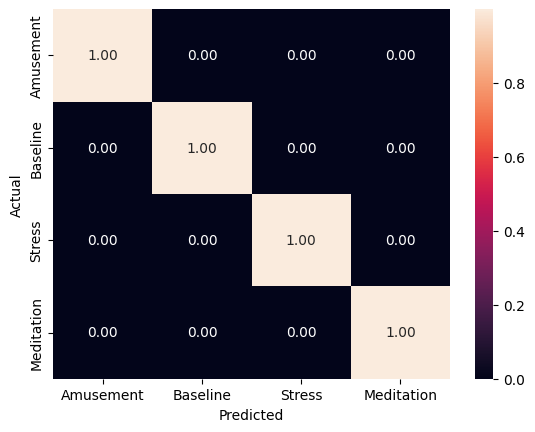

=========================================__Fold__5_______=================================
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_171 (Conv1D)            (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_172 (Conv1D)            (None, 5600, 8)      328         ['conv1d_171[0][0]']             
                                                                                                  
 batch_normalization_82 (BatchN  (None, 5600, 8)     32          ['conv1d_172[0][0]']             
 

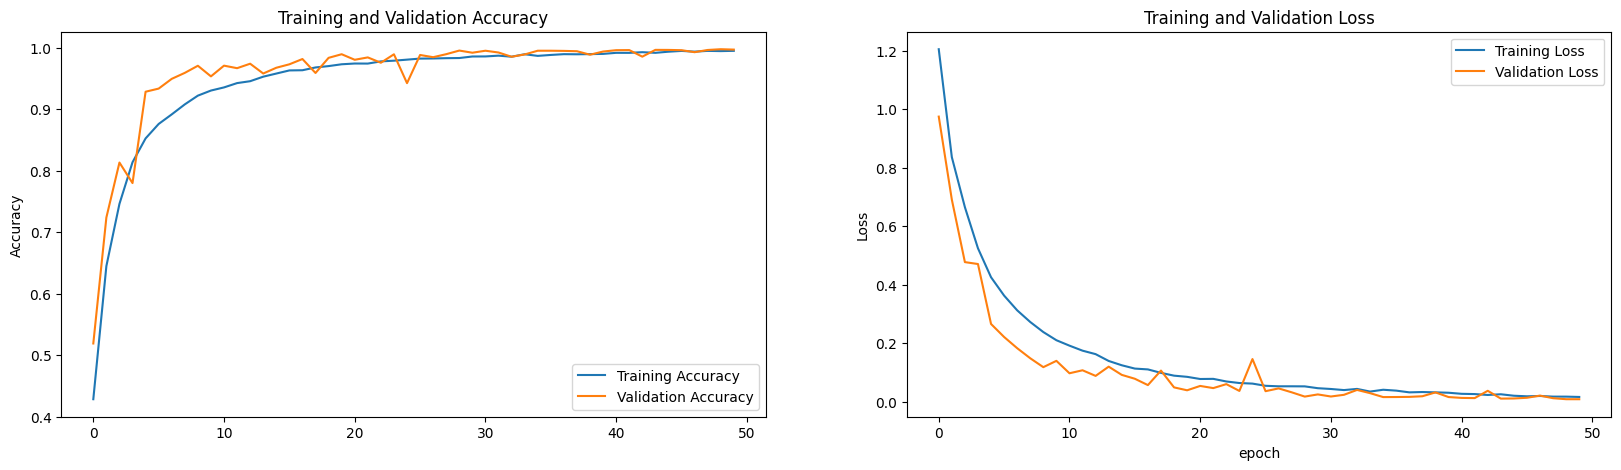

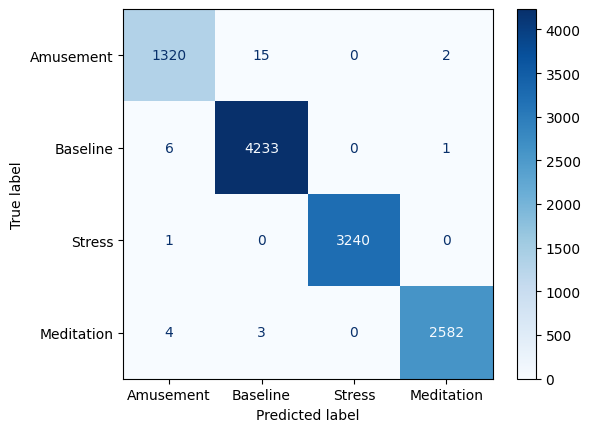

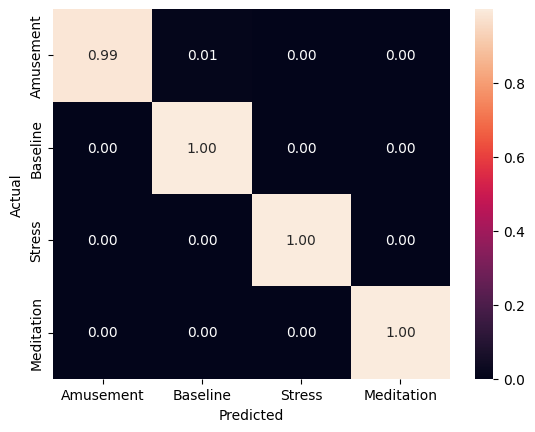

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=128)
number=1

for train_index, test_index in skf.split(train_beat, train_y):
    print('=========================================__Fold__'+str(number)+'_______=================================')
    X_train_b, X_test_b, X_train_r, X_test_r = train_beat[train_index], train_beat[test_index], train_rhythm[train_index], train_rhythm[test_index]
    Y_train, Y_test = train_y[train_index], train_y[test_index]

    y_train = to_categorical(Y_train)
    y_test = to_categorical(Y_test)    
    class_weight = cal_class_weight(train_y)

    
    fusion_model = WESAD_fusion_model_Maximum(X_train_b.shape[1], X_train_r.shape[1])
    callback_lr = tf.keras.callbacks.LearningRateScheduler(scheuler)
    fusion_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = fusion_model.fit([X_train_b, X_train_r], y_train, 
                        validation_data=([X_test_b, X_test_r], y_test), 
                        epochs=50, 
                        batch_size=32,
                        class_weight = class_weight,
                        callbacks=[callback_lr],
                       ) 

    
    scores = fusion_model.evaluate([X_test_b,X_test_r], y_test)
    Plot_lr_curve(history)
    pred = fusion_model.predict([X_test_b,X_test_r])
    Plot_confusion_matrix(y_test, pred, class_name)

    
    fusion_model.save(save_model_path + '2_Maximum_Fusion_6_layer_8s_Fold(8,2)_'  +str(number)+ '_(' + str(np.round(scores[1]*100,2)) + ').h5')
    number+=1
    
    

# Multipy

In [17]:
from tensorflow.keras.layers import Average, maximum, Multiply, Add, dot


def WESAD_fusion_model_Multimply(re_X_train_b, re_X_train_r):
    input_beat = Input(shape=(re_X_train_b,1), name = 'input_beat')
    input_rhythm = Input(shape=(re_X_train_r,1), name = 'input_rhythm')

    conv1_B = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(input_beat)
    conv2_B = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B)
    bn1_B = BatchNormalization()(conv2_B)
    act_B = Activation('relu')(bn1_B)
    max1_B = MaxPooling1D(2,2)(act_B)

    conv1_B_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B)
    conv2_B_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_1)
    bn1_B_1 = BatchNormalization()(conv2_B_1)
    act_B_1 = Activation('relu')(bn1_B_1)
    max1_B_1 = MaxPooling1D(2,2)(act_B_1)


    conv1_B_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_1)
    conv2_B_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_2)
    bn1_B_2 = BatchNormalization()(conv2_B_2)
    act_B_2 = Activation('relu')(bn1_B_2)
    max1_B_2 = MaxPooling1D(2,2)(act_B_2)

    conv1_B_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_2)
    conv2_B_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_3)
    bn1_B_3 = BatchNormalization()(conv2_B_3)
    act_B_3 = Activation('relu')(bn1_B_3)
    max1_B_3 = MaxPooling1D(2,2)(act_B_3)

    conv1_B_3 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_3)
    conv2_B_3 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_3)
    bn1_B_3 = BatchNormalization()(conv2_B_3)
    act_B_3 = Activation('relu')(bn1_B_3)
    max1_B_3 = MaxPooling1D(2,2)(act_B_3)

    GAP_B = GlobalAveragePooling1D()(max1_B_3)

    # Rhythm

    conv1_R = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(input_rhythm)
    conv2_R = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R)
    bn1_R = BatchNormalization()(conv2_R)
    act_R = Activation('relu')(bn1_R)
    max1_R = MaxPooling1D(2,2)(act_R)

    conv1_R_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R)
    conv2_R_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_1)
    bn1_R_1 = BatchNormalization()(conv2_R_1)
    act_R_1 = Activation('relu')(bn1_R_1)
    max1_R_1 = MaxPooling1D(2,2)(act_R_1)


    conv1_R_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_1)
    conv2_R_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_2)
    bn1_R_2 = BatchNormalization()(conv2_R_2)
    act_R_2 = Activation('relu')(bn1_R_2)
    max1_R_2 = MaxPooling1D(2,2)(act_R_2)


    conv1_R_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_2)
    conv2_R_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_3)
    bn1_R_3 = BatchNormalization()(conv2_R_3)
    act_R_3 = Activation('relu')(bn1_R_3)
    max1_R_3 = MaxPooling1D(2,2)(act_R_3)


    conv1_R_4 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_3)
    conv2_R_4 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_4)
    bn1_R_4 = BatchNormalization()(conv2_R_4)
    act_R_4 = Activation('relu')(bn1_R_4)
    max1_R_4 = MaxPooling1D(2,2)(act_R_4)

    conv1_R_5 = Conv1D(256, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_4)
    conv2_R_5 = Conv1D(256, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_5)
    bn1_R_5 = BatchNormalization()(conv2_R_5)
    act_R_5 = Activation('relu')(bn1_R_5)
    max1_R_5 = MaxPooling1D(2,2)(act_R_5)

    conv1_R_5 = Conv1D(128, 1, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_5)


    GAP_R = GlobalAveragePooling1D()(conv1_R_5)

    # Fusion
    multiply_layer = Multiply()([GAP_B, GAP_R])

    re_R = Reshape((1, multiply_layer.shape[1]))(multiply_layer)
    x_R_LSTM = LSTM(128,return_sequences=True)(re_R)
    x_R_LSTM2 = LSTM(64, return_sequences=True)(x_R_LSTM)
    fl_f = Flatten()(x_R_LSTM2)

    den1 = Dense(128, activation='relu')(fl_f)
    den2 = Dense(64, activation='relu')(den1)

    fusion_output = Dense(4, activation='softmax')(den2)

    fusion_model = Model(inputs=[input_beat, input_rhythm], outputs= fusion_output)
    fusion_model.summary()
    
    return fusion_model

=========================================__Fold__1_______=================================
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_217 (Conv1D)            (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_218 (Conv1D)            (None, 5600, 8)      328         ['conv1d_217[0][0]']             
                                                                                                  
 batch_normalization_104 (Batch  (None, 5600, 8)     32          ['conv1d_218[0][0]']             
 

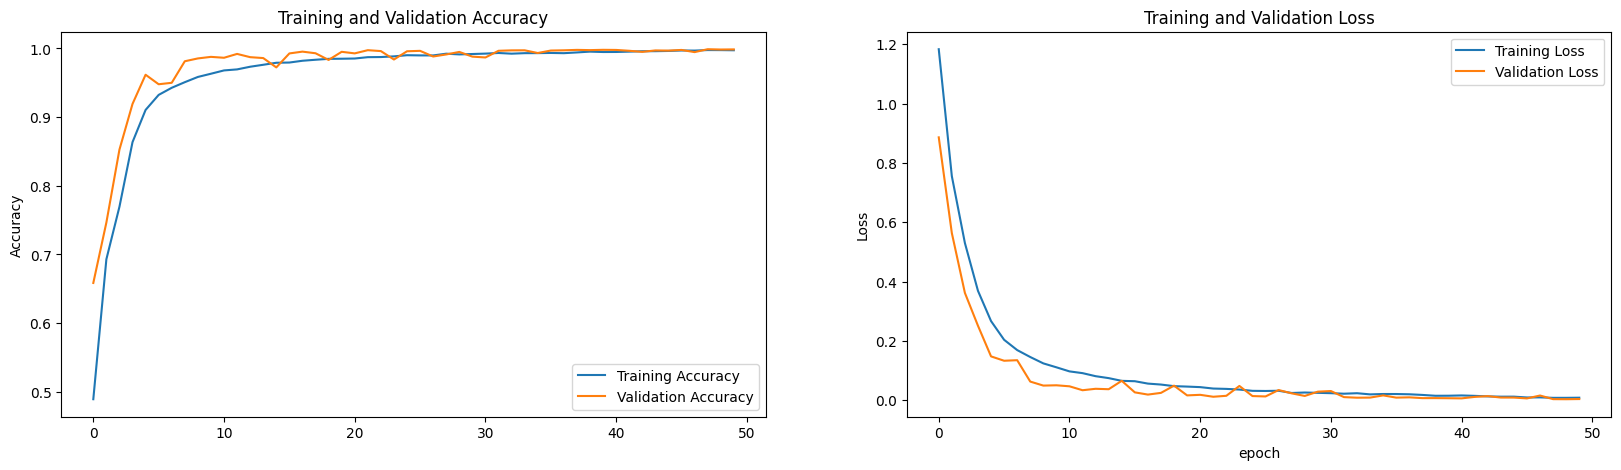

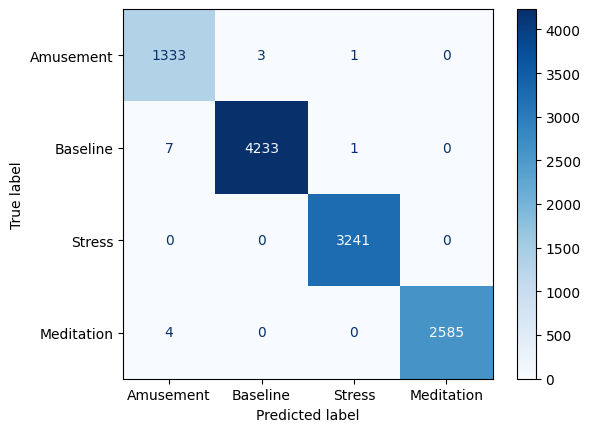

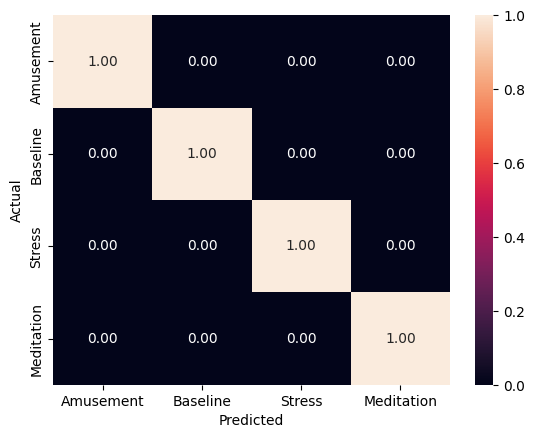

=========================================__Fold__2_______=================================
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_240 (Conv1D)            (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_241 (Conv1D)            (None, 5600, 8)      328         ['conv1d_240[0][0]']             
                                                                                                  
 batch_normalization_115 (Batch  (None, 5600, 8)     32          ['conv1d_241[0][0]']             


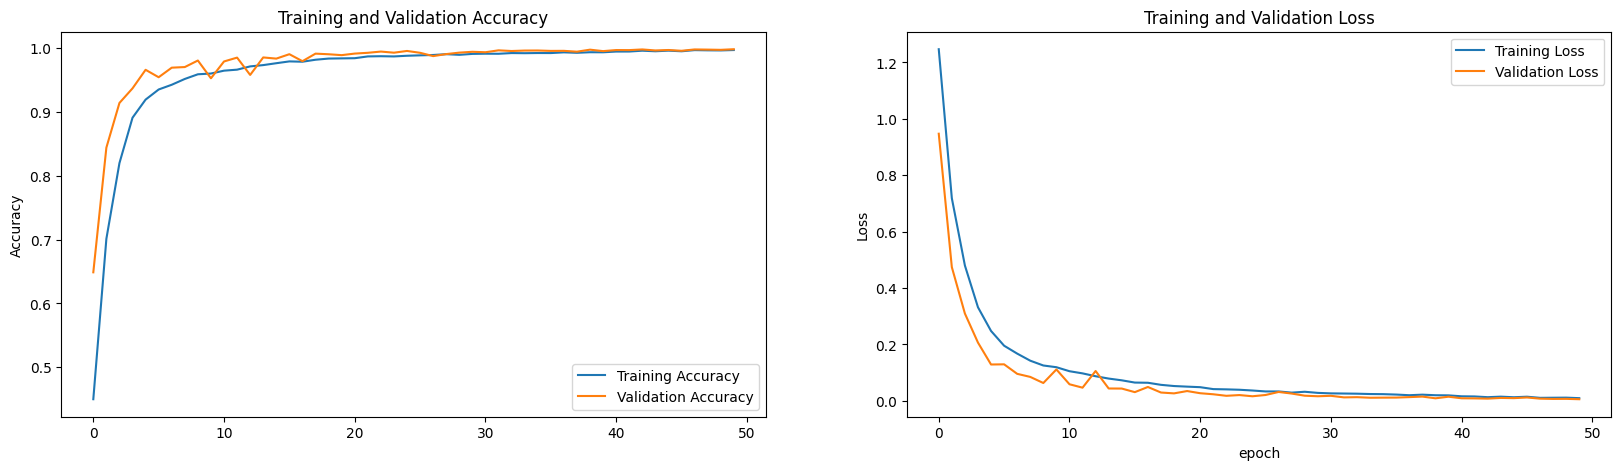

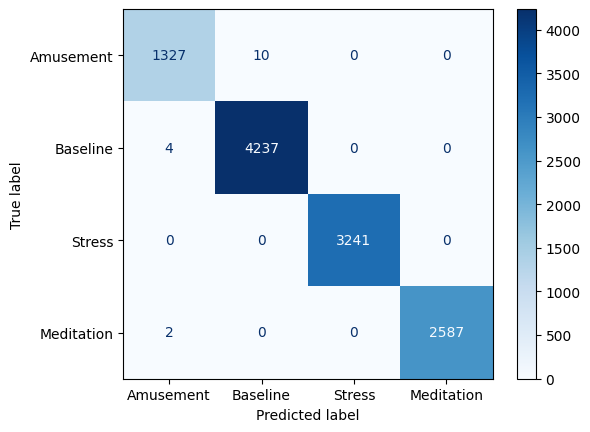

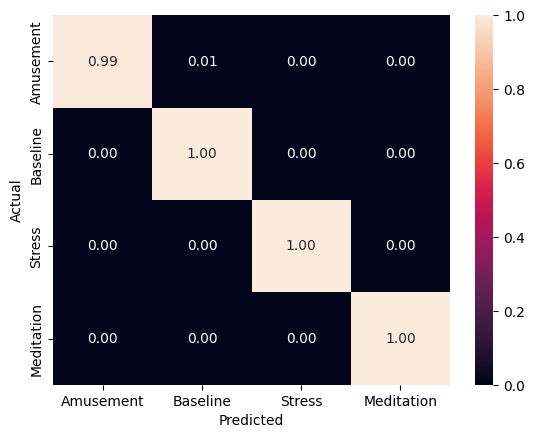

=========================================__Fold__3_______=================================
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_263 (Conv1D)            (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_264 (Conv1D)            (None, 5600, 8)      328         ['conv1d_263[0][0]']             
                                                                                                  
 batch_normalization_126 (Batch  (None, 5600, 8)     32          ['conv1d_264[0][0]']             


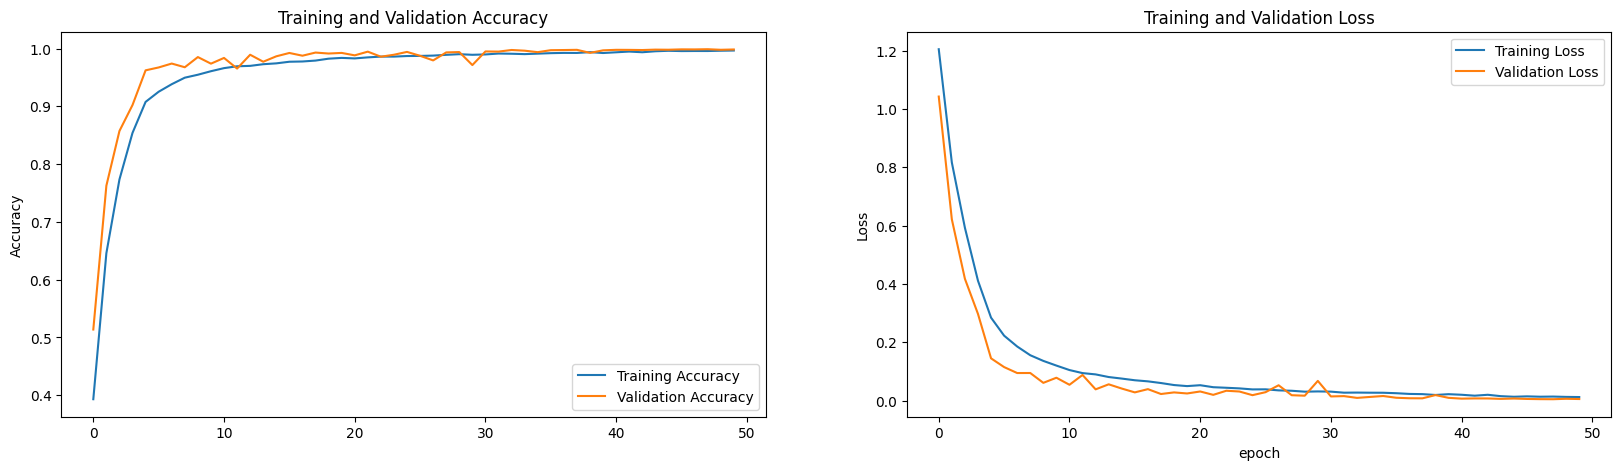

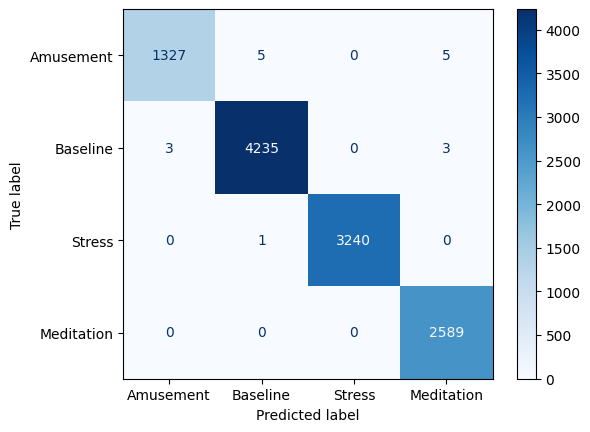

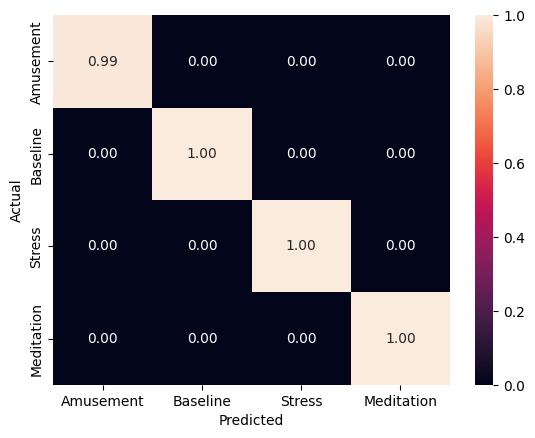

=========================================__Fold__4_______=================================
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_286 (Conv1D)            (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_287 (Conv1D)            (None, 5600, 8)      328         ['conv1d_286[0][0]']             
                                                                                                  
 batch_normalization_137 (Batch  (None, 5600, 8)     32          ['conv1d_287[0][0]']             


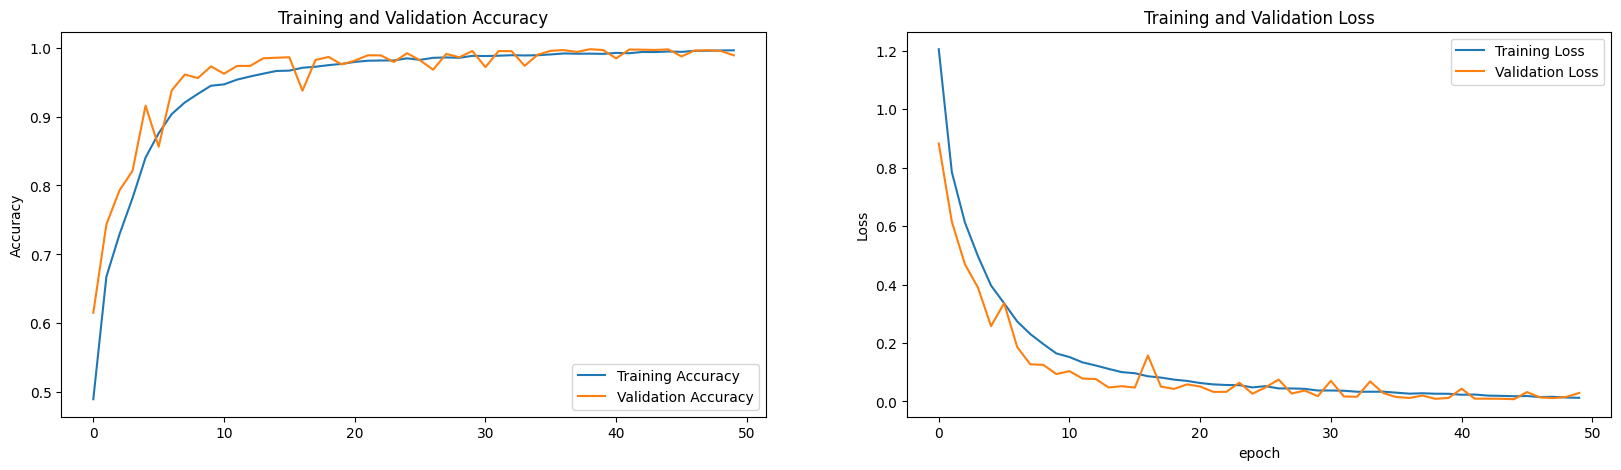

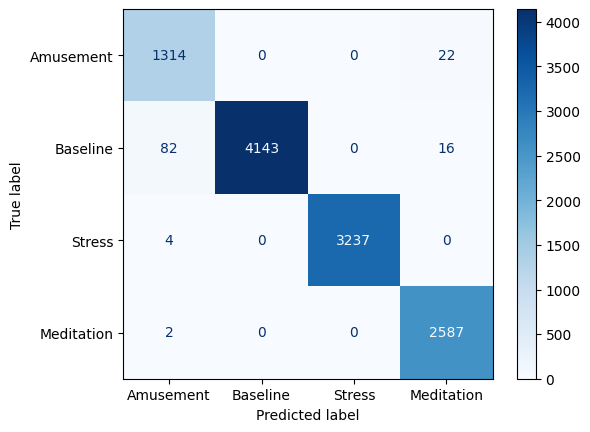

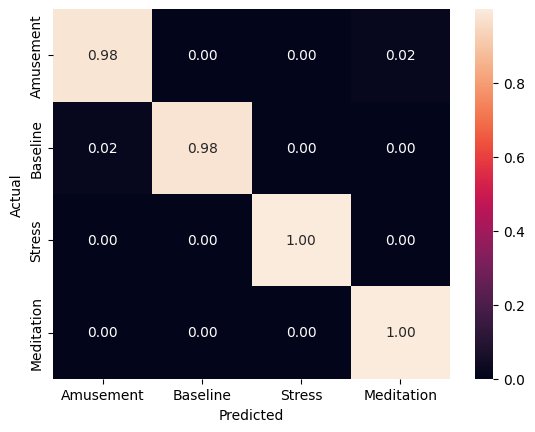

=========================================__Fold__5_______=================================
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_309 (Conv1D)            (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_310 (Conv1D)            (None, 5600, 8)      328         ['conv1d_309[0][0]']             
                                                                                                  
 batch_normalization_148 (Batch  (None, 5600, 8)     32          ['conv1d_310[0][0]']             


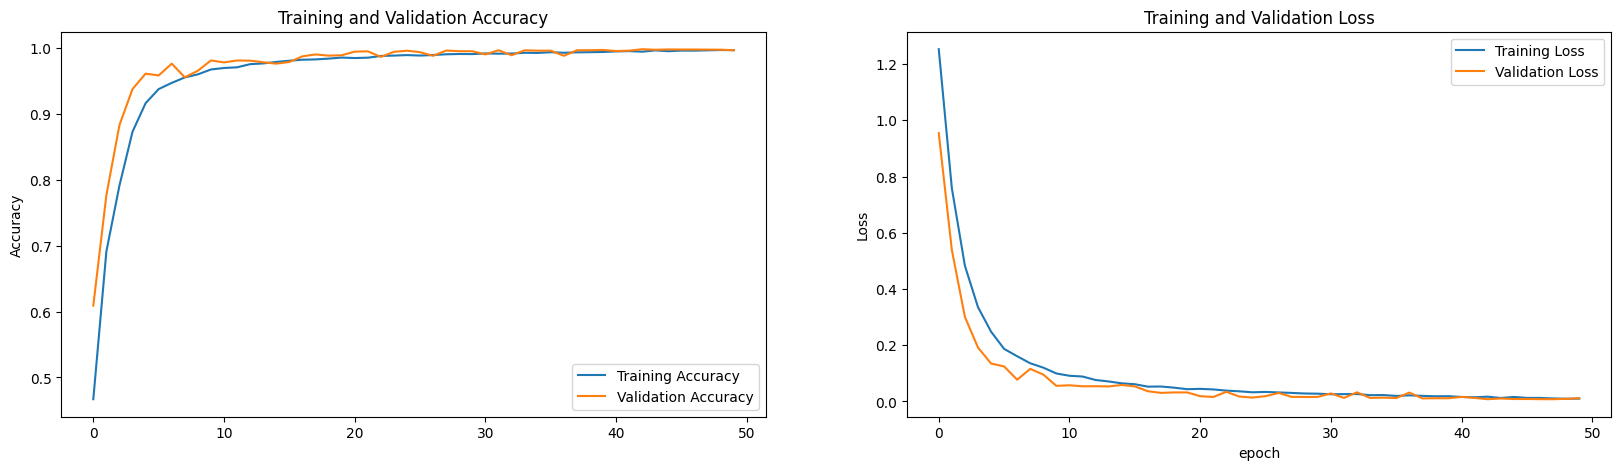

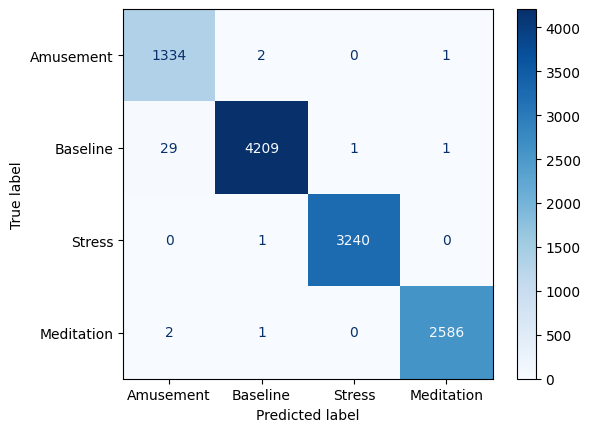

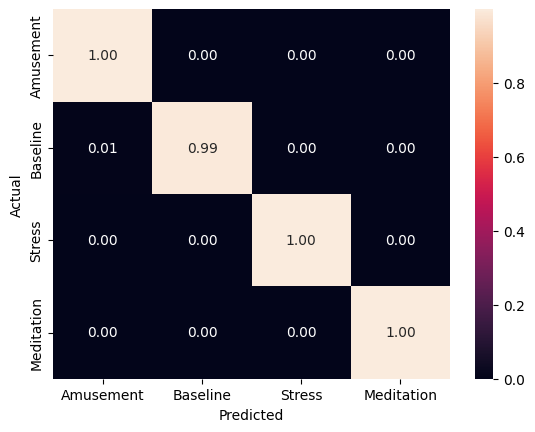

In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=128)
number=1

for train_index, test_index in skf.split(train_beat, train_y):
    print('=========================================__Fold__'+str(number)+'_______=================================')
    X_train_b, X_test_b, X_train_r, X_test_r = train_beat[train_index], train_beat[test_index], train_rhythm[train_index], train_rhythm[test_index]
    Y_train, Y_test = train_y[train_index], train_y[test_index]

    y_train = to_categorical(Y_train)
    y_test = to_categorical(Y_test)    
    class_weight = cal_class_weight(train_y)

    
    fusion_model = WESAD_fusion_model_Multimply(X_train_b.shape[1], X_train_r.shape[1])
    callback_lr = tf.keras.callbacks.LearningRateScheduler(scheuler)
    fusion_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = fusion_model.fit([X_train_b, X_train_r], y_train, 
                        validation_data=([X_test_b, X_test_r], y_test), 
                        epochs=50, 
                        batch_size=32,
                        class_weight = class_weight,
                        callbacks=[callback_lr],
                       ) 

    
    scores = fusion_model.evaluate([X_test_b,X_test_r], y_test)
    Plot_lr_curve(history)
    pred = fusion_model.predict([X_test_b,X_test_r])
    Plot_confusion_matrix(y_test, pred, class_name)

    
    fusion_model.save(save_model_path + '2_Multiply_Fusion_6_layer_8s_Fold(8,2)_'  +str(number)+ '_(' + str(np.round(scores[1]*100,2)) + ').h5')
    number+=1
    
    

# Add

In [19]:
from tensorflow.keras.layers import Average, maximum, Multiply, Add, dot


def WESAD_fusion_model_Add(re_X_train_b, re_X_train_r):
    input_beat = Input(shape=(re_X_train_b,1), name = 'input_beat')
    input_rhythm = Input(shape=(re_X_train_r,1), name = 'input_rhythm')

    conv1_B = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(input_beat)
    conv2_B = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B)
    bn1_B = BatchNormalization()(conv2_B)
    act_B = Activation('relu')(bn1_B)
    max1_B = MaxPooling1D(2,2)(act_B)

    conv1_B_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B)
    conv2_B_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_1)
    bn1_B_1 = BatchNormalization()(conv2_B_1)
    act_B_1 = Activation('relu')(bn1_B_1)
    max1_B_1 = MaxPooling1D(2,2)(act_B_1)


    conv1_B_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_1)
    conv2_B_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_2)
    bn1_B_2 = BatchNormalization()(conv2_B_2)
    act_B_2 = Activation('relu')(bn1_B_2)
    max1_B_2 = MaxPooling1D(2,2)(act_B_2)

    conv1_B_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_2)
    conv2_B_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_3)
    bn1_B_3 = BatchNormalization()(conv2_B_3)
    act_B_3 = Activation('relu')(bn1_B_3)
    max1_B_3 = MaxPooling1D(2,2)(act_B_3)

    conv1_B_3 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_B_3)
    conv2_B_3 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_B_3)
    bn1_B_3 = BatchNormalization()(conv2_B_3)
    act_B_3 = Activation('relu')(bn1_B_3)
    max1_B_3 = MaxPooling1D(2,2)(act_B_3)

    GAP_B = GlobalAveragePooling1D()(max1_B_3)

    # Rhythm

    conv1_R = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(input_rhythm)
    conv2_R = Conv1D(8, 5, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R)
    bn1_R = BatchNormalization()(conv2_R)
    act_R = Activation('relu')(bn1_R)
    max1_R = MaxPooling1D(2,2)(act_R)

    conv1_R_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R)
    conv2_R_1 = Conv1D(16, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_1)
    bn1_R_1 = BatchNormalization()(conv2_R_1)
    act_R_1 = Activation('relu')(bn1_R_1)
    max1_R_1 = MaxPooling1D(2,2)(act_R_1)


    conv1_R_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_1)
    conv2_R_2 = Conv1D(32, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_2)
    bn1_R_2 = BatchNormalization()(conv2_R_2)
    act_R_2 = Activation('relu')(bn1_R_2)
    max1_R_2 = MaxPooling1D(2,2)(act_R_2)


    conv1_R_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_2)
    conv2_R_3 = Conv1D(64, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_3)
    bn1_R_3 = BatchNormalization()(conv2_R_3)
    act_R_3 = Activation('relu')(bn1_R_3)
    max1_R_3 = MaxPooling1D(2,2)(act_R_3)


    conv1_R_4 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_3)
    conv2_R_4 = Conv1D(128, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_4)
    bn1_R_4 = BatchNormalization()(conv2_R_4)
    act_R_4 = Activation('relu')(bn1_R_4)
    max1_R_4 = MaxPooling1D(2,2)(act_R_4)

    conv1_R_5 = Conv1D(256, 3, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_4)
    conv2_R_5 = Conv1D(256, 3, activation=None, padding='same', kernel_initializer=weight_init)(conv1_R_5)
    bn1_R_5 = BatchNormalization()(conv2_R_5)
    act_R_5 = Activation('relu')(bn1_R_5)
    max1_R_5 = MaxPooling1D(2,2)(act_R_5)

    conv1_R_5 = Conv1D(128, 1, activation=None, padding='same', kernel_initializer=weight_init)(max1_R_5)


    GAP_R = GlobalAveragePooling1D()(conv1_R_5)

    # Fusion
    Add_layer = Add()([GAP_B, GAP_R])

    re_R = Reshape((1, Add_layer.shape[1]))(Add_layer)
    x_R_LSTM = LSTM(128,return_sequences=True)(re_R)
    x_R_LSTM2 = LSTM(64, return_sequences=True)(x_R_LSTM)
    fl_f = Flatten()(x_R_LSTM2)

    den1 = Dense(128, activation='relu')(fl_f)
    den2 = Dense(64, activation='relu')(den1)

    fusion_output = Dense(4, activation='softmax')(den2)

    fusion_model = Model(inputs=[input_beat, input_rhythm], outputs= fusion_output)
    fusion_model.summary()
    
    return fusion_model

=========================================__Fold__1_______=================================
Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_332 (Conv1D)            (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_333 (Conv1D)            (None, 5600, 8)      328         ['conv1d_332[0][0]']             
                                                                                                  
 batch_normalization_159 (Batch  (None, 5600, 8)     32          ['conv1d_333[0][0]']             


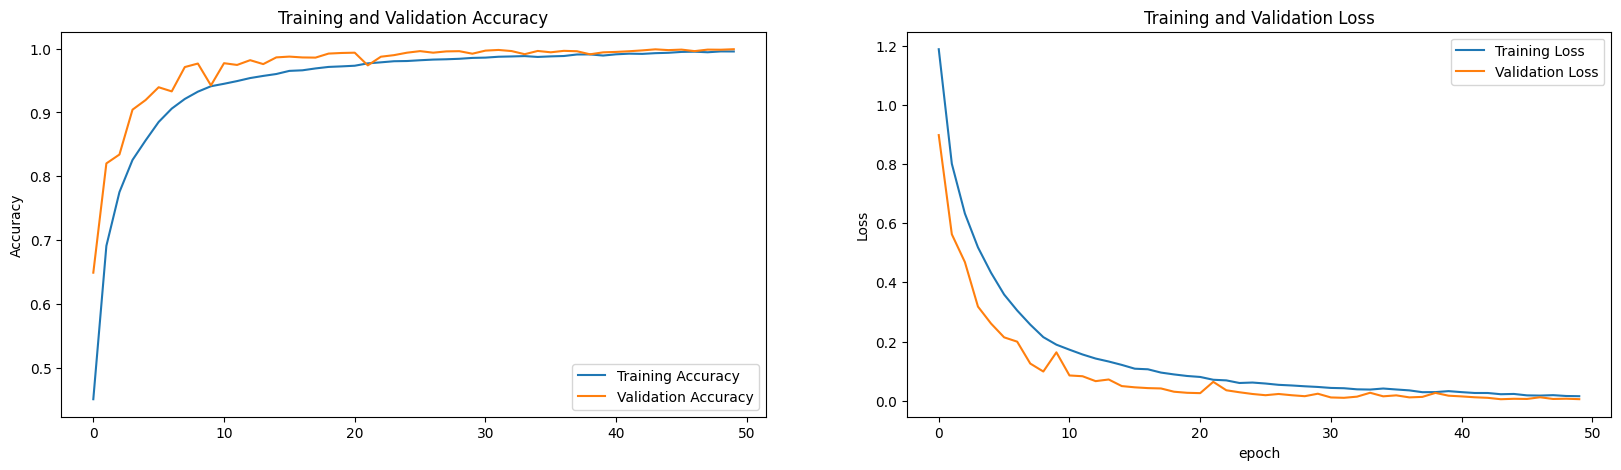

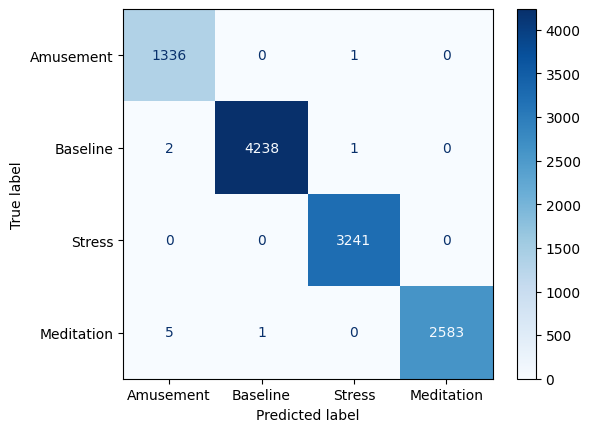

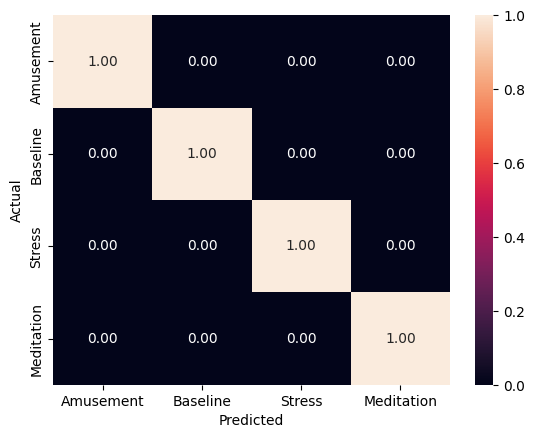

=========================================__Fold__2_______=================================
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_355 (Conv1D)            (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_356 (Conv1D)            (None, 5600, 8)      328         ['conv1d_355[0][0]']             
                                                                                                  
 batch_normalization_170 (Batch  (None, 5600, 8)     32          ['conv1d_356[0][0]']             


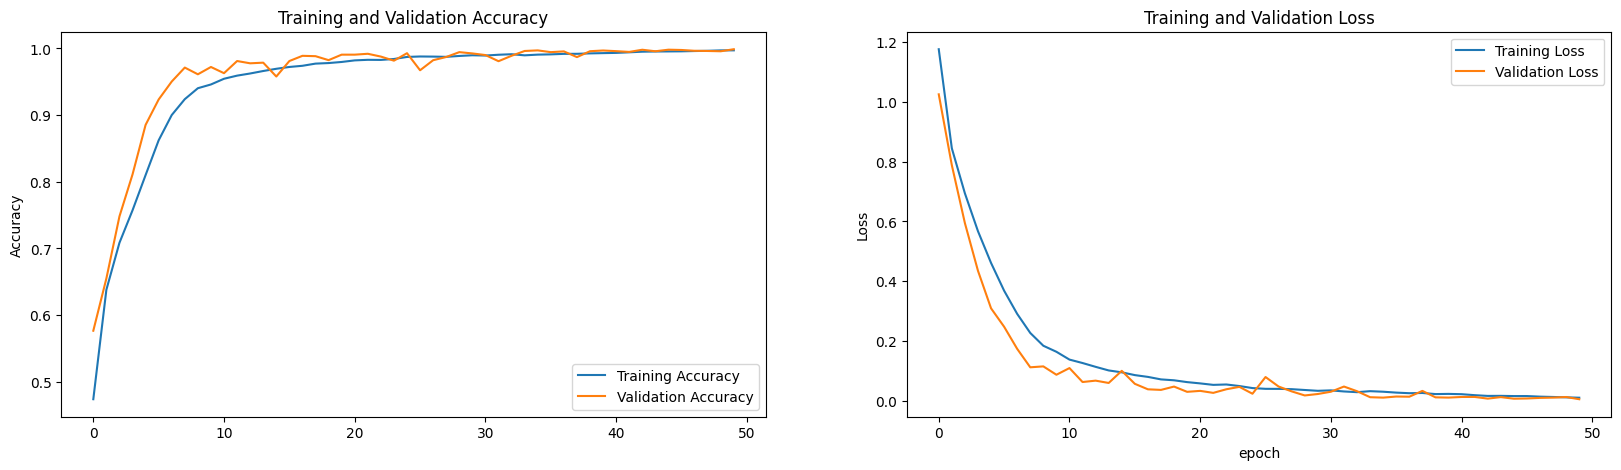

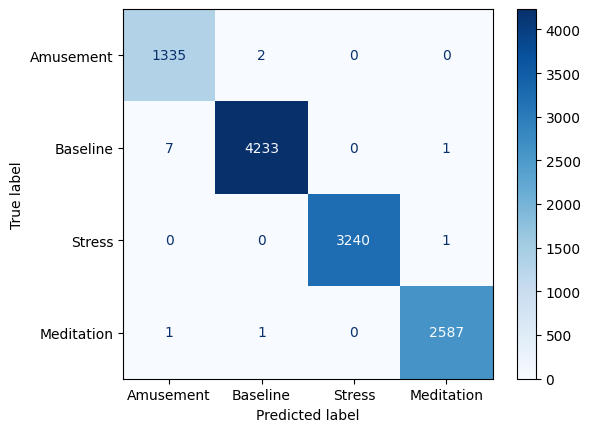

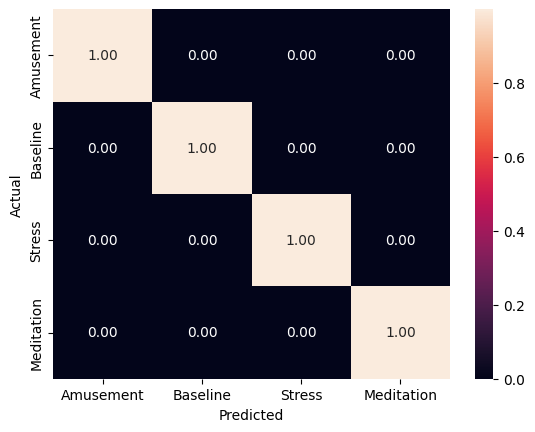

=========================================__Fold__3_______=================================
Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_378 (Conv1D)            (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_379 (Conv1D)            (None, 5600, 8)      328         ['conv1d_378[0][0]']             
                                                                                                  
 batch_normalization_181 (Batch  (None, 5600, 8)     32          ['conv1d_379[0][0]']             


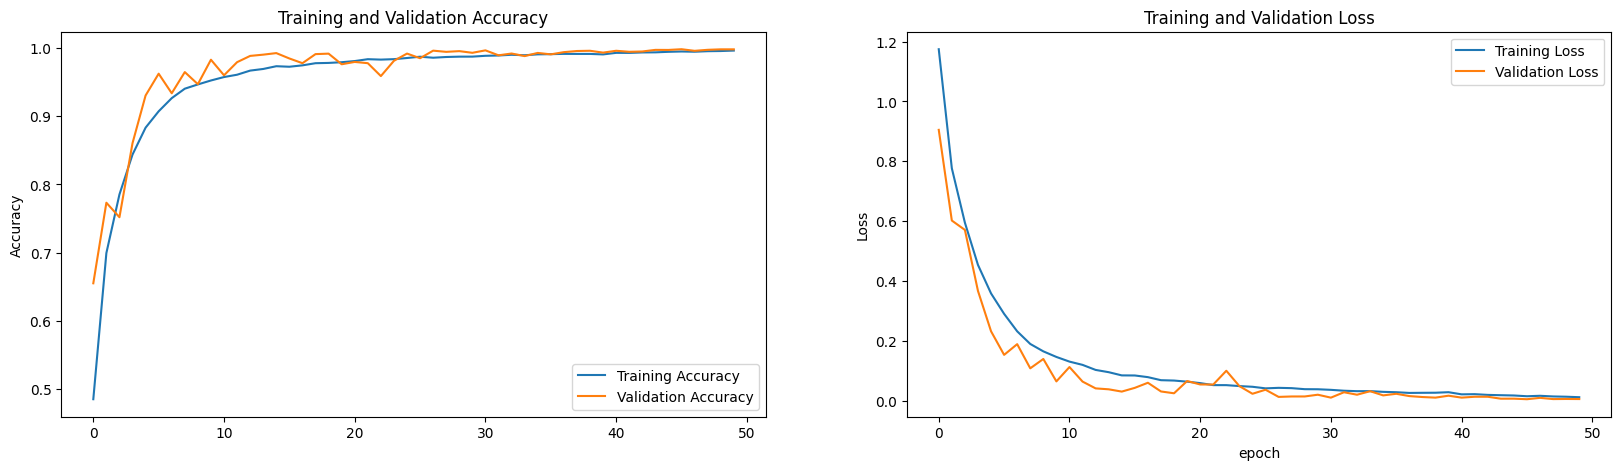

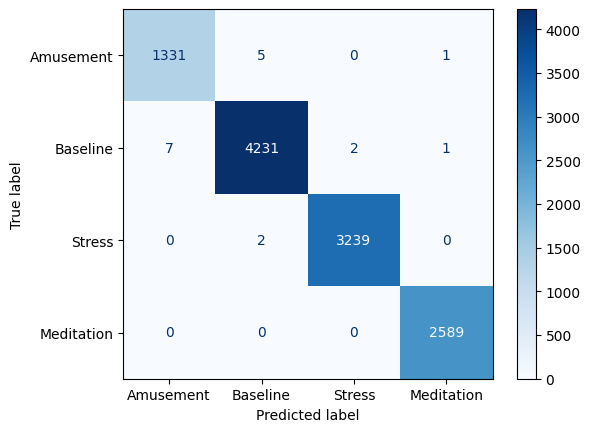

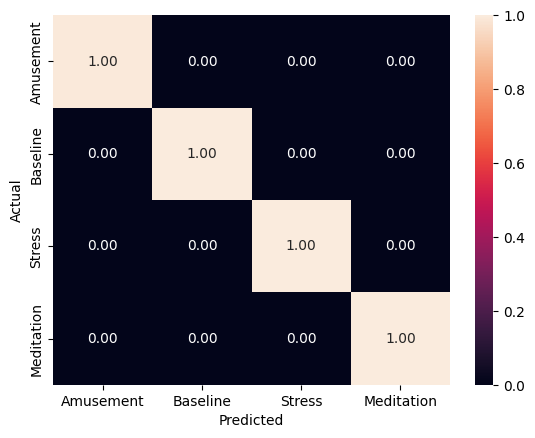

=========================================__Fold__4_______=================================
Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_401 (Conv1D)            (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_402 (Conv1D)            (None, 5600, 8)      328         ['conv1d_401[0][0]']             
                                                                                                  
 batch_normalization_192 (Batch  (None, 5600, 8)     32          ['conv1d_402[0][0]']             


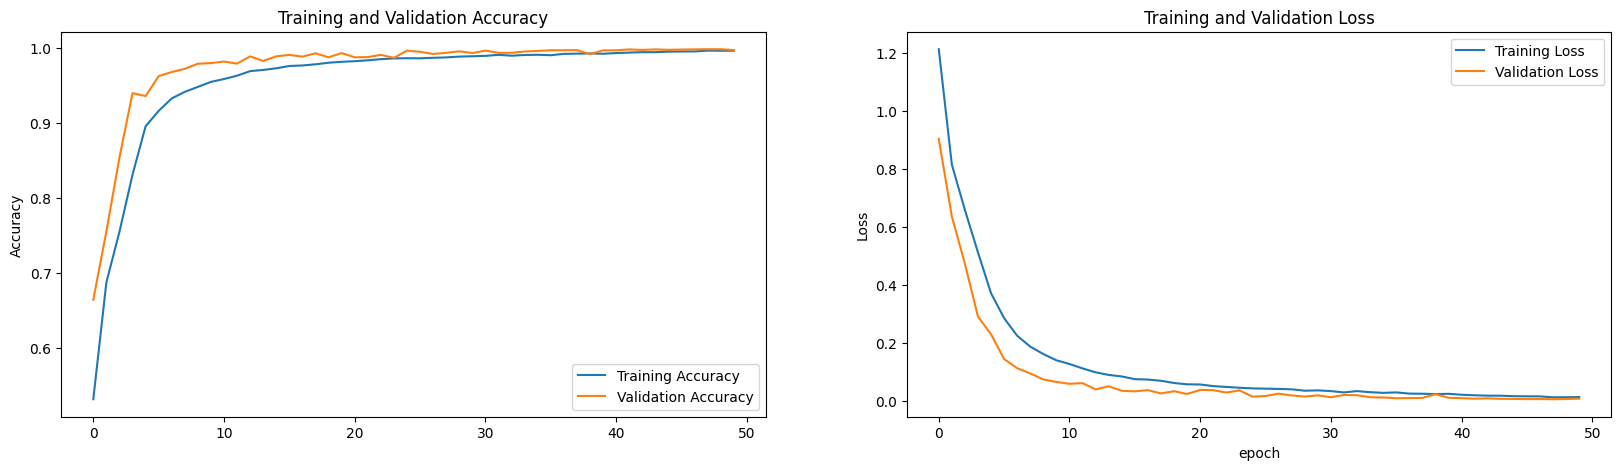

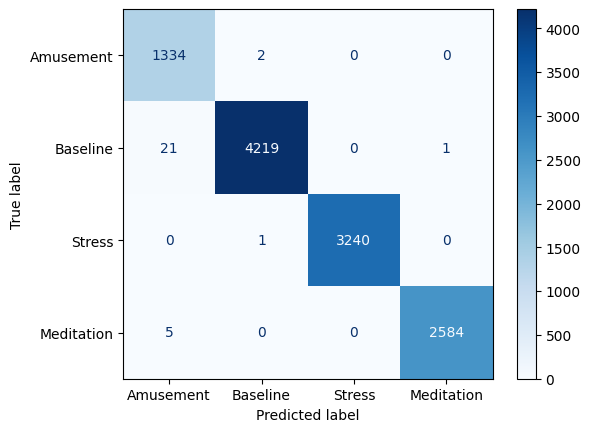

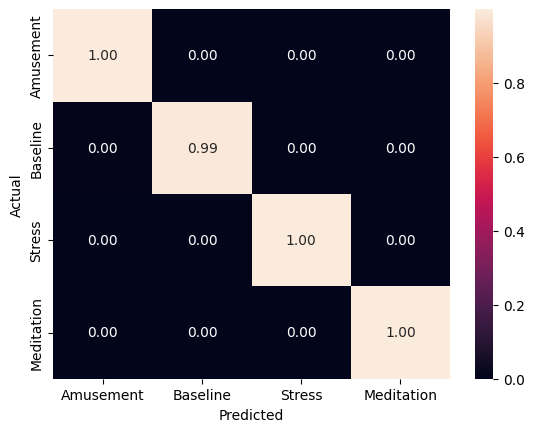

=========================================__Fold__5_______=================================
Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rhythm (InputLayer)      [(None, 5600, 1)]    0           []                               
                                                                                                  
 conv1d_424 (Conv1D)            (None, 5600, 8)      48          ['input_rhythm[0][0]']           
                                                                                                  
 conv1d_425 (Conv1D)            (None, 5600, 8)      328         ['conv1d_424[0][0]']             
                                                                                                  
 batch_normalization_203 (Batch  (None, 5600, 8)     32          ['conv1d_425[0][0]']             


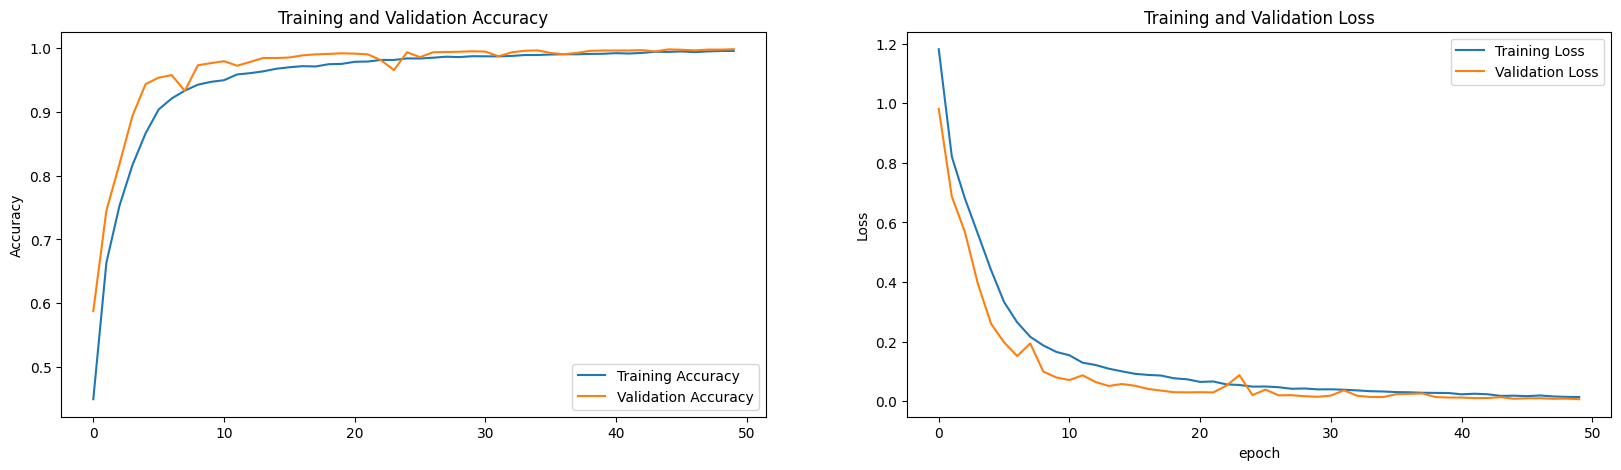

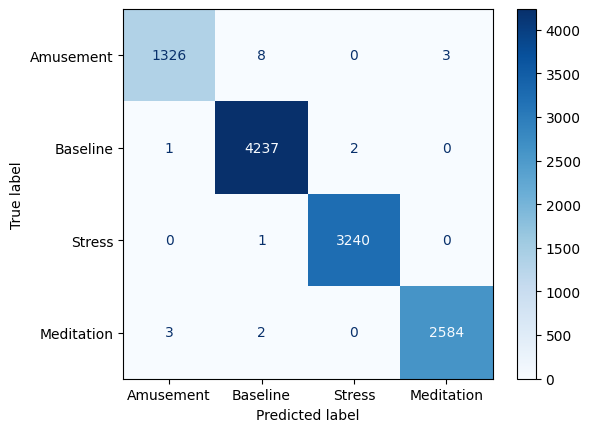

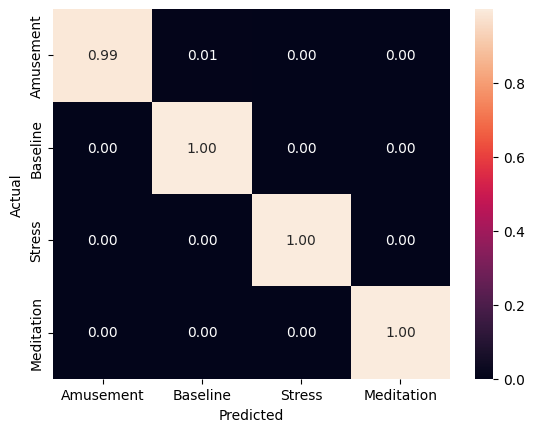

In [20]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=128)
number=1

for train_index, test_index in skf.split(train_beat, train_y):
    print('=========================================__Fold__'+str(number)+'_______=================================')
    X_train_b, X_test_b, X_train_r, X_test_r = train_beat[train_index], train_beat[test_index], train_rhythm[train_index], train_rhythm[test_index]
    Y_train, Y_test = train_y[train_index], train_y[test_index]

    y_train = to_categorical(Y_train)
    y_test = to_categorical(Y_test)    
    class_weight = cal_class_weight(train_y)

    
    fusion_model = WESAD_fusion_model_Add(X_train_b.shape[1], X_train_r.shape[1])
    callback_lr = tf.keras.callbacks.LearningRateScheduler(scheuler)
    fusion_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = fusion_model.fit([X_train_b, X_train_r], y_train, 
                        validation_data=([X_test_b, X_test_r], y_test), 
                        epochs=50, 
                        batch_size=32,
                        class_weight = class_weight,
                        callbacks=[callback_lr],
                       ) 

    
    scores = fusion_model.evaluate([X_test_b,X_test_r], y_test)
    Plot_lr_curve(history)
    pred = fusion_model.predict([X_test_b,X_test_r])
    Plot_confusion_matrix(y_test, pred, class_name)

    
    fusion_model.save(save_model_path + '2_Add_Fusion_6_layer_8s_Fold(8,2)_'  +str(number)+ '_(' + str(np.round(scores[1]*100,2)) + ').h5')
    number+=1
    
    